In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import font_manager
from copy import copy
import pandas as pd
import datetime

In [2]:
%matplotlib inline

label_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=20
)
tick_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=14
)

## Analysis of total cases

![](out/seihrd.png)

This is the idealised SEIR model with isolation (Hospitalisation) and Deaths. In the model below, we also want to capture the discharge information (H to R) so we capture them in a new compartment G (discharGe).

The data we have is:
- newly reported cases (entries into the I compartment)
- cumulative newly reported cases (square I box)
- number of people in isolation (H)
- cumulative number of people ever in isolation (square box H)
- number of discharged from isolation
- number of deaths

In [3]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+R+G+H),
        b*S*I/(S+E+I+R+G+H)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        e*I,
        m*I,
        g*E,
        e*I
    ]

In [4]:
read_file = True
if read_file:
    raw_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])

In [5]:
the_dates = list(map(lambda t: datetime.datetime.strptime(t, "%d/%m/%Y"), raw_data.Date.values))
def time_conv(time: float):
    return the_dates[0] + datetime.timedelta(days=time)

In [6]:
time, cE, H, cH, D, G = raw_data.iloc[:,1:].values.T

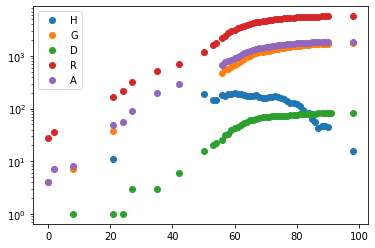

In [7]:
plt.semilogy(time, H, 'o', time, G, 'o', time, D, 'o', time, cE, 'o', time , cH, 'o')
plt.legend("HGDRA")

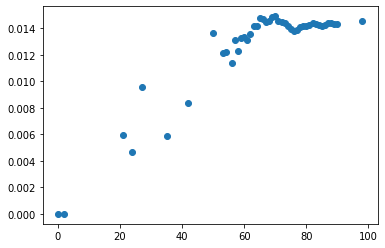

In [8]:
plt.plot(time,[d/ce if ce else None for d,ce in zip(D,cE)],'o')

In [9]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 0
clip = 17
data_time = time[start:clip]
data_pd = data_pd[start:clip,:]

p0 = [2, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.25],
#     "time_span": [time[0], 150],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [10]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 50,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [11]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
fr_ex = ca.Function('fr_ex', [solver_setup['x']], [objective.regularisation])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [12]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 3e1

In [13]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

(0, 3000)

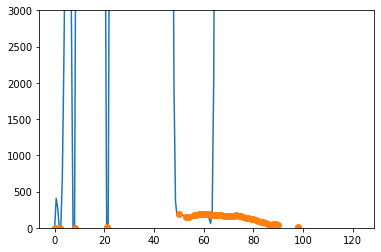

In [14]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[3])
plt.plot(time, H, 'o')
plt.ylim([0, 3000])

In [15]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

1700  3.8180856e+01 0.00e+00 3.52e-04  -9.0 5.07e+02    -  1.00e+00 1.00e+00h  1
1750  3.8180856e+01 0.00e+00 1.21e-04  -9.0 3.12e+02    -  1.00e+00 1.00e+00h  1
1800  3.8180856e+01 0.00e+00 2.16e-03  -9.0 5.29e+03    -  1.00e+00 2.50e-01h  3
1850  3.8180855e+01 0.00e+00 1.78e-03  -9.0 2.01e+04    -  1.00e+00 6.25e-02h  5
1900  3.8180855e+01 0.00e+00 7.60e-06  -9.0 9.69e+01    -  1.00e+00 1.00e+00h  1
1950  3.8180855e+01 0.00e+00 1.33e-03  -9.0 1.17e+03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  3.8180855e+01 0.00e+00 1.65e-03  -9.0 5.20e+03    -  1.00e+00 2.50e-01h  3
2050  3.8180855e+01 0.00e+00 3.68e-03  -9.0 4.07e+03    -  1.00e+00 5.00e-01h  2
2100  3.8180855e+01 0.00e+00 3.15e-03  -9.0 3.85e+03    -  1.00e+00 5.00e-01h  2
2150  3.8180855e+01 0.00e+00 1.61e-03  -9.0 1.13e+04    -  1.00e+00 1.25e-01h  4
2200  3.8180855e+01 0.00e+00 2.69e-04  -9.0 6.02e+02    -  1.00e+00 1.00e+00h  1
2250  3.8180855e+01 0.00e+00

 150  3.8386674e+01 0.00e+00 2.97e-01  -5.7 1.76e+03    -  1.00e+00 1.00e+00f  1
 200  3.8346520e+01 0.00e+00 7.10e-02  -5.7 1.32e+01    -  1.00e+00 1.00e+00f  1
 250  3.8343282e+01 0.00e+00 2.95e-02  -5.7 5.38e+00    -  1.00e+00 1.00e+00h  1
 300  3.8342407e+01 0.00e+00 3.24e-02  -5.7 2.04e+02    -  1.00e+00 3.12e-02h  6
 350  3.8342118e+01 0.00e+00 8.80e-04  -5.7 1.92e+00    -  1.00e+00 1.00e+00h  1
 400  3.8341579e+01 0.00e+00 1.71e-01  -8.6 4.45e+01    -  1.00e+00 1.00e+00h  1
 450  3.8341800e+01 0.00e+00 8.33e-01  -8.6 3.36e+02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.8341432e+01 0.00e+00 2.60e-02  -8.6 7.22e+02    -  1.00e+00 6.25e-02h  5
 550  3.8341408e+01 0.00e+00 3.08e-02  -8.6 2.70e+02    -  1.00e+00 2.50e-01h  3
 600  3.8341391e+01 0.00e+00 7.89e-05  -8.6 7.26e+00    -  1.00e+00 1.00e+00h  1
 650  3.8341377e+01 0.00e+00 1.74e-02  -8.6 8.71e+02    -  1.00e+00 1.25e-01h  4
 700  3.8341367e+01 0.00e+00

 650  3.8445523e+01 0.00e+00 5.00e-03  -8.6 2.51e+01    -  1.00e+00 1.00e+00h  1
 700  3.8445504e+01 0.00e+00 3.17e-02  -8.6 1.63e+02    -  1.00e+00 5.00e-01h  2
 750  3.8445491e+01 0.00e+00 2.36e-03  -8.6 3.08e+01    -  1.00e+00 1.00e+00h  1
 800  3.8445491e+01 0.00e+00 1.49e-01  -8.6 6.11e+02    -  1.00e+00 5.00e-01h  2
 850  3.8445476e+01 0.00e+00 1.55e-03  -8.6 4.05e+01    -  1.00e+00 1.00e+00h  1
 900  3.8445471e+01 0.00e+00 5.08e-03  -8.6 2.82e+03    -  1.00e+00 3.12e-02h  6
 950  3.8445467e+01 0.00e+00 4.18e-04  -8.6 3.24e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.8445464e+01 0.00e+00 2.38e-03  -8.6 9.06e+01    -  1.00e+00 1.00e+00h  1
1050  3.8445462e+01 0.00e+00 2.64e-03  -8.6 1.14e+02    -  1.00e+00 1.00e+00h  1
1100  3.8445459e+01 0.00e+00 5.75e-03  -8.6 2.23e+02    -  1.00e+00 1.00e+00h  1
1150  3.8445458e+01 0.00e+00 2.90e-03  -8.6 1.35e+03    -  1.00e+00 1.25e-01h  4
1200  3.8445457e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.8567588e+01 0.00e+00 4.62e-02  -9.0 1.95e+04    -  1.00e+00 1.56e-02h  7
In iteration 1036, 1 Slack too small, adjusting variable bound
In iteration 1040, 1 Slack too small, adjusting variable bound
1050  3.8567585e+01 0.00e+00 3.88e-03  -9.0 2.86e+02    -  1.00e+00 1.00e+00h  1
1100  3.8567584e+01 0.00e+00 4.24e-02  -9.0 1.79e+04    -  1.00e+00 1.56e-02h  7
1150  3.8567583e+01 0.00e+00 5.53e-03  -9.0 1.73e+03    -  1.00e+00 2.50e-01h  3
1200  3.8567583e+01 0.00e+00 5.12e-04  -9.0 1.53e+02    -  1.00e+00 1.00e+00h  1
1250  3.8567582e+01 0.00e+00 1.48e-02  -9.0 1.82e+03    -  1.00e+00 5.00e-01h  2
1300  3.8567582e+01 0.00e+00 3.21e-03  -9.0 4.74e+02    -  1.00e+00 1.00e+00h  1
1350  3.8567582e+01 0.00e+00 2.59e-03  -9.0 4.47e+02    -  1.00e+00 1.00e+00h  1
1400  3.8567582e+01 0.00e+00 2.00e-02  -9.0 8.86e+03    -  1.00e+00 6.25e-02h  5
1450  3.8567581e+01 0.00e+00 9.83e-05  -9.0 5.60e+01    -  1.00e

1200  3.8708393e+01 0.00e+00 8.19e-03  -8.6 1.43e+02    -  1.00e+00 1.00e+00h  1
1250  3.8708391e+01 0.00e+00 1.41e-02  -8.6 8.54e+02    -  1.00e+00 2.50e-01h  3
1300  3.8708389e+01 0.00e+00 1.17e-02  -8.6 2.33e+02    -  1.00e+00 1.00e+00h  1
1350  3.8708387e+01 0.00e+00 5.69e-03  -8.6 1.40e+03    -  1.00e+00 1.25e-01h  4
1400  3.8708386e+01 0.00e+00 1.40e-03  -8.6 1.05e+02    -  1.00e+00 1.00e+00h  1
1450  3.8708385e+01 0.00e+00 2.63e-03  -8.6 1.63e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.8708384e+01 0.00e+00 2.77e-02  -8.6 1.19e+03    -  1.00e+00 5.00e-01h  2
1550  3.8708383e+01 0.00e+00 1.47e-02  -8.6 4.90e+02    -  1.00e+00 1.00e+00H  1
1600  3.8708383e+01 0.00e+00 4.17e-03  -8.6 2.91e+02    -  1.00e+00 1.00e+00h  1
In iteration 1645, 1 Slack too small, adjusting variable bound
In iteration 1649, 1 Slack too small, adjusting variable bound
1650  3.8964962e+01 0.00e+00 3.48e+01  -9.0 3.40e+03 -10.7 3.19e

1350  3.8867700e+01 0.00e+00 1.80e-03  -8.6 7.70e+01    -  1.00e+00 1.00e+00h  1
1400  3.8867698e+01 0.00e+00 1.44e-03  -8.6 7.90e+01    -  1.00e+00 1.00e+00h  1
1450  3.8867697e+01 0.00e+00 4.13e-04  -8.6 4.89e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.8867696e+01 0.00e+00 5.31e-03  -8.6 1.94e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1536

                                   (scaled)                 (unscaled)
Objective...............:   3.8867695005020082e+01    3.8867695005020082e+01
Dual infeasibility......:   2.2525292213640528e-10    2.2525292213640528e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035681054596e-09    2.5059035681054596e-09
Overall NLP error.......:   2.5059035681054596e-09    2.5059035681054596e-09


Number of objective function evaluations             = 2975
Number of objective gradient evaluations    

 100  4.1086863e+01 0.00e+00 4.93e+01  -2.5 3.36e+03 -11.3 6.74e-01 1.00e+00f  1
 150  4.0286530e+01 0.00e+00 2.93e+00  -5.7 6.63e+04 -12.6 1.24e-01 4.67e-02f  4
 200  3.9619401e+01 0.00e+00 3.70e+00  -5.7 2.81e+03 -12.0 1.00e+00 1.00e+00f  1
 250  3.9264611e+01 0.00e+00 2.50e+00  -5.7 5.59e+01    -  1.00e+00 1.00e+00f  1
 300  3.9251627e+01 0.00e+00 7.50e-01  -5.7 4.49e+01    -  1.00e+00 2.50e-01f  3
 350  3.9248314e+01 0.00e+00 7.52e-02  -5.7 2.10e+00    -  1.00e+00 1.00e+00h  1
 400  3.9246991e+01 0.00e+00 2.31e-01  -5.7 4.89e+01    -  1.00e+00 1.25e-01h  4
 450  3.9246372e+01 0.00e+00 2.52e-02  -5.7 3.36e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.9246050e+01 0.00e+00 8.64e-02  -5.7 8.76e+00    -  1.00e+00 1.00e+00h  1
 550  3.9245861e+01 0.00e+00 2.35e-02  -5.7 6.18e+00    -  1.00e+00 1.00e+00h  1
 600  3.9247976e+01 0.00e+00 4.55e+00  -8.6 2.41e+02    -  1.00e+00 5.00e-01h  2
 650  3.9245239e+01 0.00e+00

 200  3.9501660e+01 0.00e+00 2.00e+00  -5.7 6.68e+01    -  1.00e+00 1.00e+00f  1
 250  3.9476986e+01 0.00e+00 8.57e-01  -5.7 1.54e+01    -  1.00e+00 1.00e+00f  1
 300  3.9471722e+01 0.00e+00 8.61e-02  -5.7 2.11e+00    -  1.00e+00 1.00e+00f  1
 350  3.9469817e+01 0.00e+00 7.70e-02  -5.7 2.44e+00    -  1.00e+00 1.00e+00h  1
 400  3.9468915e+01 0.00e+00 4.94e-01  -5.7 1.93e+01    -  1.00e+00 5.00e-01h  2
 450  3.9468458e+01 0.00e+00 3.66e-03  -5.7 1.37e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.9505730e+01 0.00e+00 1.97e+01  -5.7 2.51e+02 -11.6 8.96e-01 1.42e-14h 47
 550  3.9468004e+01 0.00e+00 2.32e-02  -5.7 5.96e+00    -  1.00e+00 1.00e+00h  1
 600  3.9467592e+01 0.00e+00 1.60e-01  -8.6 1.55e+02    -  1.00e+00 1.25e-01h  4
 650  3.9467485e+01 0.00e+00 1.09e-01  -8.6 2.25e+01    -  1.00e+00 1.00e+00h  1
 700  3.9467423e+01 0.00e+00 2.34e-02  -8.6 1.34e+01    -  1.00e+00 1.00e+00h  1
 750  3.9467372e+01 0.00e+00

1750  3.9741565e+01 0.00e+00 1.89e-02  -8.6 1.27e+02    -  1.00e+00 1.00e+00h  1
1800  3.9741563e+01 0.00e+00 1.94e-03  -8.6 4.52e+01    -  1.00e+00 1.00e+00h  1
1850  3.9741562e+01 0.00e+00 2.05e-02  -8.6 3.09e+02    -  1.00e+00 5.00e-01h  2
1900  3.9741561e+01 0.00e+00 4.09e-03  -8.6 7.88e+01    -  1.00e+00 1.00e+00h  1
1950  3.9741559e+01 0.00e+00 4.56e-04  -8.6 2.95e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 1957

                                   (scaled)                 (unscaled)
Objective...............:   3.9741559139500716e+01    3.9741559139500716e+01
Dual infeasibility......:   7.9247703345924527e-10    7.9247703345924527e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035599871989e-09    2.5059035599871989e-09
Overall NLP error.......:   2.5059035599871989e-09    2.5059035599871989e-09


Number of objective fun

  50  4.2468156e+01 0.00e+00 8.72e+01  -2.5 7.05e+02 -10.6 1.00e+00 1.00e+00f  1
 100  4.2595087e+01 0.00e+00 4.24e+01  -2.5 2.18e+04    -  4.77e-01 1.54e-01f  3
 150  4.2707871e+01 0.00e+00 5.17e+00  -3.8 1.05e+04    -  7.51e-01 7.98e-01f  1
 200  4.2132065e+01 0.00e+00 6.32e+00  -5.7 1.47e+04 -11.2 2.55e-01 5.73e-02f  4
 250  4.1224754e+01 0.00e+00 1.53e+01  -5.7 8.30e+03    -  3.35e-01 5.09e-01f  1
 300  4.0553481e+01 0.00e+00 4.51e+00  -5.7 9.27e+01    -  1.00e+00 5.00e-01f  2
 350  4.0538237e+01 0.00e+00 9.09e-01  -5.7 2.01e+01    -  1.00e+00 1.00e+00f  1
 400  4.0533849e+01 0.00e+00 3.47e-01  -5.7 3.88e+00    -  1.00e+00 1.00e+00h  1
 450  4.0532096e+01 0.00e+00 3.60e-01  -5.7 5.20e+00    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.0531183e+01 0.00e+00 8.04e-02  -5.7 2.19e+00    -  1.00e+00 1.00e+00h  1
 550  4.0530673e+01 0.00e+00 4.08e-01  -5.7 1.32e+01    -  1.00e+00 5.00e-01h  2
 600  4.0530368e+01 0.00e+00

 300  4.2625863e+01 0.00e+00 8.59e+00  -5.7 6.62e+02 -10.3 1.00e+00 3.38e-01f  1
 350  4.1706822e+01 0.00e+00 5.23e+00  -5.7 5.76e+02    -  1.00e+00 5.00e-01f  2
 400  4.1057483e+01 0.00e+00 1.27e+00  -5.7 1.82e+01    -  1.00e+00 1.00e+00f  1
 450  4.1044630e+01 0.00e+00 2.07e+00  -5.7 1.31e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.1040632e+01 0.00e+00 6.56e-01  -5.7 7.82e+00    -  1.00e+00 5.00e-01h  2
 550  4.1038946e+01 0.00e+00 5.76e-01  -5.7 5.15e+01    -  1.00e+00 6.25e-02f  5
 600  4.1038053e+01 0.00e+00 2.08e-01  -5.7 2.89e+00    -  1.00e+00 1.00e+00h  1
 650  4.1037595e+01 0.00e+00 6.76e-02  -5.7 2.22e+00    -  1.00e+00 1.00e+00h  1
 700  4.1037302e+01 0.00e+00 2.51e-01  -5.7 4.30e+01    -  1.00e+00 1.25e-01h  4
 750  4.1037080e+01 0.00e+00 1.27e-01  -5.7 8.07e+01    -  1.00e+00 6.25e-02h  5
 800  4.1036958e+01 0.00e+00 6.83e-02  -5.7 7.08e+01    -  1.00e+00 6.25e-02h  5
 850  4.1036870e+01 0.00e+00

 450  4.1627930e+01 0.00e+00 3.55e-01  -5.7 1.62e+01    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.1627121e+01 0.00e+00 9.68e-01  -5.7 3.83e+01    -  1.00e+00 1.25e-01h  4
 550  4.1626857e+01 0.00e+00 3.05e+00  -5.7 2.26e+01    -  1.00e+00 5.00e-01h  2
 600  4.1626351e+01 0.00e+00 4.45e-02  -5.7 1.80e+00    -  1.00e+00 1.00e+00h  1
 650  4.1626168e+01 0.00e+00 2.20e-02  -5.7 1.57e+00    -  1.00e+00 1.00e+00h  1
 700  4.1626043e+01 0.00e+00 1.19e-02  -5.7 1.39e+00    -  1.00e+00 1.00e+00h  1
 750  4.1625964e+01 0.00e+00 5.55e-01  -5.7 2.16e+01    -  1.00e+00 5.00e-01h  2
 800  4.1625897e+01 0.00e+00 7.59e-03  -5.7 1.46e+00    -  1.00e+00 1.00e+00h  1
 850  4.1625853e+01 0.00e+00 5.56e-04  -5.7 4.56e-01    -  1.00e+00 1.00e+00h  1
 900  4.1625827e+01 0.00e+00 4.88e-04  -5.7 4.43e-01    -  1.00e+00 1.00e+00h  1
 950  4.1625300e+01 0.00e+00 9.58e-02  -8.6 8.61e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 900  4.2970467e+01 0.00e+00 1.38e-01  -5.7 3.19e+01    -  1.00e+00 5.00e-01h  2
 950  4.2970411e+01 0.00e+00 4.60e-02  -5.7 1.08e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.2970372e+01 0.00e+00 1.08e-01  -5.7 3.61e+01    -  1.00e+00 5.00e-01h  2
1050  4.2970349e+01 0.00e+00 6.77e-05  -5.7 4.95e-01    -  1.00e+00 1.00e+00h  1
1100  4.2969942e+01 0.00e+00 1.17e-01  -8.6 2.67e+01    -  1.00e+00 1.00e+00h  1
1150  4.2969899e+01 0.00e+00 3.31e-03  -8.6 5.58e+00    -  1.00e+00 1.00e+00h  1
1200  4.2969863e+01 0.00e+00 1.05e-02  -8.6 1.13e+01    -  1.00e+00 1.00e+00h  1
1250  4.2969833e+01 0.00e+00 1.60e-01  -8.6 4.04e+02    -  1.00e+00 1.25e-01h  4
1300  4.2969810e+01 0.00e+00 6.22e-02  -8.6 3.73e+01    -  1.00e+00 1.00e+00h  1
1350  4.2969791e+01 0.00e+00 2.54e-01  -8.6 1.72e+02    -  1.00e+00 5.00e-01h  2
1400  4.2969774e+01 0.00e+00 1.07e-02  -8.6 2.06e+01    -  1.00e+00 1.00e+00h  1
1450  4.2969761e+01 0.00e+00

1050  4.3812532e+01 0.00e+00 5.96e-02  -5.7 6.44e+00  -7.6 1.00e+00 1.00e+00h  1
1100  4.3812405e+01 0.00e+00 2.53e-01  -5.7 3.04e+01    -  1.00e+00 5.00e-01h  2
1150  4.3812312e+01 0.00e+00 1.21e-02  -5.7 4.09e+00    -  1.00e+00 1.00e+00h  1
1200  4.3812244e+01 0.00e+00 5.41e-03  -5.7 3.14e+00    -  1.00e+00 1.00e+00h  1
1250  4.3812189e+01 0.00e+00 6.97e-03  -5.7 3.97e+00    -  1.00e+00 1.00e+00h  1
1300  4.3812150e+01 0.00e+00 5.87e-02  -5.7 2.40e+01    -  1.00e+00 5.00e-01h  2
1350  4.3811816e+01 0.00e+00 2.42e-01  -8.6 2.80e+01    -  1.00e+00 1.00e+00f  1
1400  4.3811756e+01 0.00e+00 1.07e-02  -8.6 7.19e+00    -  1.00e+00 1.00e+00h  1
1450  4.3811712e+01 0.00e+00 1.57e-01  -8.6 3.17e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  4.3811675e+01 0.00e+00 2.07e-01  -8.6 3.34e+02    -  1.00e+00 1.25e-01h  4
1550  4.3811644e+01 0.00e+00 1.42e-01  -8.6 3.18e+02    -  1.00e+00 1.25e-01h  4
1600  4.3811619e+01 0.00e+00

1450  4.4754666e+01 0.00e+00 1.56e-02  -5.7 5.93e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  4.4754641e+01 0.00e+00 4.52e-02  -5.7 1.08e+01    -  1.00e+00 1.00e+00h  1
1550  4.4754300e+01 0.00e+00 3.06e-02  -8.6 1.03e+01    -  1.00e+00 1.00e+00h  1
1600  4.4754227e+01 0.00e+00 2.12e-01  -8.6 6.58e+01    -  1.00e+00 5.00e-01h  2
1650  4.4754184e+01 0.00e+00 4.13e-02  -8.6 1.87e+01    -  1.00e+00 1.00e+00h  1
1700  4.4754159e+01 0.00e+00 1.52e-01  -8.6 4.08e+01    -  1.00e+00 1.00e+00h  1
1750  4.4754135e+01 0.00e+00 1.91e-01  -8.6 5.23e+01    -  1.00e+00 1.00e+00h  1
1800  4.4754117e+01 0.00e+00 1.72e-02  -8.6 1.79e+01    -  1.00e+00 1.00e+00h  1
1850  4.4754101e+01 0.00e+00 7.39e-02  -8.6 4.16e+01    -  1.00e+00 1.00e+00h  1
1900  4.4754088e+01 0.00e+00 1.61e-02  -8.6 2.18e+01    -  1.00e+00 1.00e+00h  1
1950  4.4754076e+01 0.00e+00 1.33e-01  -8.6 2.69e+02    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr 

 150  4.8108956e+01 0.00e+00 4.27e-01  -5.7 2.37e+02 -12.1 1.00e+00 1.00e+00f  1
 200  4.8104364e+01 0.00e+00 4.60e+00  -5.7 2.33e+03 -13.4 1.00e+00 2.50e-01f  3
 250  4.8096621e+01 0.00e+00 1.95e+00  -5.7 1.05e+02  -9.7 1.00e+00 1.00e+00f  1
 300  4.8083651e+01 0.00e+00 9.13e+00  -5.7 1.97e+03 -11.9 1.00e+00 2.79e-01f  2
 350  4.8074955e+01 0.00e+00 3.46e-02  -5.7 2.99e+01  -9.0 1.00e+00 1.00e+00h  1
 400  4.8069812e+01 0.00e+00 7.86e-02  -5.7 1.99e+03    -  1.00e+00 1.00e+00h  1
 450  4.8069386e+01 0.00e+00 6.58e-03  -8.6 3.94e+02 -12.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 459

                                   (scaled)                 (unscaled)
Objective...............:   4.8069344276476272e+01    4.8069344276476272e+01
Dual infeasibility......:   9.8438004148625045e-10    9.8438004148625045e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

 250  5.2694954e+01 0.00e+00 1.22e+01  -5.7 1.63e+03 -11.9 1.00e+00 2.50e-01f  3
 300  5.2637819e+01 0.00e+00 2.04e+01  -5.7 6.59e+02 -11.7 1.00e+00 1.00e+00f  1
 350  5.2611500e+01 0.00e+00 2.28e+00  -5.7 4.69e+02 -11.2 1.00e+00 1.00e+00f  1
 400  5.2601659e+01 0.00e+00 4.10e-02  -8.6 1.06e+01  -9.4 2.12e-01 1.00e+00f  1

Number of Iterations....: 415

                                   (scaled)                 (unscaled)
Objective...............:   5.2601547775247660e+01    5.2601547775247660e+01
Dual infeasibility......:   1.5548664967351993e-09    1.5548664967351993e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5171225205678464e-09    2.5171225205678464e-09
Overall NLP error.......:   2.5171225205678464e-09    2.5171225205678464e-09


Number of objective function evaluations             = 739
Number of objective gradient evaluations             = 416
Number of equality constraint evaluations            = 0
Number of i

 300  5.9627411e+01 0.00e+00 4.12e-01  -3.8 8.84e+01 -11.4 1.00e+00 1.00e+00f  1
 350  5.9611653e+01 0.00e+00 4.67e+00  -3.8 8.25e+02    -  1.00e+00 5.00e-01f  2
 400  5.9584052e+01 0.00e+00 9.43e+00  -3.8 5.87e+02    -  1.00e+00 5.00e-01f  2
 450  5.9535803e+01 0.00e+00 1.56e+01  -3.8 3.75e+02 -12.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.9479645e+01 0.00e+00 1.52e+01  -3.8 2.90e+02 -12.0 1.00e+00 1.00e+00f  1
 550  5.9427787e+01 0.00e+00 1.32e+01  -3.8 1.47e+04    -  6.75e-01 6.25e-02f  5
 600  5.9377133e+01 0.00e+00 1.61e+00  -5.7 1.22e+02 -10.0 1.00e+00 1.00e+00f  1
 650  5.9368186e+01 0.00e+00 8.83e-02  -5.7 3.33e+03    -  7.89e-01 2.50e-01h  3

Number of Iterations....: 678

                                   (scaled)                 (unscaled)
Objective...............:   5.9367875715593911e+01    5.9367875715593911e+01
Dual infeasibility......:   4.7535309022350702e-12    4.7535309022350702e-12
Constraint vio

 650  6.6477967e+01 0.00e+00 6.78e-01  -8.6 1.25e+03 -13.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 665

                                   (scaled)                 (unscaled)
Objective...............:   6.6477924585714362e+01    6.6477924585714362e+01
Dual infeasibility......:   6.1176166354925954e-09    6.1176166354925954e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059783136270656e-09    2.5059783136270656e-09
Overall NLP error.......:   6.1176166354925954e-09    6.1176166354925954e-09


Number of objective function evaluations             = 1243
Number of objective gradient evaluations             = 666
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1243
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 666
Number of Lagrangian Hessian evaluations             = 665
Total CPU secs in 

 150  8.1309821e+01 0.00e+00 9.03e+01  -3.8 4.56e+02 -11.0 1.00e+00 1.00e+00f  1
 200  8.1285199e+01 0.00e+00 8.99e+00  -3.8 4.57e+02 -11.2 1.00e+00 1.00e+00f  1
 250  8.1251143e+01 0.00e+00 4.16e+00  -3.8 1.88e+02 -11.0 1.00e+00 1.00e+00f  1
 300  8.1198652e+01 0.00e+00 5.31e+01  -3.8 7.78e+02 -11.8 1.00e+00 5.00e-01f  2
 350  8.1123841e+01 0.00e+00 3.34e+01  -3.8 2.69e+02 -11.3 1.00e+00 1.00e+00f  1
 400  8.1053496e+01 0.00e+00 1.70e+01  -3.8 4.39e+02 -11.7 1.00e+00 1.00e+00f  1
 450  8.1012345e+01 0.00e+00 1.50e+01  -3.8 1.53e+02 -11.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  8.0966127e+01 0.00e+00 5.52e+00  -5.7 1.53e+02 -11.1 1.00e+00 1.00e+00f  1
 550  8.0963619e+01 0.00e+00 1.58e-05  -8.6 1.96e-01    -  1.00e+00 5.00e-01h  2

Number of Iterations....: 558

                                   (scaled)                 (unscaled)
Objective...............:   8.0963618638154585e+01    8.0963618638154585e+01
Dual infea

 500  9.1959139e+01 0.00e+00 1.62e+01  -3.8 1.50e+04    -  1.00e+00 1.25e-01f  4
 550  9.1930092e+01 0.00e+00 8.29e+01  -5.7 5.03e+03    -  1.00e+00 2.50e-01f  3

Number of Iterations....: 576

                                   (scaled)                 (unscaled)
Objective...............:   9.1929593477631627e+01    9.1929593477631627e+01
Dual infeasibility......:   2.3837811505809676e-11    2.3837811505809676e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035613624466e-09    2.5059035613624466e-09
Overall NLP error.......:   2.5059035613624466e-09    2.5059035613624466e-09


Number of objective function evaluations             = 1050
Number of objective gradient evaluations             = 577
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1050
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

 150  1.1142996e+02 0.00e+00 1.20e+01  -2.5 8.17e+01    -  1.00e+00 1.00e+00h  1
 200  1.1105299e+02 0.00e+00 1.16e+02  -3.8 4.24e+02  -9.7 1.00e+00 1.00e+00f  1
 250  1.1099611e+02 0.00e+00 3.19e+01  -3.8 1.84e+02 -10.5 1.00e+00 1.00e+00f  1
 300  1.1097631e+02 0.00e+00 1.78e+00  -3.8 2.84e+01  -9.5 1.00e+00 1.00e+00f  1
 350  1.1095752e+02 0.00e+00 9.07e+00  -3.8 1.70e+02 -10.3 1.00e+00 5.00e-01f  2
 400  1.1093239e+02 0.00e+00 1.38e+01  -3.8 8.46e+02 -11.1 1.00e+00 1.00e+00f  1
 450  1.1090091e+02 0.00e+00 1.14e+01  -3.8 1.18e+03 -10.5 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1085019e+02 0.00e+00 1.14e+01  -3.8 2.58e+02 -10.0 1.00e+00 1.00e+00f  1
 550  1.1077144e+02 0.00e+00 2.94e+00  -3.8 1.67e+02  -9.5 1.00e+00 1.00e+00f  1
 600  1.1056044e+02 0.00e+00 4.23e+01  -3.8 5.81e+02  -9.9 1.00e+00 5.00e-01f  2
 650  1.1005553e+02 0.00e+00 1.57e+02  -3.8 1.01e+02  -8.4 1.00e+00 1.00e+00f  1
 700  1.0987964e+02 0.00e+00

 200  1.2594238e+02 0.00e+00 3.82e+01  -3.8 9.85e+01  -8.8 1.00e+00 1.00e+00f  1
 250  1.2570533e+02 0.00e+00 1.35e+02  -3.8 2.17e+03  -9.1 1.00e+00 1.25e-01f  4
 300  1.2546237e+02 0.00e+00 8.69e+01  -3.8 1.19e+03  -8.6 1.00e+00 1.25e-01f  4
 350  1.2533938e+02 0.00e+00 5.22e+00  -3.8 1.71e+02  -9.4 1.00e+00 1.00e+00f  1
 400  1.2529552e+02 0.00e+00 1.54e+01  -3.8 1.10e+03 -10.7 1.00e+00 1.25e-01f  4
 450  1.2524750e+02 0.00e+00 9.87e-01  -3.8 4.91e+01  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.2516597e+02 0.00e+00 4.40e-03  -3.8 2.74e+00  -7.8 1.00e+00 1.00e+00f  1
 550  1.2497535e+02 0.00e+00 2.16e-01  -3.8 1.10e+02  -9.1 1.00e+00 1.00e+00f  1
 600  1.2465101e+02 0.00e+00 1.80e+00  -3.8 8.89e+01  -8.5 1.00e+00 1.00e+00f  1
 650  1.2390854e+02 0.00e+00 2.20e+01  -3.8 5.28e+02  -8.9 1.00e+00 5.00e-01f  2
 700  1.2306948e+02 0.00e+00 1.21e+01  -3.8 2.39e+03    -  1.00e+00 1.00e+00f  1
 750  1.2308471e+02 0.00e+00

 450  1.4306296e+02 0.00e+00 1.02e+01  -3.8 1.83e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.4293714e+02 0.00e+00 6.20e-01  -3.8 5.47e+01  -9.1 1.00e+00 1.00e+00f  1
 550  1.4279255e+02 0.00e+00 5.03e-01  -3.8 2.86e+01  -8.6 1.00e+00 1.00e+00f  1
 600  1.4252626e+02 0.00e+00 6.47e-02  -3.8 1.65e+01  -8.1 1.00e+00 1.00e+00f  1
 650  1.4201327e+02 0.00e+00 4.44e+00  -3.8 9.52e+01  -8.5 1.00e+00 1.00e+00f  1
 700  1.3998286e+02 0.00e+00 4.33e-01  -3.8 2.32e+01  -7.0 1.00e+00 1.00e+00f  1
 750  1.3889515e+02 0.00e+00 2.22e-07  -8.6 3.66e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 751

                                   (scaled)                 (unscaled)
Objective...............:   1.3889514901164674e+02    1.3889514901164674e+02
Dual infeasibility......:   8.2240037283083019e-10    8.2240037283083019e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

Complementarity.........:   2.5061448393278283e-09    2.5061448393278283e-09
Overall NLP error.......:   2.5061448393278283e-09    2.5061448393278283e-09


Number of objective function evaluations             = 1203
Number of objective gradient evaluations             = 661
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1203
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 661
Number of Lagrangian Hessian evaluations             = 660
Total CPU secs in IPOPT (w/o function evaluations)   =      5.266
Total CPU secs in NLP function evaluations           =      1.121

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  90.16ms ( 74.94us)  90.30ms ( 75.06us)      1203
       nlp_g  |  41.84ms ( 34.78us)  41.84ms ( 34.78us)      1203
    nlp_grad  | 193.00us (193.00us) 193.12us (193.12us)         1
  nlp_

  50  2.5019445e+02 0.00e+00 2.87e+03  -1.0 1.25e+04    -  4.00e-01 1.05e-01f  4
 100  2.4874350e+02 0.00e+00 1.80e+03  -1.0 3.51e+02  -7.8 1.00e+00 1.00e+00f  1
 150  2.5006077e+02 0.00e+00 1.61e+03  -1.0 5.23e+02    -  1.00e+00 5.00e-01f  2
 200  2.3866086e+02 0.00e+00 8.37e+02  -1.7 3.83e+02    -  1.00e+00 5.00e-01f  2
 250  2.3820267e+02 0.00e+00 2.53e+02  -1.7 8.80e+01  -8.6 1.00e+00 1.00e+00f  1
 300  2.3722355e+02 0.00e+00 1.23e+02  -1.7 5.25e+01  -8.3 1.00e+00 1.00e+00f  1
 350  2.3545262e+02 0.00e+00 1.02e+02  -1.7 3.96e+01  -7.7 1.00e+00 1.00e+00f  1
 400  2.3266579e+02 0.00e+00 2.73e+02  -1.7 4.91e+03    -  1.00e+00 1.25e-01f  4
 450  2.3059112e+02 0.00e+00 6.79e+01  -1.7 3.27e+01 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.2784148e+02 0.00e+00 8.75e+01  -2.5 9.48e+01  -7.9 1.00e+00 1.00e+00f  1
 550  2.2718590e+02 0.00e+00 1.15e+02  -2.5 9.31e+01  -7.6 1.00e+00 1.00e+00f  1
 600  2.2629397e+02 0.00e+00


Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:   2.4324145886150836e+02    2.4324145886150836e+02
Dual infeasibility......:   7.7456087771308645e-09    7.7456087771308645e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8270982183628199e-09    1.8270982183628199e-09
Overall NLP error.......:   7.7456087771308645e-09    7.7456087771308645e-09


Number of objective function evaluations             = 160
Number of objective gradient evaluations             = 81
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 160
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 81
Number of Lagrangian Hessian evaluations             = 80
Total CPU secs in IPOPT (w/o function evaluations)   =      0.498
Total CPU secs in NLP function evaluati

        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.2918957e+02 0.00e+00 1.40e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  4.2635725e+02 0.00e+00 1.80e+01  -3.8 7.12e+03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:   4.2633003554607512e+02    4.2633003554607512e+02
Dual infeasibility......:   4.1446710433654526e-11    4.1446710433654526e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8341454546336354e-09    2.8341454546336354e-09
Overall NLP error.......:   2.8341454546336354e-09    2.8341454546336354e-09


Number of objective function evaluations             = 133
Number of object

Number of inequality constraint evaluations          = 61
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 47
Number of Lagrangian Hessian evaluations             = 46
Total CPU secs in IPOPT (w/o function evaluations)   =      0.259
Total CPU secs in NLP function evaluations           =      0.076

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.76ms ( 78.05us)   4.71ms ( 77.17us)        61
       nlp_g  |   2.25ms ( 36.80us)   2.24ms ( 36.74us)        61
    nlp_grad  | 196.00us (196.00us) 196.07us (196.07us)         1
  nlp_grad_f  |   7.77ms (161.92us)   7.79ms (162.33us)        48
  nlp_hess_l  |  57.91ms (  1.26ms)  57.95ms (  1.26ms)        46
   nlp_jac_g  |   2.52ms ( 52.56us)   2.50ms ( 52.10us)        48
       total  | 337.01ms (337.01ms) 336.62ms (336.62ms)         1
Solving for p=6.135907273413176
This is Ipopt version 3.12.3, running with lin

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2324080e+03 0.00e+00 2.64e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   1.2166758861448313e+03    1.2166758861448313e+03
Dual infeasibility......:   2.0664204165983262e-10    2.0664204165983262e-10
Const

  50  1.8319179e+03 0.00e+00 8.89e-03  -5.7 3.35e+01    -  4.43e-01 1.00e+00f  1

Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:   1.8319177758776950e+03    1.8319177758776950e+03
Dual infeasibility......:   1.2572083573776590e-09    1.2572083573776590e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.5778384374338571e-09    4.5778384374338571e-09
Overall NLP error.......:   4.5778384374338571e-09    4.5778384374338571e-09


Number of objective function evaluations             = 93
Number of objective gradient evaluations             = 57
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 93
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 57
Number of Lagrangian Hessian evaluations             = 56
Total CPU secs in IPOPT (w


Number of Iterations....: 273

                                   (scaled)                 (unscaled)
Objective...............:   2.3058170272111324e+03    2.3058170272111324e+03
Dual infeasibility......:   1.2448919500617044e-10    1.2448919500617044e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   8.4115204247328695e-09    8.4115204247328695e-09
Overall NLP error.......:   8.4115204247328695e-09    8.4115204247328695e-09


Number of objective function evaluations             = 451
Number of objective gradient evaluations             = 274
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 451
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 274
Number of Lagrangian Hessian evaluations             = 273
Total CPU secs in IPOPT (w/o function evaluations)   =      1.290
Total CPU secs in NLP function eval


Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:   2.8964023242545304e+03    2.8964023242545304e+03
Dual infeasibility......:   3.7846076179785434e-10    3.7846076179785434e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   8.8426051522993396e-09    8.8426051522993396e-09
Overall NLP error.......:   8.8426051522993396e-09    8.8426051522993396e-09


Number of objective function evaluations             = 66
Number of objective gradient evaluations             = 57
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 66
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 57
Number of Lagrangian Hessian evaluations             = 56
Total CPU secs in IPOPT (w/o function evaluations)   =      0.346
Total CPU secs in NLP function evaluation


Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:   3.5175148808924523e+03    3.5175148808924523e+03
Dual infeasibility......:   2.2201140890760760e-09    2.2201140890760760e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5307561856693359e-09    2.5307561856693359e-09
Overall NLP error.......:   2.5307561856693359e-09    2.5307561856693359e-09


Number of objective function evaluations             = 85
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 85
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 64
Number of Lagrangian Hessian evaluations             = 63
Total CPU secs in IPOPT (w/o function evaluations)   =      0.417
Total CPU secs in NLP function evaluation

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3296773e+03 0.00e+00 7.07e+01  -1.0 0.00e+00    -  0.00e+00 0.

        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0507623e+03 0.00e+00 7.65e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   5.0156106409263484e+03    5.0156106409263484e+03
Dual infeasibility......:   9.0311571810159440e-09    9.0311571810159440e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909339292e-10    9.0909090909339292e-10
Overall NLP error.......:   9.0311571810159440e-09    9.0311571810159440e-09


Number of objective function evaluations             = 67
Number of objective gradient evaluations             = 44
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 67
Number of equality constraint Jacobian evaluations   

  50  5.8948897e+03 0.00e+00 1.01e+04  -1.0 3.56e+03    -  7.28e-01 2.50e-01f  3
 100  5.8876675e+03 0.00e+00 5.37e-01  -1.7 2.45e-03  -1.3 1.00e+00 1.00e+00f  1
 150  5.8873419e+03 0.00e+00 4.93e+01  -2.5 8.74e+01    -  1.00e+00 2.50e-01f  3
 200  5.8872474e+03 0.00e+00 2.68e-02  -5.7 9.30e-03  -3.9 1.00e+00 1.00e+00h  1
 250  5.8871700e+03 0.00e+00 2.88e+01  -5.7 1.59e+01  -7.4 1.00e+00 1.00e+00f  1
 300  5.8870746e+03 0.00e+00 8.05e+00  -5.7 6.60e-01  -5.8 1.00e+00 1.00e+00f  1
 350  5.8869727e+03 0.00e+00 1.94e-02  -5.7 2.04e-03  -3.4 1.00e+00 1.00e+00h  1
 400  5.8868908e+03 0.00e+00 8.85e+00  -5.7 1.38e-02  -2.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 446

                                   (scaled)                 (unscaled)
Objective...............:   5.8868336004219063e+03    5.8868336004219063e+03
Dual infeasibility......:   3.0760743885441697e-08    3.0760743885441697e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

1300  6.0944852e+03 0.00e+00 4.11e+02  -5.7 3.04e+04    -  1.00e+00 3.91e-03f  9
1350  6.0944499e+03 0.00e+00 9.43e+02  -5.7 4.83e+04    -  9.80e-01 3.91e-03f  9
1400  6.0944141e+03 0.00e+00 4.09e+02  -5.7 3.40e+04    -  1.00e+00 3.91e-03f  9
1450  6.0943809e+03 0.00e+00 4.09e+02  -5.7 3.60e+04    -  1.00e+00 3.91e-03f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  6.0943487e+03 0.00e+00 4.04e+02  -5.7 3.79e+04    -  1.00e+00 3.91e-03f  9
1550  6.0943191e+03 0.00e+00 3.18e+02  -5.7 3.99e+04    -  1.00e+00 3.48e-03f  9
1600  6.0942796e+03 0.00e+00 7.82e+02  -5.7 4.27e+04    -  1.00e+00 5.52e-03f  8
1650  6.0942443e+03 0.00e+00 4.57e+02  -5.7 4.57e+04    -  1.00e+00 4.24e-03f  8
1700  6.0942183e+03 0.00e+00 2.75e+02  -5.7 4.78e+04    -  1.00e+00 3.33e-03f  8
1750  6.0941836e+03 0.00e+00 4.33e+02  -5.7 5.10e+04    -  1.00e+00 4.25e-03f  7
1800  6.0941551e+03 0.00e+00 4.82e+02  -5.7 5.19e+04    -  1.00e+00 4.72e-03f  6
1850  6.0941314e+03 0.00e+00

 100  6.2180672e+03 0.00e+00 2.26e+04  -1.0 8.74e-01  -1.7 1.00e+00 2.50e-01f  3
 150  6.2167803e+03 0.00e+00 3.14e+03  -1.0 8.71e-01  -3.8 1.00e+00 1.00e+00f  1
 200  6.2159816e+03 0.00e+00 1.39e+03  -1.0 1.06e-01  -1.8 1.00e+00 1.00e+00f  1
 250  6.2151544e+03 0.00e+00 2.14e+01  -1.0 8.27e-02  -2.8 1.00e+00 1.00e+00f  1
 300  6.2123926e+03 0.00e+00 1.28e+04  -1.7 6.68e+03    -  9.81e-01 7.81e-03f  8
 350  6.2117037e+03 0.00e+00 5.67e+03  -2.5 4.14e+03    -  1.00e+00 7.81e-03f  8
 400  6.2113187e+03 0.00e+00 9.52e-03  -3.8 2.42e-03  -2.0 1.00e+00 1.00e+00f  1
 450  6.2110278e+03 0.00e+00 3.56e-01  -3.8 2.06e-02  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.2109001e+03 0.00e+00 5.02e+03  -3.8 1.15e+03    -  1.00e+00 1.53e-02f  7
 550  6.2108138e+03 0.00e+00 3.20e+03  -3.8 4.84e+02    -  1.00e+00 1.56e-02f  7
 600  6.2107657e+03 0.00e+00 3.93e+03  -3.8 2.60e+02    -  1.00e+00 3.12e-02f  6
 650  6.2107442e+03 0.00e+00

 350  6.2763911e+03 0.00e+00 1.48e+04  -2.5 1.27e+03    -  1.00e+00 1.56e-02f  7
 400  6.2759867e+03 0.00e+00 7.55e+03  -3.8 1.58e+04    -  1.00e+00 1.32e-02f  5
 450  6.2757791e+03 0.00e+00 4.62e+03  -3.8 1.41e+03    -  1.00e+00 1.79e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.2756882e+03 0.00e+00 3.74e+03  -5.7 1.25e+02    -  1.00e+00 3.12e-02f  6
 550  6.2756699e+03 0.00e+00 2.11e+03  -5.7 4.79e+01    -  1.00e+00 6.25e-02f  5
 600  6.2756672e+03 0.00e+00 6.63e-01  -5.7 3.94e-02    -  1.00e+00 1.00e+00h  1
 650  6.2756672e+03 0.00e+00 5.08e-06  -8.6 2.11e-08    -  1.00e+00 1.00e+00F  1
 700  6.2756672e+03 0.00e+00 8.44e-07  -8.6 1.11e-07    -  1.00e+00 1.00e+00F  1
 750  6.2756672e+03 0.00e+00 1.26e-06  -8.6 1.77e-07    -  1.00e+00 1.00e+00H  1
 800  6.2756672e+03 0.00e+00 3.03e-07  -8.6 3.80e-08    -  1.00e+00 1.00e+00H  1
 850  6.2756672e+03 0.00e+00 5.63e-06  -8.6 4.91e-09    -  1.00e+00 1.00e+00F  1
 900  6.2756672e+03 0.00e+00

2500  6.3543585e+03 0.00e+00 3.21e-07  -8.6 4.42e-08    -  1.00e+00 1.00e+00H  1
2550  6.3543585e+03 0.00e+00 4.48e-06  -8.6 6.66e-08    -  1.00e+00 1.00e+00H  1
2600  6.3543585e+03 0.00e+00 2.99e-06  -8.6 1.37e-07    -  1.00e+00 6.10e-05f 15
2650  6.3543585e+03 0.00e+00 5.20e-06  -8.6 1.42e-07    -  1.00e+00 3.91e-03f  9
2700  6.3543585e+03 0.00e+00 6.69e-06  -8.6 2.08e-07    -  1.00e+00 1.00e+00F  1
2750  6.3543585e+03 0.00e+00 4.03e-07  -8.6 6.13e-08    -  1.00e+00 1.00e+00H  1
2800  6.3543585e+03 0.00e+00 2.72e-06  -8.6 1.72e-07    -  1.00e+00 1.00e+00H  1
2850  6.3543585e+03 0.00e+00 2.54e-06  -8.6 2.07e-07    -  1.00e+00 1.00e+00H  1
2900  6.3543585e+03 0.00e+00 4.42e-06  -8.6 2.13e-07    -  1.00e+00 1.00e+00H  1
2950  6.3543585e+03 0.00e+00 4.84e-06  -8.6 2.06e-07    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  6.3543585e+03 0.00e+00 5.75e-06  -8.6 3.84e-08    -  1.00e+00 1.00e+00F  1

Number of Iterations....: 3

2700  6.4526859e+03 0.00e+00 6.36e-06  -8.6 2.89e-07    -  1.00e+00 1.00e+00w  1
2750  6.4526859e+03 0.00e+00 4.56e-06  -8.6 4.59e-08    -  1.00e+00 1.00e+00w  1
2800  6.4526859e+03 0.00e+00 1.31e-06  -8.6 4.59e-08    -  1.00e+00 1.53e-05f 17
2850  6.4526859e+03 0.00e+00 1.31e-06  -8.6 4.59e-08    -  1.00e+00 1.53e-05f 17
2900  6.4526859e+03 0.00e+00 1.31e-06  -8.6 4.59e-08    -  1.00e+00 1.53e-05f 17
2950  6.4526859e+03 0.00e+00 1.31e-06  -8.6 4.59e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  6.4526859e+03 0.00e+00 5.23e-06  -8.6 1.86e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   6.4526859216180028e+03    6.4526859216180028e+03
Dual infeasibility......:   5.2268671516257420e-06    5.2268671516257420e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity..

  50  6.7465867e+03 0.00e+00 9.05e+03  -1.0 5.47e-01  -2.4 1.00e+00 1.00e+00f  1
 100  6.7416583e+03 0.00e+00 3.50e+03  -1.0 2.29e-01  -3.1 1.00e+00 1.00e+00f  1
 150  6.7408960e+03 0.00e+00 4.94e+03  -1.0 7.05e-02  -1.7 1.00e+00 1.00e+00f  1
 200  6.7404273e+03 0.00e+00 2.46e+04  -1.0 9.96e+01  -4.7 1.00e+00 3.12e-02f  6
 250  6.7401676e+03 0.00e+00 2.29e+02  -1.0 1.62e-02  -1.4 1.00e+00 1.00e+00f  1
 300  6.7399132e+03 0.00e+00 9.28e+02  -1.0 1.15e+00  -3.9 1.00e+00 1.00e+00f  1
 350  6.7396997e+03 0.00e+00 1.63e+04  -1.0 2.53e+00  -4.2 1.00e+00 1.00e+00f  1
 400  6.7372282e+03 0.00e+00 1.63e+00  -1.7 1.28e-03  -0.9 1.00e+00 1.00e+00f  1
 450  6.7365362e+03 0.00e+00 4.34e+03  -2.5 1.18e+00  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.7359772e+03 0.00e+00 5.19e+00  -2.5 2.81e-03  -1.8 1.00e+00 1.00e+00f  1
 550  6.7353431e+03 0.00e+00 2.39e+02  -3.8 1.63e-02  -1.6 1.00e+00 1.00e+00f  1
 600  6.7349973e+03 0.00e+00

 250  6.9396036e+03 0.00e+00 9.75e+03  -1.0 3.01e+00  -4.4 1.00e+00 1.25e-01f  4
 300  6.9393531e+03 0.00e+00 5.42e+03  -1.0 7.17e-02  -2.5 1.00e+00 1.00e+00f  1
 350  6.9393884e+03 0.00e+00 2.67e+02  -1.0 1.56e-02  -1.8 1.00e+00 1.00e+00f  1
 400  6.9394905e+03 0.00e+00 1.04e+00  -1.0 1.22e-03  -1.1 1.00e+00 1.00e+00f  1
 450  6.9371114e+03 0.00e+00 9.37e+02  -1.7 1.14e-01  -3.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.9366061e+03 0.00e+00 4.72e+00  -2.5 2.01e-03  -1.5 1.00e+00 1.00e+00f  1
 550  6.9358392e+03 0.00e+00 3.88e+04  -3.8 4.83e+04    -  1.00e+00 5.64e-03f  5
 600  6.9351364e+03 0.00e+00 1.84e+04  -3.8 1.14e+04    -  1.00e+00 1.93e-02f  3
 650  6.9349714e+03 0.00e+00 8.34e-01  -3.8 8.95e-04  -2.3 1.00e+00 1.00e+00f  1
 700  6.9348519e+03 0.00e+00 6.26e+03  -5.7 1.75e+03    -  1.00e+00 3.50e-03f  3
 750  6.9347980e+03 0.00e+00 2.32e-04  -5.7 3.46e-04  -2.3 1.00e+00 1.00e+00f  1
 800  6.9347495e+03 0.00e+00

 650  7.1867788e+03 0.00e+00 1.36e+04  -3.8 1.30e+03    -  1.00e+00 8.36e-03f  6
 700  7.1866907e+03 0.00e+00 1.96e-03  -5.7 4.46e-04  -2.0 1.00e+00 1.00e+00f  1
 750  7.1866450e+03 0.00e+00 2.27e-04  -5.7 4.95e-04  -2.2 1.00e+00 1.00e+00f  1
 800  7.1865938e+03 0.00e+00 2.66e-03  -5.7 4.95e-04  -2.4 1.00e+00 1.00e+00f  1
 850  7.1865707e+03 0.00e+00 3.09e-04  -5.7 4.75e-04  -2.6 1.00e+00 1.00e+00f  1
 900  7.1865568e+03 0.00e+00 1.19e-03  -5.7 3.60e-04  -2.8 1.00e+00 1.00e+00f  1
 950  7.1865520e+03 0.00e+00 2.54e-05  -5.7 1.81e-04  -2.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  7.1865514e+03 0.00e+00 1.27e-05  -8.6 3.46e-07    -  1.00e+00 1.00e+00h  1
1050  7.1865514e+03 0.00e+00 2.26e-06  -8.6 1.73e-07    -  1.00e+00 1.91e-06f 20
1100  7.1865514e+03 0.00e+00 1.70e-05  -8.6 8.95e-08    -  1.00e+00 1.00e+00H  1
1150  7.1865514e+03 0.00e+00 1.51e-05  -8.6 6.36e-08    -  1.00e+00 2.50e-01h  3
1200  7.1865514e+03 0.00e+00

 900  7.5022783e+03 0.00e+00 1.45e+00  -5.7 1.83e-03  -3.1 1.00e+00 1.00e+00f  1
 950  7.5022551e+03 0.00e+00 3.50e-04  -5.7 2.04e-04  -2.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  7.5022485e+03 0.00e+00 8.83e-04  -5.7 4.49e-04  -3.0 1.00e+00 1.00e+00h  1
1050  7.5022478e+03 0.00e+00 1.86e-05  -8.6 1.54e-07    -  1.00e+00 1.00e+00H  1
1100  7.5022478e+03 0.00e+00 4.36e-05  -8.6 3.29e-07    -  1.00e+00 1.00e+00h  1
1150  7.5022478e+03 0.00e+00 6.26e-06  -8.6 4.37e-07    -  1.00e+00 1.00e+00H  1
1200  7.5022478e+03 0.00e+00 2.01e-05  -8.6 7.56e-08    -  1.00e+00 1.00e+00H  1
1250  7.5022478e+03 0.00e+00 3.36e-05  -8.6 2.86e-07    -  1.00e+00 3.81e-06f 19
1300  7.5022478e+03 0.00e+00 7.86e-06  -8.6 2.22e-07    -  1.00e+00 9.77e-04f 11
1350  7.5022478e+03 0.00e+00 9.54e-06  -8.6 3.48e-08    -  1.00e+00 1.53e-05f 17
1400  7.5022478e+03 0.00e+00 9.54e-06  -8.6 3.48e-08    -  1.00e+00 1.53e-05f 17
1450  7.5022478e+03 0.00e+00

In [16]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

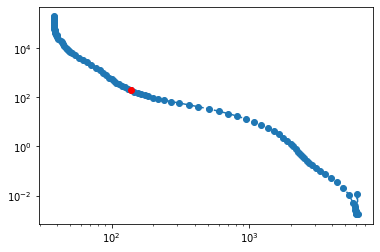

In [17]:
idx = 46
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

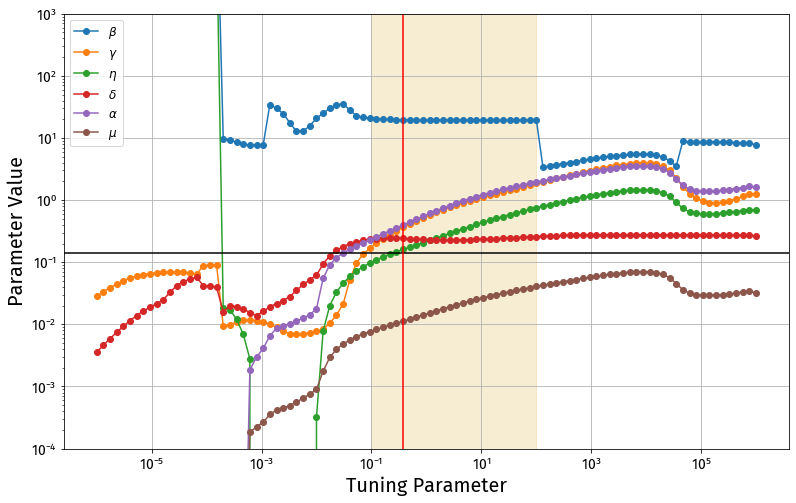

In [18]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
# for q in p0:
#     plt.axhline(q, color='k')
plt.axhline(1/7, color='k', alpha=1)
plt.xscale('log')
plt.xlabel('Tuning Parameter', font_properties=label_font)
plt.ylabel('Parameter Value', font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font)
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend(fontsize='large')
plt.ylim([1e-4, 1e3])
plt.grid(True)
plt.fill([10**-1, 10**2, 10**2, 10**-1],[1e-4, 1e-4, 1e3, 1e3],
        alpha=0.2, color='goldenrod')

34.2457


(0, 30)

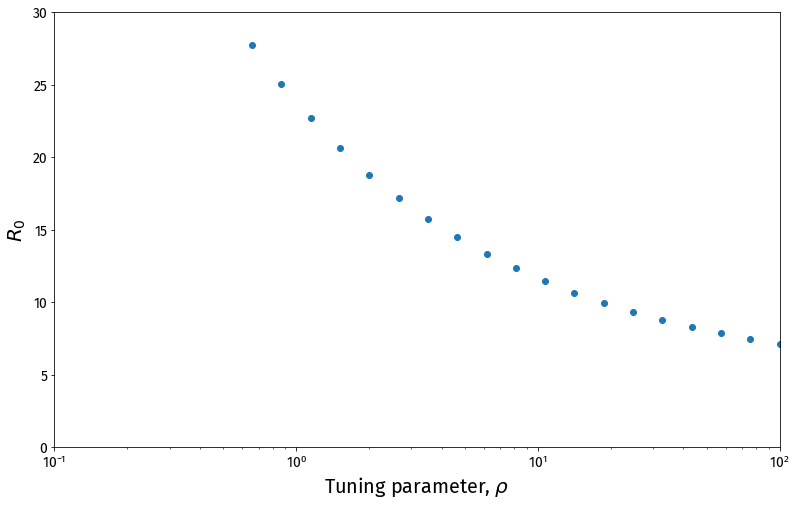

In [19]:
def r0(sol):
    b, g, e, d, a, m = getp(sol['x'])
#     N = sum(x[0] for x in getx(sol['x']))
    return (b)/(e+a+m)
plt.figure(figsize=[13,8], )
plt.plot(prange, [r0(sol) for sol in sols], 'o')
plt.plot(prange[idx], r0(sols[idx]), 'ro')
print(r0(sols[idx]))
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r"Tuning parameter, $\rho$", font_properties=label_font)
plt.ylabel("$R_0$", font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font)
plt.xlim([1e-1, 1e2])
plt.ylim([0,30])

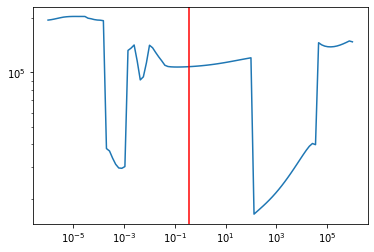

In [20]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])
plt.axvline(prange[idx], color='r')

(DM(19.4992), DM(0.364789), DM(0.16046), DM(0.242946), DM(0.397724), DM(0.0112079))


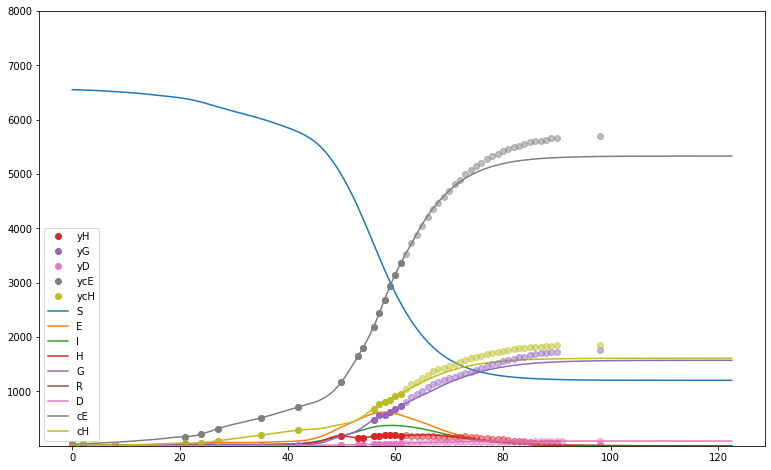

In [21]:
fig, ax=plt.subplots(figsize=[13, 8])
dColours = plt.rcParams['axes.prop_cycle'].by_key()['color']
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time[start:clip], data_dots[start:clip], 'o', color=dColours[clr])
for clr, data_stripe in zip(dColours, getx(sols[idx]['x'])):
    ax.plot(model.observation_times, data_stripe, color=clr)
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time, data_dots, 'o', alpha=0.5, color=dColours[clr])
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 8000])
print(getp(sols[idx]['x']))

In [22]:
print(list(zip("bgedam", getp(sols[idx]['x']))))

[(lbl, yyy[np.argmin(np.abs(model.observation_times-65))]) for lbl, yyy in zip('seihgrdEH', getx(sols[idx]['x'])) ]

[('b', DM(19.4992)), ('g', DM(0.364789)), ('e', DM(0.16046)), ('d', DM(0.242946)), ('a', DM(0.397724)), ('m', DM(0.0112079))]


[('s', DM(1996.79)),
 ('e', DM(423.607)),
 ('i', DM(307.492)),
 ('h', DM(202.658)),
 ('g', DM(940.198)),
 ('r', DM(99570.6)),
 ('d', DM(58.1566)),
 ('E', DM(4113.71)),
 ('H', DM(1182.09))]

88.1958


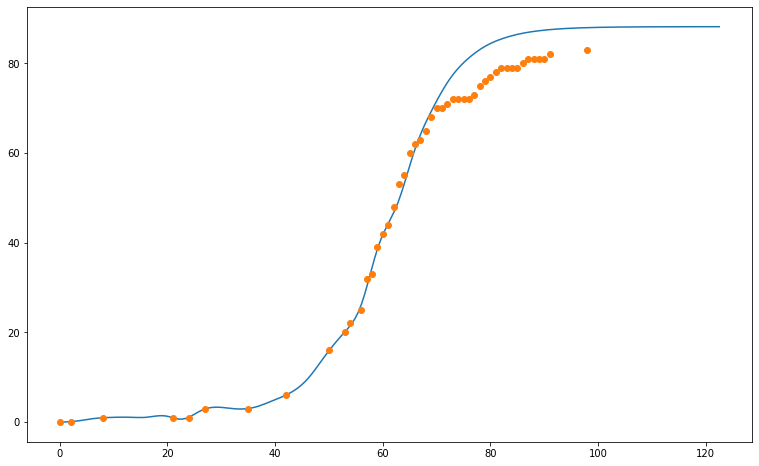

In [23]:
plt.figure(figsize=[13,8])
plt.plot(model.observation_times, getx(sols[idx]['x'])[6])
plt.plot(time, D, 'o')
print(getx(sols[idx]['x'])[6][-1])

(0, 6000)

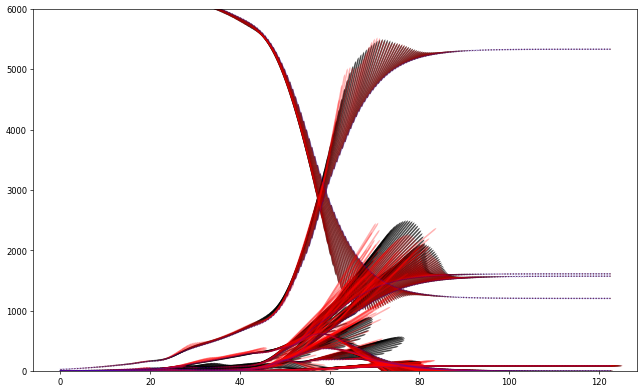

In [24]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
plt.plot(model.observation_times, xx.T, alpha=0.2, color='b')
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.7)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), 
              np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)
plt.ylim([0, 6000])

Text(0.5, 1.0, 'Integral of Discrepancy in derivatives (Fitted - Expected)')

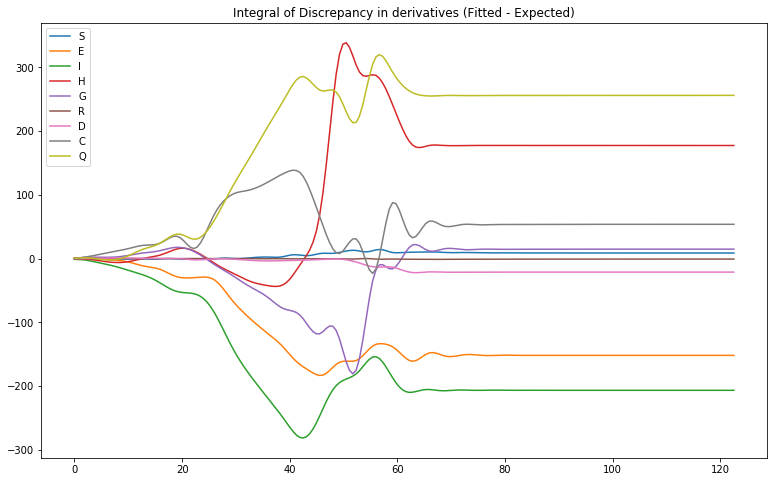

In [25]:
plt.figure(figsize=[13,8])
for i, xxi in enumerate(xx):
    plt.plot(model.observation_times, 
             np.cumsum(np.gradient(xxi, model.observation_times)-dxxdt[:,i]))
# plt.yscale('log')
plt.legend('SEIHGRDCQ')
plt.title('Integral of Discrepancy in derivatives (Fitted - Expected)')

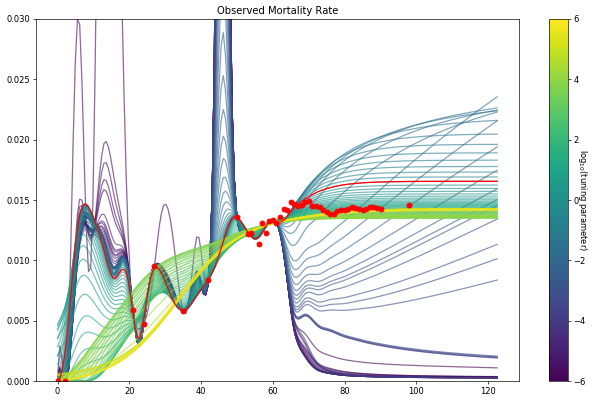

In [26]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
i0, i1 = (0, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[13,8], dpi=60)
for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6]/getx(sols[i+i0]['x'])[-2], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.6)
plt.ylim(0, 0.03)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.title("Observed Mortality Rate")
plt.plot(time, D/cE, 'ro')
plt.plot(model.observation_times, getx(sols[idx]['x'])[6]/getx(sols[idx]['x'])[-2],'r')

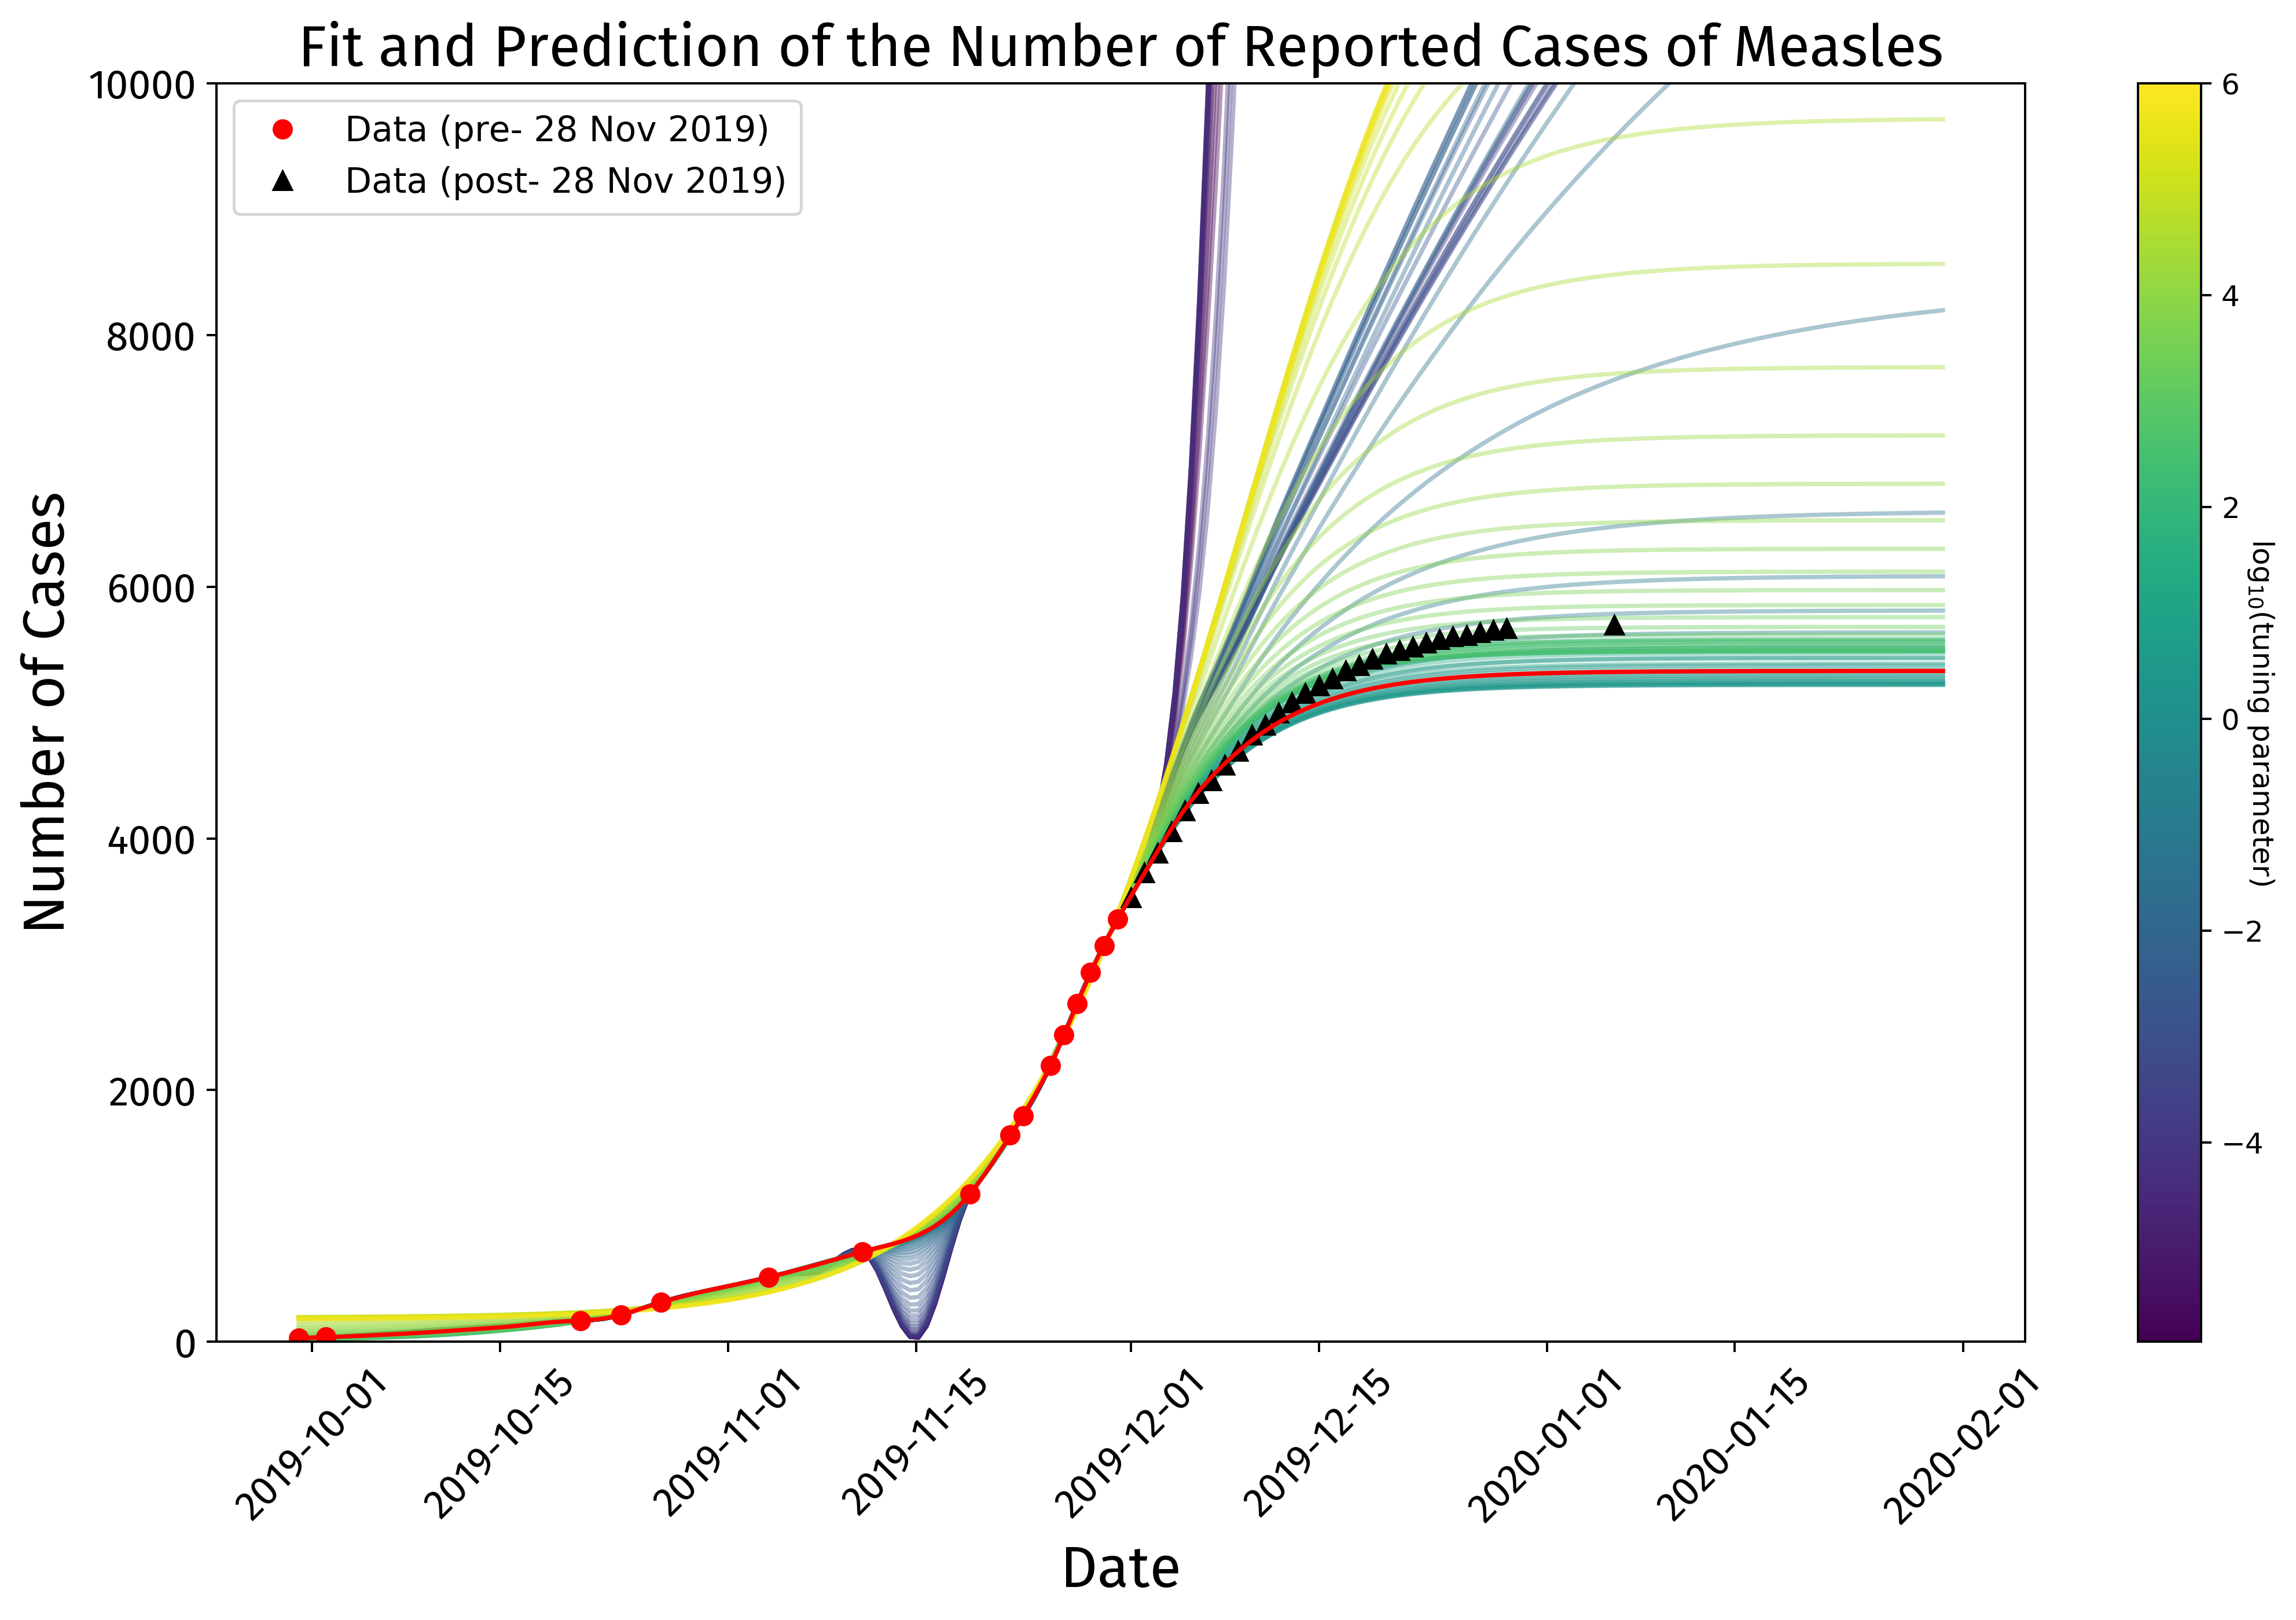

In [27]:
# %matplotlib notebook

plt.figure(figsize=[14,8], dpi=360)

i0, i1 = (1, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[i0:i1:]):
    plt.plot(list(map(time_conv, model.observation_times)), getx(sols[i+i0]['x'])[-2], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(the_dates[start:clip], cE[start:clip], 'ro', label='Data (pre- 28 Nov 2019)')
plt.plot(the_dates[clip:], cE[clip:], 'k^', label='Data (post- 28 Nov 2019)')
plt.title("Fit and Prediction of the Number of Reported Cases of Measles", 
          font_properties=label_font)
plt.xlabel("Date", font_properties=label_font)
plt.ylabel("Number of Cases", font_properties=label_font)
plt.xticks(rotation=45, font_properties=tick_font)
plt.yticks(font_properties=tick_font)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend(fontsize='large')
plt.ylim([0,10000])

plt.plot(list(map(time_conv, model.observation_times)), getx(sols[idx]['x'])[-2], color='r')

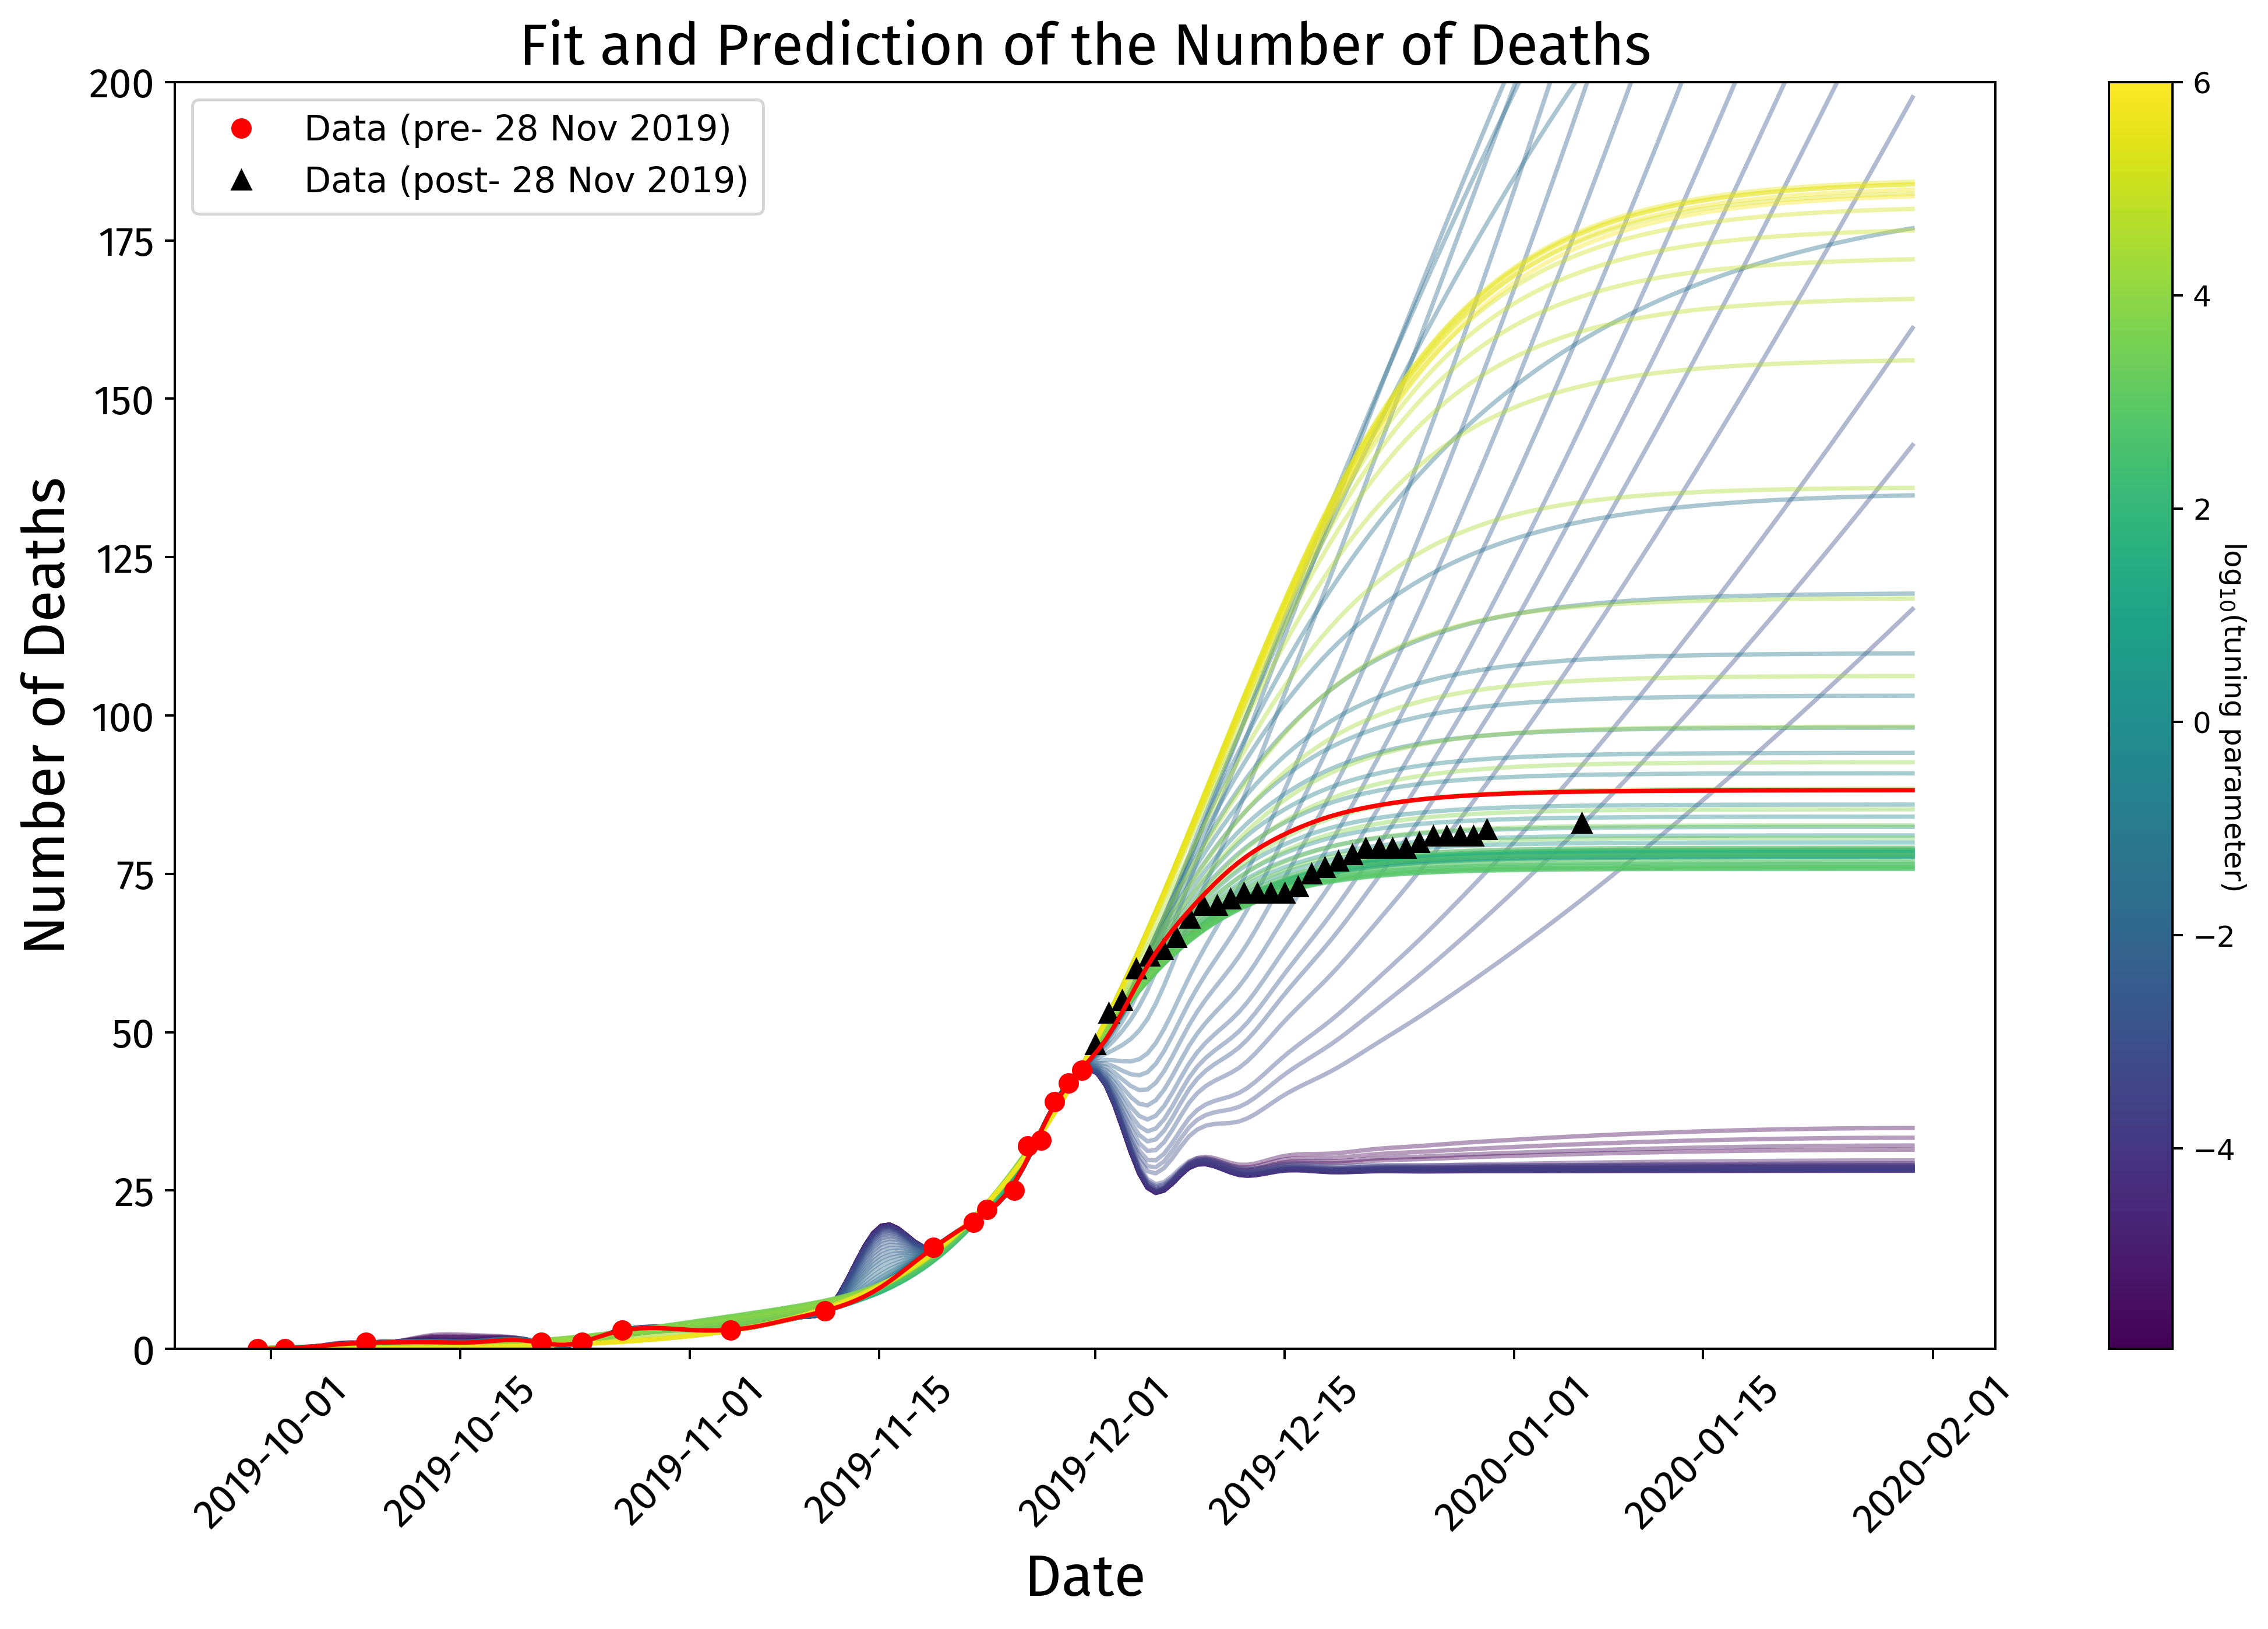

In [28]:
plt.figure(figsize=[14,8], dpi=360)

i0, i1 = (1, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(list(map(time_conv, model.observation_times)), getx(sols[i+i0]['x'])[6], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(the_dates[start:clip], D[start:clip], 'ro', label='Data (pre- 28 Nov 2019)')
plt.plot(the_dates[clip:], D[clip:], 'k^', label='Data (post- 28 Nov 2019)')
plt.title("Fit and Prediction of the Number of Deaths", font_properties=label_font)
plt.xlabel("Date", font_properties=label_font)
plt.ylabel("Number of Deaths", font_properties=label_font)
plt.xticks(rotation=45, font_properties=tick_font)
plt.yticks(font_properties=tick_font)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend(fontsize='large')
plt.ylim([0, 200])

plt.plot(list(map(time_conv, model.observation_times)), getx(sols[idx]['x'])[6], color='r')

array([5487.78491823, 5487.78491823])

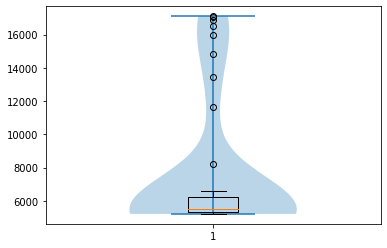

In [29]:
plt.violinplot([getx(s['x'])[-2][-1] for s in sols[30:-30]])
bx=plt.boxplot([getx(s['x'])[-2][-1] for s in sols[30:-30]])
bx['medians'][0].get_ydata()
# plt.yscale('log')

In [30]:
np.min([getx(sols[i]['x'])[-2][-1] for i in range(100)])

5218.791952846286

In [31]:
np.unique(bx['boxes'][0].get_ydata())

array([5306.15825719, 6209.09870011])

(0, 10000)

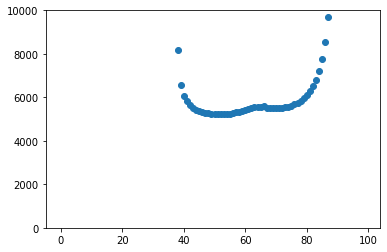

In [32]:
plt.plot([getx(s['x'])[-2][-1] for s in sols],'o')
# cumul reports
plt.ylim([0,10000])

(0, 100)

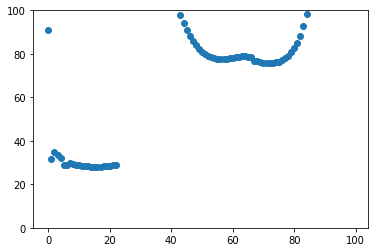

In [33]:
plt.plot([getx(sols[i]['x'])[6][-1] for i in range(100)],'o')
plt.ylim([0, 100])

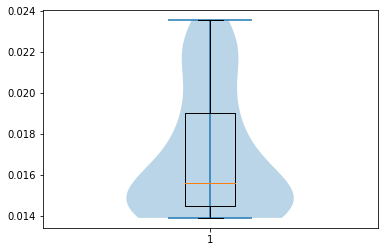

In [34]:
plt.violinplot([(getx(s['x'])[6]/getx(s['x'])[-2])[-1] for s in sols[30:-30]])
bx = plt.boxplot([(getx(s['x'])[6]/getx(s['x'])[-2])[-1] for s in sols[30:-30]])


In [35]:
np.unique(bx['boxes'][0].get_ydata())

array([0.01445975, 0.0190225 ])

In [36]:
morts = [getx(s['x'])[6][-1] for s in sols[30:-30]]
print(np.min(morts))
print(np.median(morts))

76.26511775271
81.74159802654333


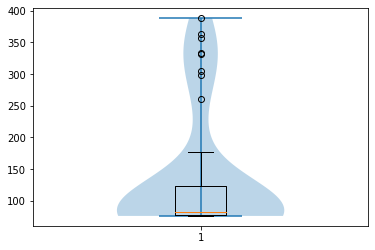

In [37]:
plt.violinplot(morts)
bx = plt.boxplot(morts)


In [38]:
np.unique(bx['boxes'][0].get_ydata())

array([ 78.3904815, 123.1217895])

In [39]:
from scipy import interpolate

print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-2].toarray().flatten())(data_time[-1]+1))
print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-3].toarray().flatten())(data_time[-1]+1))

3541.095765129437
46.65833541997346


In [40]:
pref = sols[idx]['x']
bprofile = []
brange = np.linspace(0,30,num=61)
for b in brange:
    lbxp = copy(lbx)
    lbxp[-6] = b
    ubxp = [np.inf]*len(lbxp)
    ubxp[-6] = b
    psolve_opts = {
        'x0': pref,
        'p': [prange[idx], alpha],
        'lbx': lbxp,
        'ubx': ubxp,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f'b={b}')
    bprofile.append(solver(**psolve_opts))

b=0.0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7022

Total number of variables............................:      365
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls



Number of Iterations....: 594

                                   (scaled)                 (unscaled)
Objective...............:   1.9215554763119005e+00    2.2185106159666151e+02
Dual infeasibility......:   7.6486888057257157e-11    8.8307090390624808e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059042662098787e-09    2.8931640463760763e-07
Overall NLP error.......:   2.5059042662098787e-09    2.8931640463760763e-07


Number of objective function evaluations             = 1173
Number of objective gradient evaluations             = 595
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1173
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 595
Number of Lagrangian Hessian evaluations             = 594
Total CPU secs in IPOPT (w/o function evaluations)   =      4.727
Total CPU secs in NLP function ev

 300  2.3736925e+02 0.00e+00 2.92e+00  -5.7 9.44e+02 -10.7 1.00e+00 1.00e+00f  1
 350  2.2137104e+02 0.00e+00 2.23e-03  -5.7 1.11e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 358

                                   (scaled)                 (unscaled)
Objective...............:   2.0864742929286790e+00    2.2135899628839908e+02
Dual infeasibility......:   2.1693774167058619e-09    2.3015438491632760e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6525379983775467e-09    2.8141403463616198e-07
Overall NLP error.......:   2.6525379983775467e-09    2.8141403463616198e-07


Number of objective function evaluations             = 621
Number of objective gradient evaluations             = 359
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 621
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 35

 250  2.5480003e+02 0.00e+00 4.12e+01  -5.7 3.19e+02  -9.9 1.00e+00 1.00e+00f  1
 300  2.3725932e+02 0.00e+00 1.59e-01  -5.7 9.50e+01  -9.2 1.00e+00 1.00e+00f  1
 350  2.2696027e+02 0.00e+00 3.37e+00  -5.7 1.65e+03    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 382

                                   (scaled)                 (unscaled)
Objective...............:   2.2881909373137161e+00    2.2133863196533059e+02
Dual infeasibility......:   1.5648876622600070e-09    1.5137289843070738e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6623575711963576e-09    2.5753208484557075e-07
Overall NLP error.......:   2.6623575711963576e-09    2.5753208484557075e-07


Number of objective function evaluations             = 739
Number of objective gradient evaluations             = 383
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 739
Number of equality constraint Jac

   0  2.6244573e+03 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  3.0361977e+02 0.00e+00 1.41e+00  -2.5 3.79e+01  -7.5 1.00e+00 1.00e+00f  1
 100  3.0339423e+02 0.00e+00 4.32e-01  -2.5 2.52e+01  -8.8 1.00e+00 1.00e+00f  1
 150  2.6061345e+02 0.00e+00 1.73e+01  -3.8 1.75e+03    -  1.00e+00 2.50e-01f  3
 200  2.5652589e+02 0.00e+00 4.64e+01  -5.7 6.95e+02 -10.6 1.00e+00 5.00e-01f  2
 250  2.4159163e+02 0.00e+00 1.14e+01  -5.7 2.97e+02  -9.9 1.00e+00 1.00e+00f  1
 300  2.3227521e+02 0.00e+00 9.15e-02  -5.7 2.37e+01  -8.4 1.00e+00 1.00e+00f  1
 350  2.2133856e+02 0.00e+00 1.29e-08  -5.7 8.33e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 356

                                   (scaled)                 (unscaled)
Objective...............:   2.5332646008911723e+00    2.2132958913688890e+02
Dual infeasibility......:   1.3212008011572052e-09    1.1543240701527290e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

Total number of variables............................:      365
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1370589e+03 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  3.8660909e+02 0.00e+00 4.24e+01  -2.5 3.06e+02  -8.8 1.00e+00 1.00e+00f  1
 100  2.6046851e+02 0.00e+00 4.00e+01  -3.8 6.01e+02 -11.9 1.00e+00 1.00e+00f  1
 150  2.5667342e+02 0.00e+00 4.14e+00  -3.8 6.47e+03    -  1.00e+00 1.25e-01f  4
 200  2.5195330e+0

Total number of variables............................:      365
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7048409e+03 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  7.9356408e+02 0.00e+00 2.84e+02  -1.7 4.56e+02  -8.3 1.00e+00 1.00e+00f  1
 100  2.6062149e+02 0.00e+00 1.39e+02  -3.8 3.35e+03 -10.7 1.00e+00 2.50e-01f  3
 150  2.5576524e+02 0.00e+00 4.16e+01  -3.8 1.80e+03 -11.4 1.00e+00 2.50e-01f  3
 200  2.4908406e+0

  50  8.5122338e+02 0.00e+00 1.91e+03  -2.5 4.53e+03    -  7.52e-01 1.00e+00f  1
 100  2.6010953e+02 0.00e+00 7.68e+00  -3.8 2.98e+02 -11.2 1.00e+00 1.00e+00f  1
 150  2.5429742e+02 0.00e+00 3.39e+01  -3.8 1.41e+03 -11.9 1.00e+00 5.00e-01f  2
 200  2.4497322e+02 0.00e+00 2.85e+01  -3.8 1.85e+03    -  1.00e+00 2.50e-01f  3
 250  2.4043225e+02 0.00e+00 1.80e-01  -3.8 3.23e+01  -9.5 1.00e+00 1.00e+00f  1
 300  2.3763638e+02 0.00e+00 1.23e+01  -3.8 1.22e+04    -  5.52e-01 1.63e-02f  5
 350  2.3329372e+02 0.00e+00 2.68e+00  -3.8 8.18e+01  -9.0 1.00e+00 1.00e+00f  1
 400  2.2132440e+02 0.00e+00 7.56e-02  -5.7 5.28e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 408

                                   (scaled)                 (unscaled)
Objective...............:   3.7331514897821143e+00    2.2131889076973658e+02
Dual infeasibility......:   8.8034801258853785e-10    5.2191197215200341e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

 200  2.4630520e+02 0.00e+00 1.18e+01  -3.8 3.42e+03 -12.0 1.00e+00 5.00e-01f  2
 250  2.4034703e+02 0.00e+00 7.13e+01  -3.8 2.59e+04    -  6.95e-01 2.26e-02f  5
 300  2.3759711e+02 0.00e+00 6.57e+00  -3.8 1.45e+03    -  1.00e+00 1.00e+00f  1
 350  2.3346226e+02 0.00e+00 1.13e+01  -3.8 5.17e+03    -  1.00e+00 9.14e-02f  4
 400  2.2260025e+02 0.00e+00 1.54e-02  -3.8 2.41e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 413

                                   (scaled)                 (unscaled)
Objective...............:   4.4331527221557927e+00    2.2131719958630106e+02
Dual infeasibility......:   7.0419277888059199e-10    3.5155561641684172e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7500810992749766e-09    1.3729286710221417e-07
Overall NLP error.......:   2.7500810992749766e-09    1.3729286710221417e-07


Number of objective function evaluations             = 830
Number of objective gradient evaluations      

 100  2.7646084e+02 0.00e+00 4.99e-04  -2.5 1.04e+00    -  1.00e+00 1.00e+00h  1
 150  2.5308001e+02 0.00e+00 2.16e+02  -3.8 6.96e+02 -11.2 1.00e+00 1.00e+00f  1
 200  2.4408309e+02 0.00e+00 5.85e+01  -3.8 1.32e+03 -11.8 1.00e+00 5.00e-01f  2
 250  2.4000129e+02 0.00e+00 4.38e+00  -3.8 1.78e+02 -10.2 1.00e+00 1.00e+00f  1
 300  2.3701572e+02 0.00e+00 1.03e-01  -3.8 1.58e+01  -8.7 1.00e+00 1.00e+00f  1
 350  2.3303835e+02 0.00e+00 1.23e+01  -3.8 6.44e+02  -8.7 1.00e+00 1.25e-01f  4
 400  2.2167038e+02 0.00e+00 3.60e+00  -5.7 2.96e+03    -  9.21e-01 1.00e+00f  1

Number of Iterations....: 411

                                   (scaled)                 (unscaled)
Objective...............:   5.4562804451841638e+00    2.2131590123910448e+02
Dual infeasibility......:   5.0884383225064675e-10    2.0639560677990499e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7719472819684996e-09    1.1243483854236493e-07
Overall NLP error.....

 300  2.3659115e+02 0.00e+00 3.43e+00  -3.8 3.20e+02 -10.3 1.00e+00 5.00e-01f  2
 350  2.3098276e+02 0.00e+00 4.82e+00  -3.8 7.66e+01  -8.4 1.00e+00 1.00e+00f  1
 400  2.2131487e+02 0.00e+00 2.89e-10  -8.6 7.63e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 400

                                   (scaled)                 (unscaled)
Objective...............:   7.0933905752825908e+00    2.2131487307821180e+02
Dual infeasibility......:   2.8938424004532986e-10    9.0288326402942347e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7876012370572205e-09    8.6973585822518608e-08
Overall NLP error.......:   2.7876012370572205e-09    8.6973585822518608e-08


Number of objective function evaluations             = 797
Number of objective gradient evaluations             = 401
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 797
Number of equality constraint Jac

 250  2.3935987e+02 0.00e+00 6.53e-02  -3.8 1.34e+01  -8.7 1.00e+00 1.00e+00f  1
 300  2.3745661e+02 0.00e+00 1.62e-01  -3.8 3.30e+01  -8.8 1.00e+00 1.00e+00f  1
 350  2.3409627e+02 0.00e+00 3.50e+00  -3.8 6.35e+01  -8.4 1.00e+00 1.00e+00f  1
 400  2.2416644e+02 0.00e+00 1.92e+01  -3.8 6.29e+03    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 426

                                   (scaled)                 (unscaled)
Objective...............:   1.0134063981342262e+01    2.2131403872125830e+02
Dual infeasibility......:   6.4865437648934165e-09    1.4165720688104607e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.0441882967187566e-09    8.8319517909489909e-08
Overall NLP error.......:   6.4865437648934165e-09    1.4165720688104607e-07


Number of objective function evaluations             = 856
Number of objective gradient evaluations             = 427
Number of equality constraint evaluations            = 0
Number of i

 150  2.5413027e+02 0.00e+00 2.54e+01  -3.8 3.87e+02 -10.0 9.42e-01 1.00e+00f  1
 200  2.4459493e+02 0.00e+00 1.78e+02  -3.8 1.17e+03 -10.4 1.00e+00 2.50e-01f  3
 250  2.3925993e+02 0.00e+00 2.62e+02  -3.8 2.30e+03    -  1.00e+00 2.50e-01f  3
 300  2.3716046e+02 0.00e+00 1.53e+02  -3.8 7.85e+03    -  1.00e+00 5.49e-02f  5
 350  2.3299107e+02 0.00e+00 5.49e+01  -3.8 9.93e+03    -  6.67e-01 5.33e-02f  4
 400  2.2168949e+02 0.00e+00 6.68e-01  -3.8 1.12e+01  -8.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 417

                                   (scaled)                 (unscaled)
Objective...............:   1.7737563287008104e+01    2.2131334805564694e+02
Dual infeasibility......:   2.8987343510716097e-09    3.6167797908828846e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.2878121670422257e-09    5.3499460504640640e-08
Overall NLP error.......:   4.2878121670422257e-09    5.3499460504640640e-08


Number of objective func

 250  2.4100071e+02 0.00e+00 4.91e+02  -2.5 1.46e+03    -  1.00e+00 2.50e-01f  3
 300  2.3856860e+02 0.00e+00 2.22e+02  -2.5 1.69e+03    -  1.00e+00 5.00e-01f  2
 350  2.3504049e+02 0.00e+00 3.18e+02  -2.5 6.53e+03    -  1.00e+00 9.28e-02f  4
 400  2.2642541e+02 0.00e+00 1.71e+02  -2.5 4.32e+03    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 438

                                   (scaled)                 (unscaled)
Objective...............:   7.1034367553277605e+01    2.2131276690579298e+02
Dual infeasibility......:   9.0775175702811430e-09    2.8281669835493240e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.3576036575216928e-09    7.3452866082323340e-09
Overall NLP error.......:   9.0775175702811430e-09    2.8281669835493240e-08


Number of objective function evaluations             = 1003
Number of objective gradient evaluations             = 439
Number of equality constraint evaluations            = 0
Number of 

 300  2.3768829e+02 0.00e+00 4.97e+02  -3.8 2.98e+03    -  1.00e+00 5.00e-01f  2
 350  2.3473619e+02 0.00e+00 4.13e-01  -3.8 1.53e+01  -7.2 1.00e+00 1.00e+00f  1
 400  2.2455867e+02 0.00e+00 1.72e+01  -3.8 4.62e+01  -7.5 1.00e+00 1.00e+00f  1

Number of Iterations....: 429

                                   (scaled)                 (unscaled)
Objective...............:   3.5436031656987417e+01    2.2133180874945671e+02
Dual infeasibility......:   1.7171150881445365e-09    1.0725021130154477e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.1669270728194572e-09    3.2272386642316522e-08
Overall NLP error.......:   5.1669270728194572e-09    3.2272386642316522e-08


Number of objective function evaluations             = 866
Number of objective gradient evaluations             = 430
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 866
Number of equality constraint Jac

 150  2.4940546e+02 0.00e+00 1.04e+01  -3.8 8.48e+02 -10.7 1.00e+00 1.00e+00f  1
 200  2.4259367e+02 0.00e+00 1.87e+02  -3.8 2.84e+03 -11.4 1.00e+00 2.50e-01f  3
 250  2.4004797e+02 0.00e+00 1.18e+01  -3.8 1.63e+02  -9.7 1.00e+00 1.00e+00f  1
 300  2.3830820e+02 0.00e+00 7.16e+00  -3.8 1.14e+02  -9.4 1.00e+00 1.00e+00f  1
 350  2.3562821e+02 0.00e+00 2.47e-01  -3.8 1.52e+01  -8.0 1.00e+00 1.00e+00f  1
 400  2.2974496e+02 0.00e+00 6.97e+01  -3.8 6.02e+03    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 445

                                   (scaled)                 (unscaled)
Objective...............:   1.4187129884137148e+01    2.2142535001675196e+02
Dual infeasibility......:   2.0525172089748073e-10    3.2034621880836798e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8255574373368094e-09    4.4099832007197507e-08
Overall NLP error.......:   2.8255574373368094e-09    4.4099832007197507e-08


Number of objective func

   nlp_jac_g  |  22.15ms ( 51.40us)  22.28ms ( 51.69us)       431
       total  |   3.91 s (  3.91 s)   3.91 s (  3.91 s)         1
b=23.5
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7022

Total number of variables............................:      365
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequ

 350  2.3668602e+02 0.00e+00 2.09e+00  -3.8 2.48e+03    -  1.00e+00 5.00e-01f  2
 400  2.3171881e+02 0.00e+00 4.54e-01  -3.8 2.82e+01  -8.0 1.00e+00 1.00e+00f  1
 450  2.2172094e+02 0.00e+00 1.60e-06  -8.6 4.71e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 452

                                   (scaled)                 (unscaled)
Objective...............:   7.1041575858086468e+00    2.2172093446792636e+02
Dual infeasibility......:   1.7994863195568125e-09    5.6162012668666159e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8409195859561801e-09    8.8665170745186938e-08
Overall NLP error.......:   2.8409195859561801e-09    8.8665170745186938e-08


Number of objective function evaluations             = 911
Number of objective gradient evaluations             = 453
Number of equality constraint evaluations            = 0
Number of i

 150  2.5181119e+02 0.00e+00 2.89e+02  -3.8 1.04e+03 -11.5 1.00e+00 1.00e+00f  1
 200  2.4432509e+02 0.00e+00 4.24e+01  -3.8 1.51e+02  -9.6 1.00e+00 1.00e+00f  1
 250  2.4076952e+02 0.00e+00 2.56e+01  -3.8 4.31e+02 -11.4 1.00e+00 1.00e+00f  1
 300  2.3826035e+02 0.00e+00 3.12e-02  -3.8 5.81e+00  -8.6 1.00e+00 1.00e+00f  1
 350  2.3547493e+02 0.00e+00 3.01e-02  -3.8 8.83e+00  -8.1 1.00e+00 1.00e+00f  1
 400  2.2961454e+02 0.00e+00 1.04e+01  -3.8 1.11e+02  -8.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 447

                                   (scaled)                 (unscaled)
Objective...............:   5.4709360366727209e+00    2.2196436324199098e+02
Dual infeasibility......:   2.1623888022673298e-09    8.7731468684614059e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7938496714947243e-09    1.1335081586958599e-07
Overall NLP error.......:   2.7938496714947243e-09    1.1335081586958599e-07


Number of objective func

 150  2.5031452e+02 0.00e+00 9.43e+01  -3.8 1.85e+03 -11.8 1.00e+00 2.50e-01f  3
 200  2.4348157e+02 0.00e+00 2.12e+02  -3.8 2.87e+03 -12.0 1.00e+00 5.00e-01f  2
 250  2.4077009e+02 0.00e+00 6.19e+01  -3.8 5.68e+02    -  1.00e+00 1.00e+00f  1
 300  2.3894651e+02 0.00e+00 2.31e+01  -3.8 2.05e+02 -10.2 1.00e+00 2.50e-01f  3
 350  2.3546855e+02 0.00e+00 2.56e+01  -3.8 2.58e+02    -  1.00e+00 1.00e+00f  1
 400  2.2885113e+02 0.00e+00 5.98e+00  -3.8 1.94e+04    -  6.50e-01 6.49e-02f  4

Number of Iterations....: 444

                                   (scaled)                 (unscaled)
Objective...............:   4.4508894081321957e+00    2.2224660898109025e+02
Dual infeasibility......:   2.1143310284004154e-09    1.0557505663181308e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7440413085893992e-09    1.3701842931072759e-07
Overall NLP error.......:   2.7440413085893992e-09    1.3701842931072759e-07


Number of objective func

 150  2.4908495e+02 0.00e+00 8.35e+01  -3.8 1.41e+03 -11.4 1.00e+00 2.50e-01f  3
 200  2.4343678e+02 0.00e+00 2.20e+00  -3.8 2.60e+02 -11.6 1.00e+00 1.00e+00f  1
 250  2.4111917e+02 0.00e+00 4.45e+00  -3.8 1.72e+02    -  1.00e+00 1.00e+00h  1
 300  2.3876107e+02 0.00e+00 1.15e+00  -5.7 7.87e+01  -9.6 1.00e+00 1.00e+00f  1
 350  2.3521631e+02 0.00e+00 4.71e+00  -5.7 6.29e+03    -  1.00e+00 5.00e-01f  2
 400  2.2478147e+02 0.00e+00 2.09e+00  -5.7 1.11e+05    -  3.08e-01 1.97e-02f  3

Number of Iterations....: 423

                                   (scaled)                 (unscaled)
Objective...............:   3.7534701480129851e+00    2.2256052955515906e+02
Dual infeasibility......:   1.7896359218227637e-09    1.0611575495882474e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6989239435950988e-09    1.6003162898034734e-07
Overall NLP error.......:   2.6989239435950988e-09    1.6003162898034734e-07


Number of objective func

In [41]:
ffff = ca.Function('getobj', [solver_setup['x'], objective.rho, objective.alpha], [objective.objective])
minf = ffff(sols[idx]['x'], prange[idx], alpha)

alsominf = min([s['f']-fr_ex(s['x']) for s in bprofile])

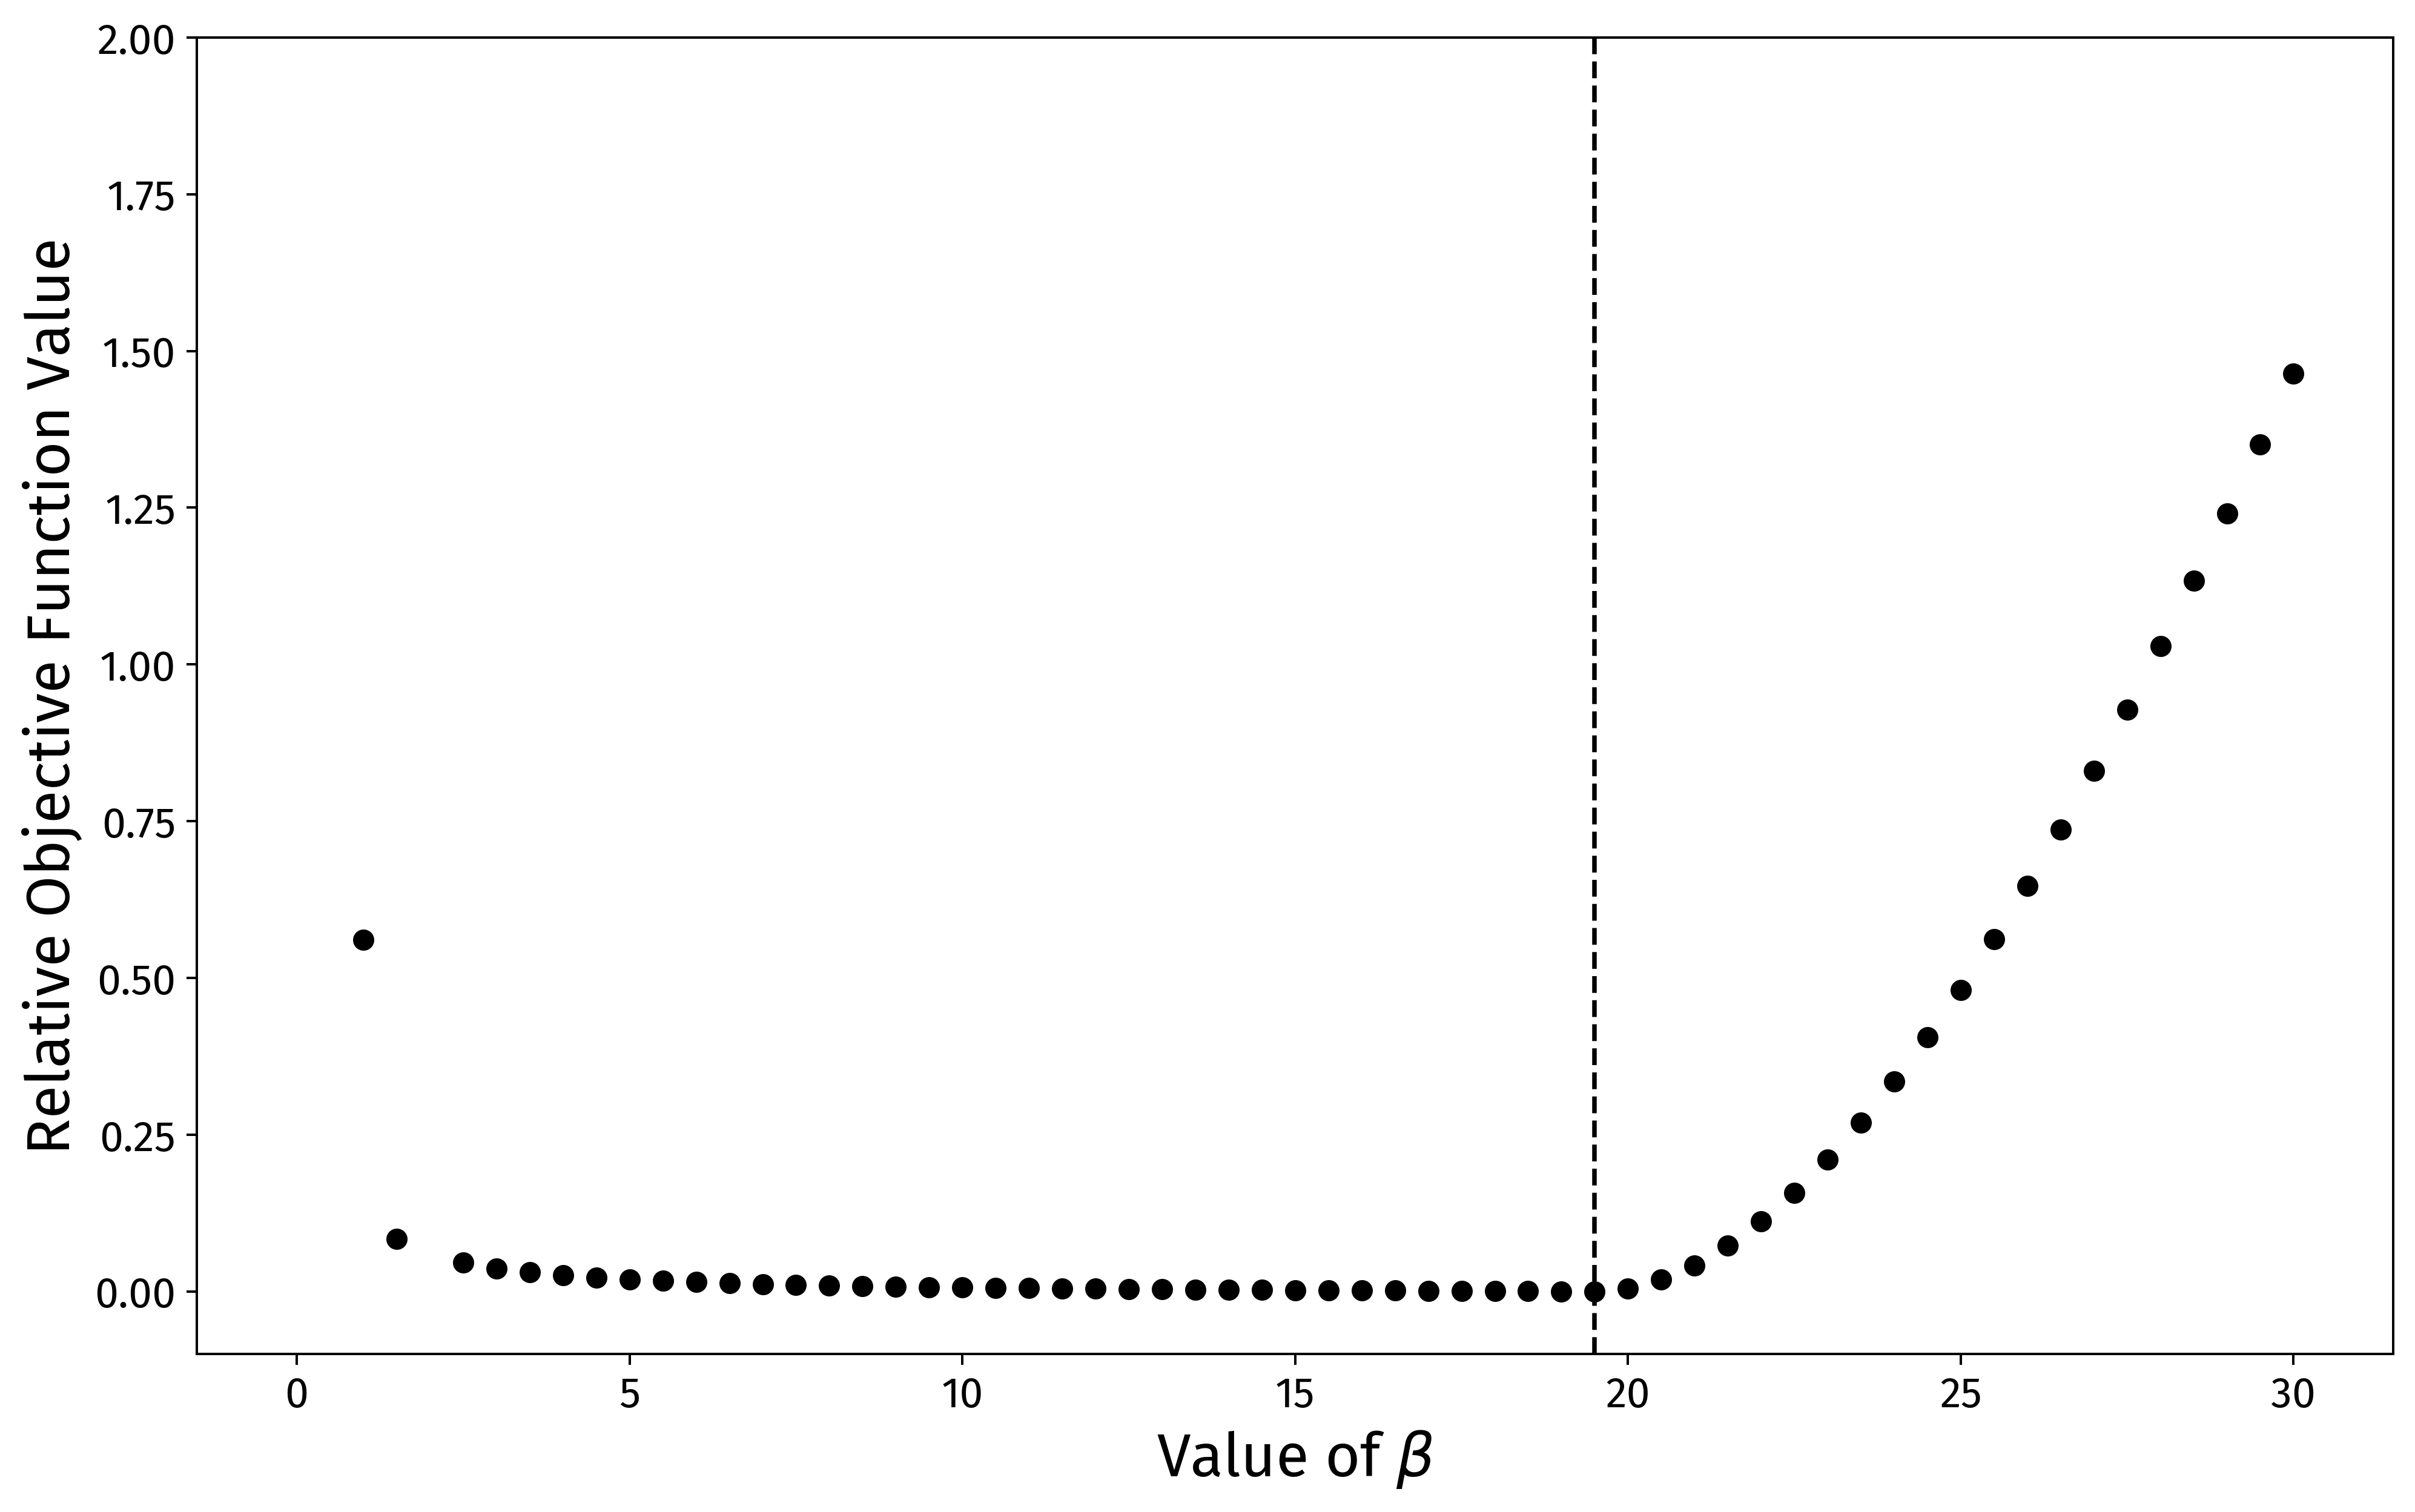

In [42]:
plt.figure(figsize=[13,8], dpi=360)
plt.plot(brange, [s['f']-alsominf -fr_ex(s['x']) for s in bprofile], 'o', color='k',)
plt.axvline(float(getp(sols[idx]['x'])[0]), linestyle='--', color='k')
plt.ylim([-0.1, 2])
# plt.xlim([0.0001, 0.00025])
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Relative Objective Function Value', font_properties=label_font)
plt.xlabel('Value of $\\beta$', font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font);

Text(0.5, 1.0, 'b/N by b')

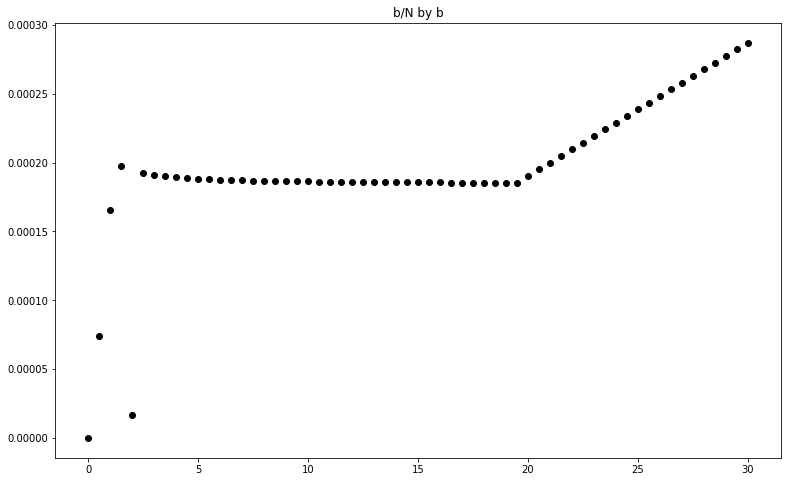

In [43]:
plt.figure(figsize=[13,8],)
N0 = lambda sol: sum(x[0] for x in getx(sol['x']))
plt.plot(brange,
        [b/N0(sol) for b, sol in zip(brange, bprofile)], 
#           [s['f']-alsominf -fr_ex(s['x']) for s in bprofile], 
         'o', color='k',)
# plt.axvline(float(getp(sols[idx]['x'])[0]), linestyle='--', color='k')
plt.title('b/N by b')

Text(0.5, 1.0, 'R0 by b')

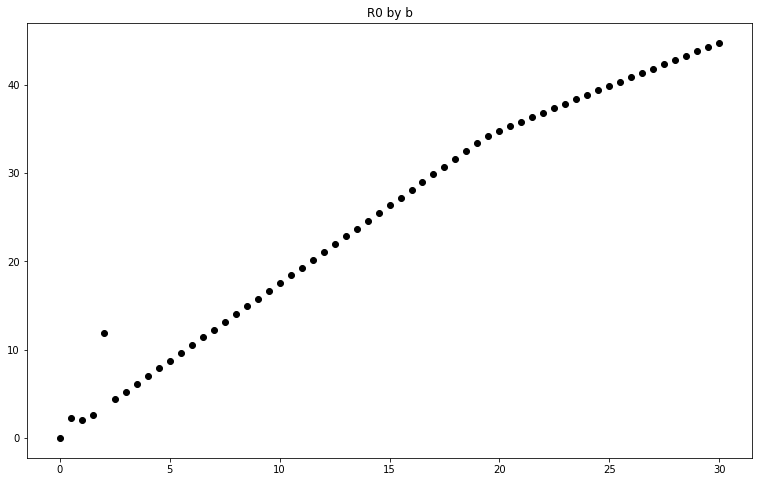

In [44]:
plt.figure(figsize=[13,8],)

plt.plot(brange,
        [r0(sol) for sol in bprofile], 
         'o', color='k',)
# plt.axvline(float(getp(sols[idx]['x'])[0]), linestyle='--', color='k')
plt.title('R0 by b')

In [45]:
def r0_err(lb, ub, idx=idx):
    _,_,e,_,a,m = getp(sols[idx]['x'])
    return np.abs(ub-lb)/(e+a+m)
print(r0_err(3, 18))
print(r0(sols[idx]))
print(f"This means that our estimate of $R_0$ is approximately {r0(sols[idx])} ($\pm$ {0.5*r0_err(2, 28)})${{}}_\\beta$")

26.3439
34.2457
This means that our estimate of $R_0$ is approximately 34.2457 ($\pm$ 22.8314)${}_\beta$


Text(0.5, 1.0, 'Parameter Estimate Error and Predictive Error')

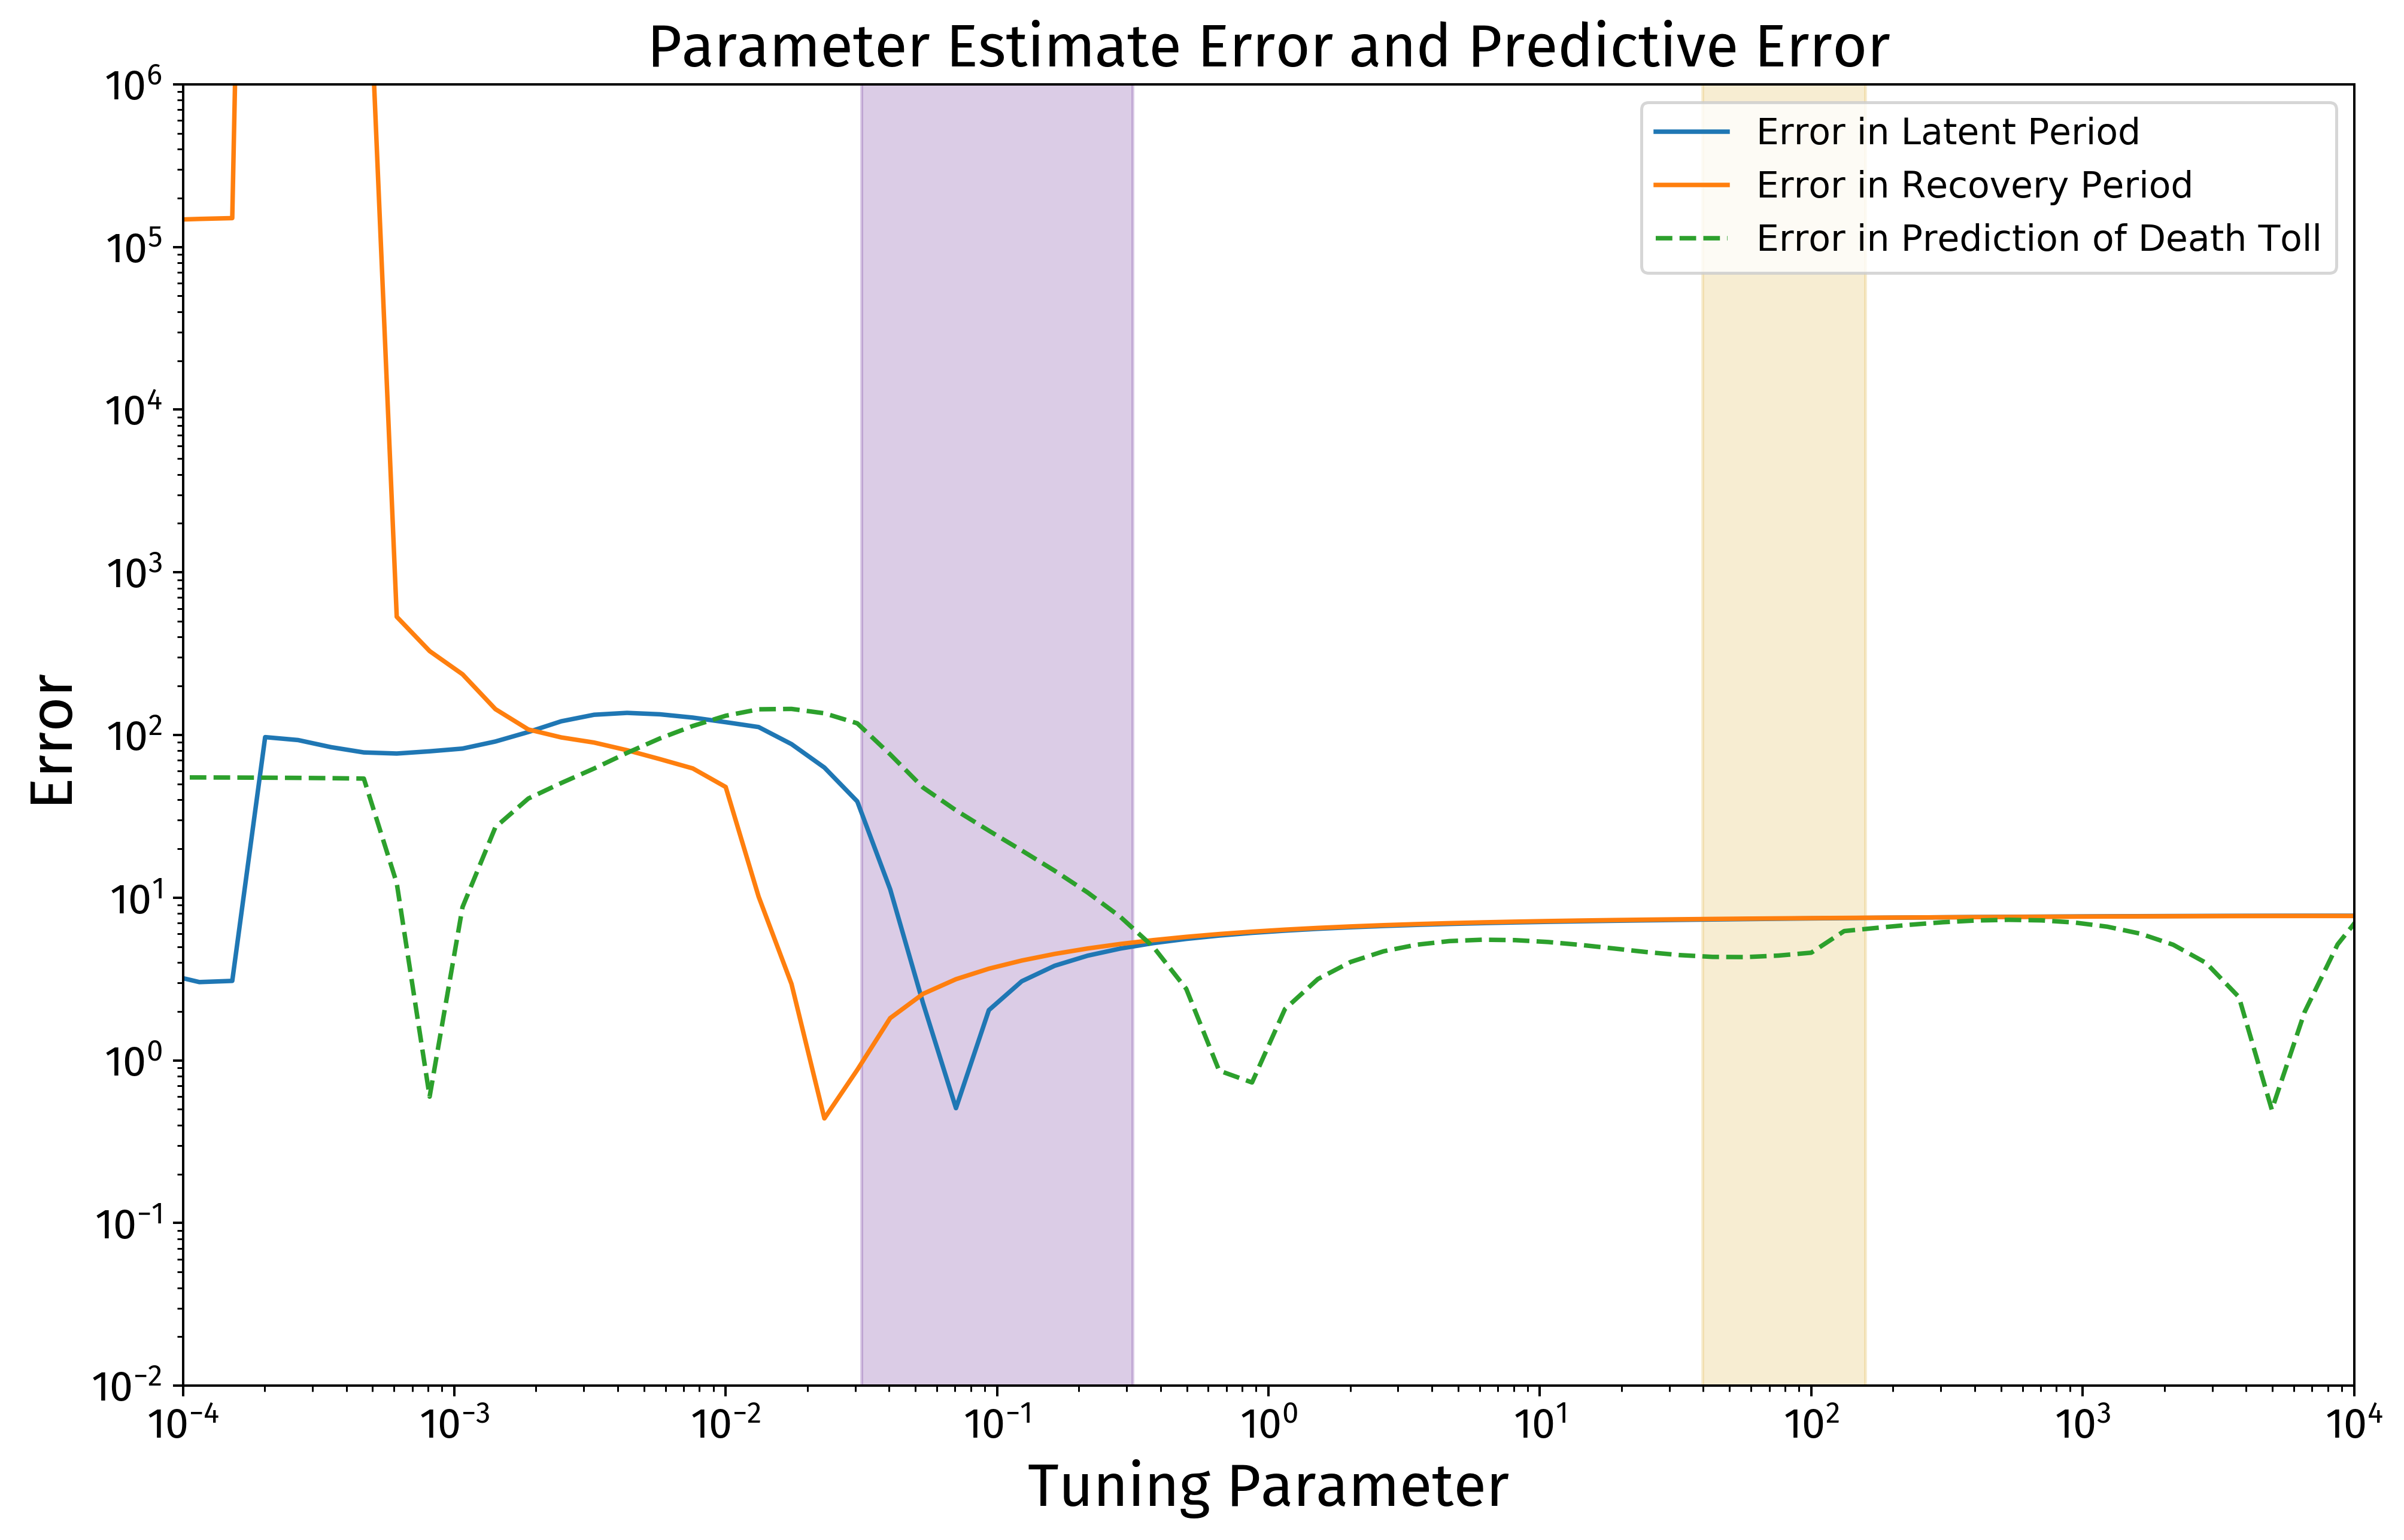

In [46]:
gamma_errs = [np.abs(1/(float(s['x'][-5])+1e-15) - 8) for s in sols]
alpha_errs = [np.abs(1/(float(s['x'][-2])+1e-15) - 8) for s in sols]

eerr = [np.abs(float(getx(s['x'])[-2][159]) - cE[-1]) for s in sols]
derr = [np.abs(float(getx(s['x'])[6][159]) - D[-1]) for s in sols]

plt.figure(figsize=[13,8], dpi=360)
plt.plot(prange, gamma_errs, '-', label="Error in Latent Period")
plt.plot(prange, alpha_errs, '-', label='Error in Recovery Period')
# plt.plot(prange, eerr)
plt.plot(prange, derr, '--', label="Error in Prediction of Death Toll")

plt.fill([10**-1.5, 10**-0.5, 10**-0.5, 10**-1.5],[0, 0, 10**7, 10**7], 
         alpha=0.2, color='indigo')
plt.fill([10**1.6, 10**2.2, 10**2.2, 10**1.6],[0, 0, 10**7, 10**7],
        alpha=0.2, color='goldenrod')

plt.legend(fontsize='large')
plt.ylim([0.01, 1e6])
plt.xlim([1e-4, 1e4])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Tuning Parameter', font_properties=label_font)
plt.ylabel('Error', font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font)
plt.title("Parameter Estimate Error and Predictive Error", font_properties=label_font)



Text(1e-05, 8545.5, 'True Final Size')

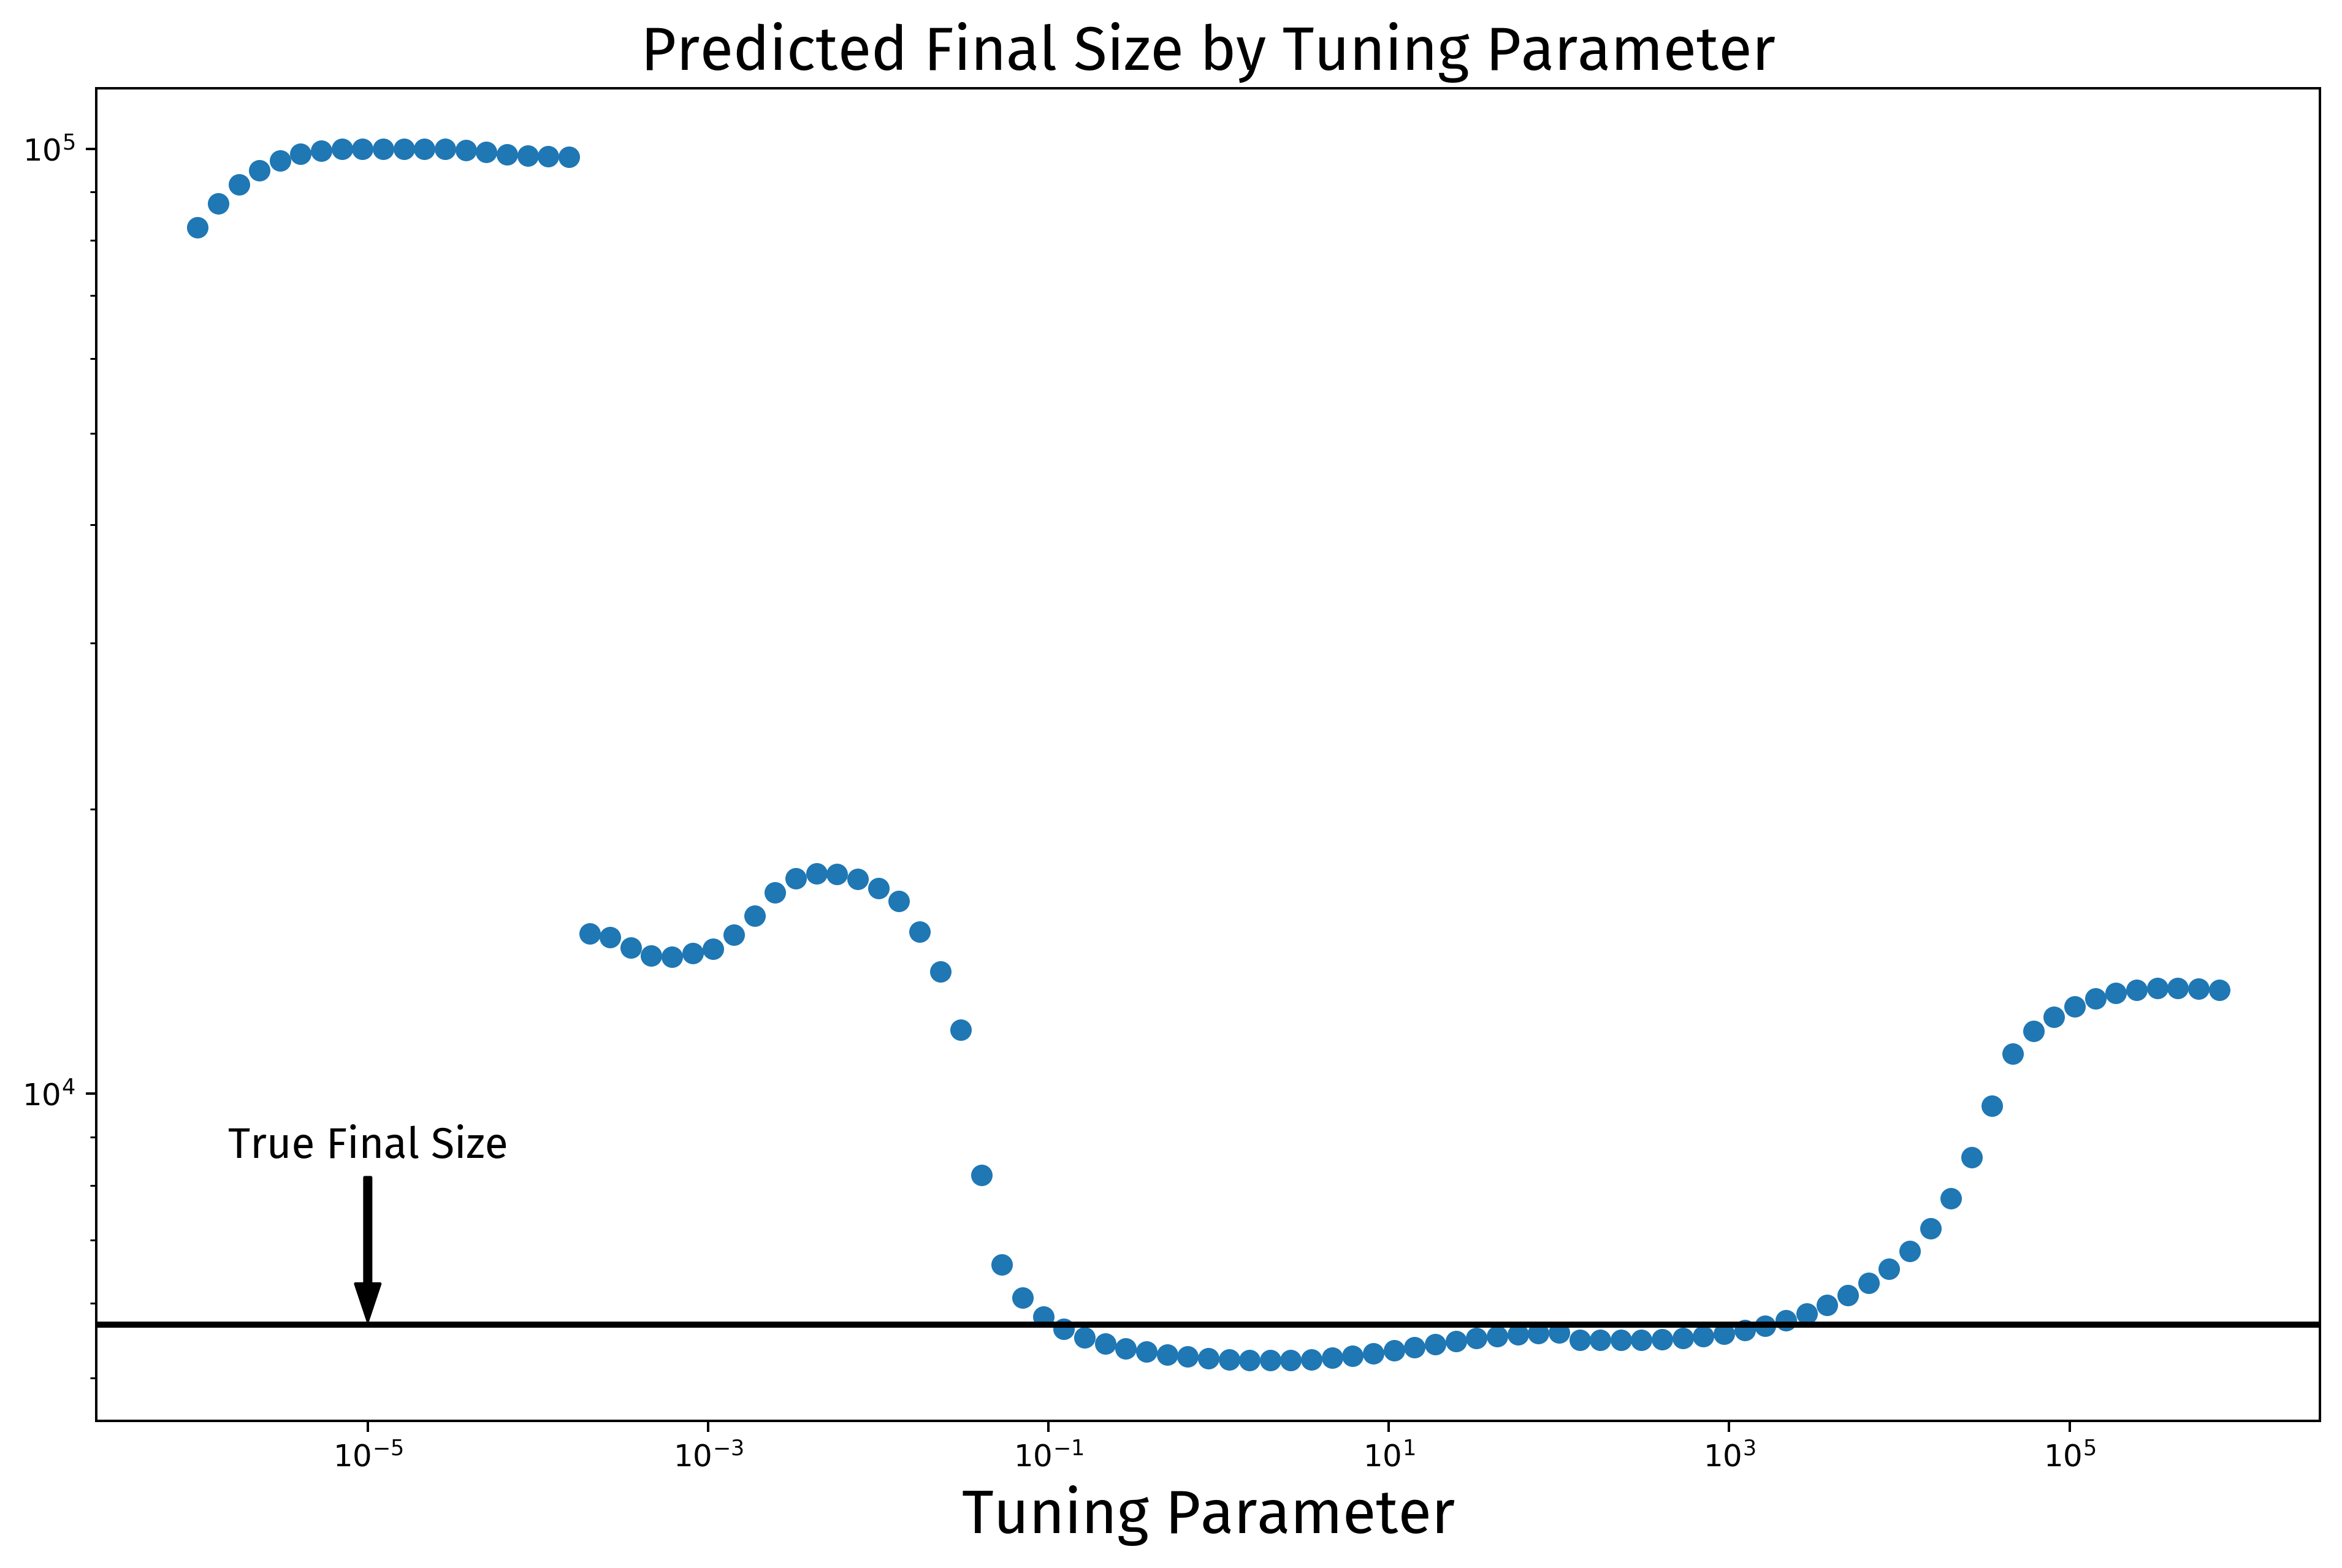

In [47]:
plt.figure(figsize=[13,8], dpi=360)
i0,i1 = (0, -1)
plt.plot(prange[i0:i1], [getx(sol['x'])[-2][-1] for sol in sols[i0:i1]],'o')
plt.xscale('log')

plt.axhline(cE[-1], color='k', linewidth=2)
plt.yscale('log')

plt.title("Predicted Final Size by Tuning Parameter", font_properties=label_font)
plt.xlabel("Tuning Parameter", font_properties=label_font)
plt.annotate('True Final Size', xy=(1e-5, cE[-1]), xytext=(1e-5, cE[-1]*1.5),
             arrowprops=dict(facecolor='black', shrink=0.025, width=2, headwidth=8),
             horizontalalignment="center", font_properties=tick_font
            )

Text(1e-05, 166.0, 'True Total Deaths')

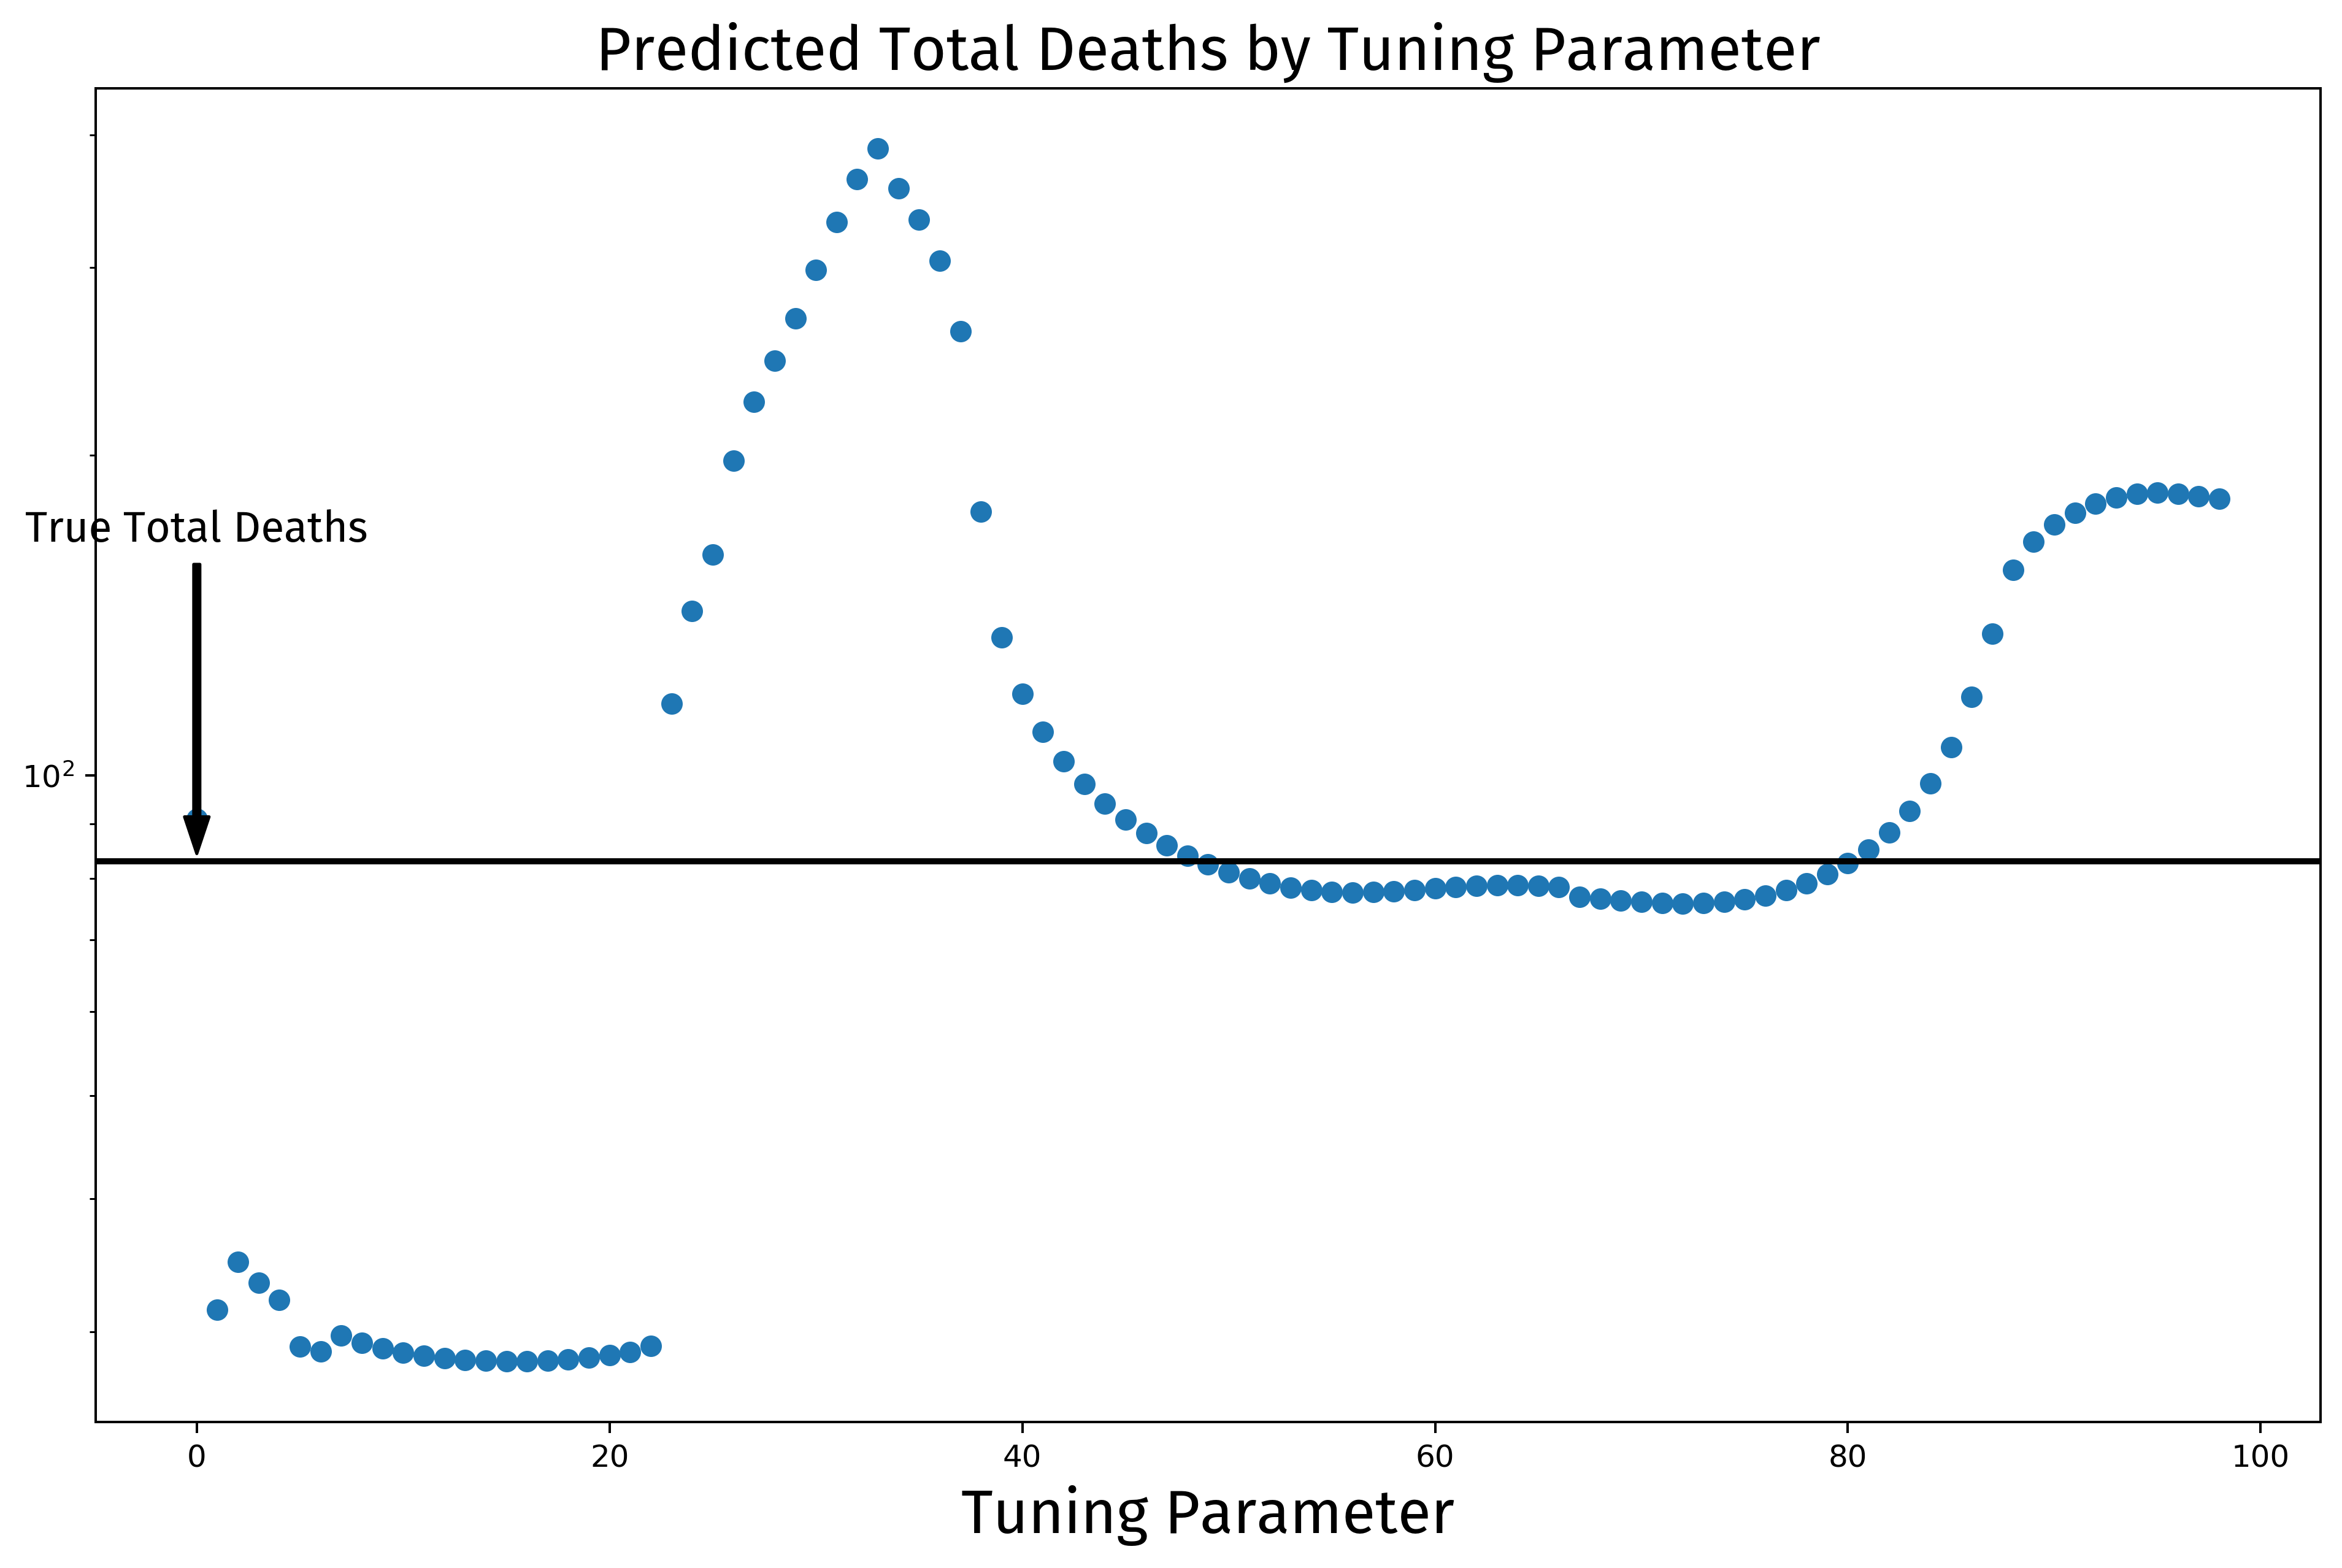

In [48]:
plt.figure(figsize=[13,8], dpi=360)
i0,i1 = (0, -1)
plt.plot( [getx(sol['x'])[6][-1] for sol in sols[i0:i1]],'o')
# plt.xscale('log')

plt.axhline(D[-1], color='k', linewidth=2)
plt.yscale('log')

plt.title("Predicted Total Deaths by Tuning Parameter", font_properties=label_font)
plt.xlabel("Tuning Parameter", font_properties=label_font)
plt.annotate('True Total Deaths', xy=(1e-5, D[-1]), xytext=(1e-5, D[-1]*2),
             arrowprops=dict(facecolor='black', shrink=0.025, width=2, headwidth=8),
             horizontalalignment="center", font_properties=tick_font
            )

(array([  0.,  20.,  40.,  60.,  80., 100.]),
 <a list of 6 Text yticklabel objects>)

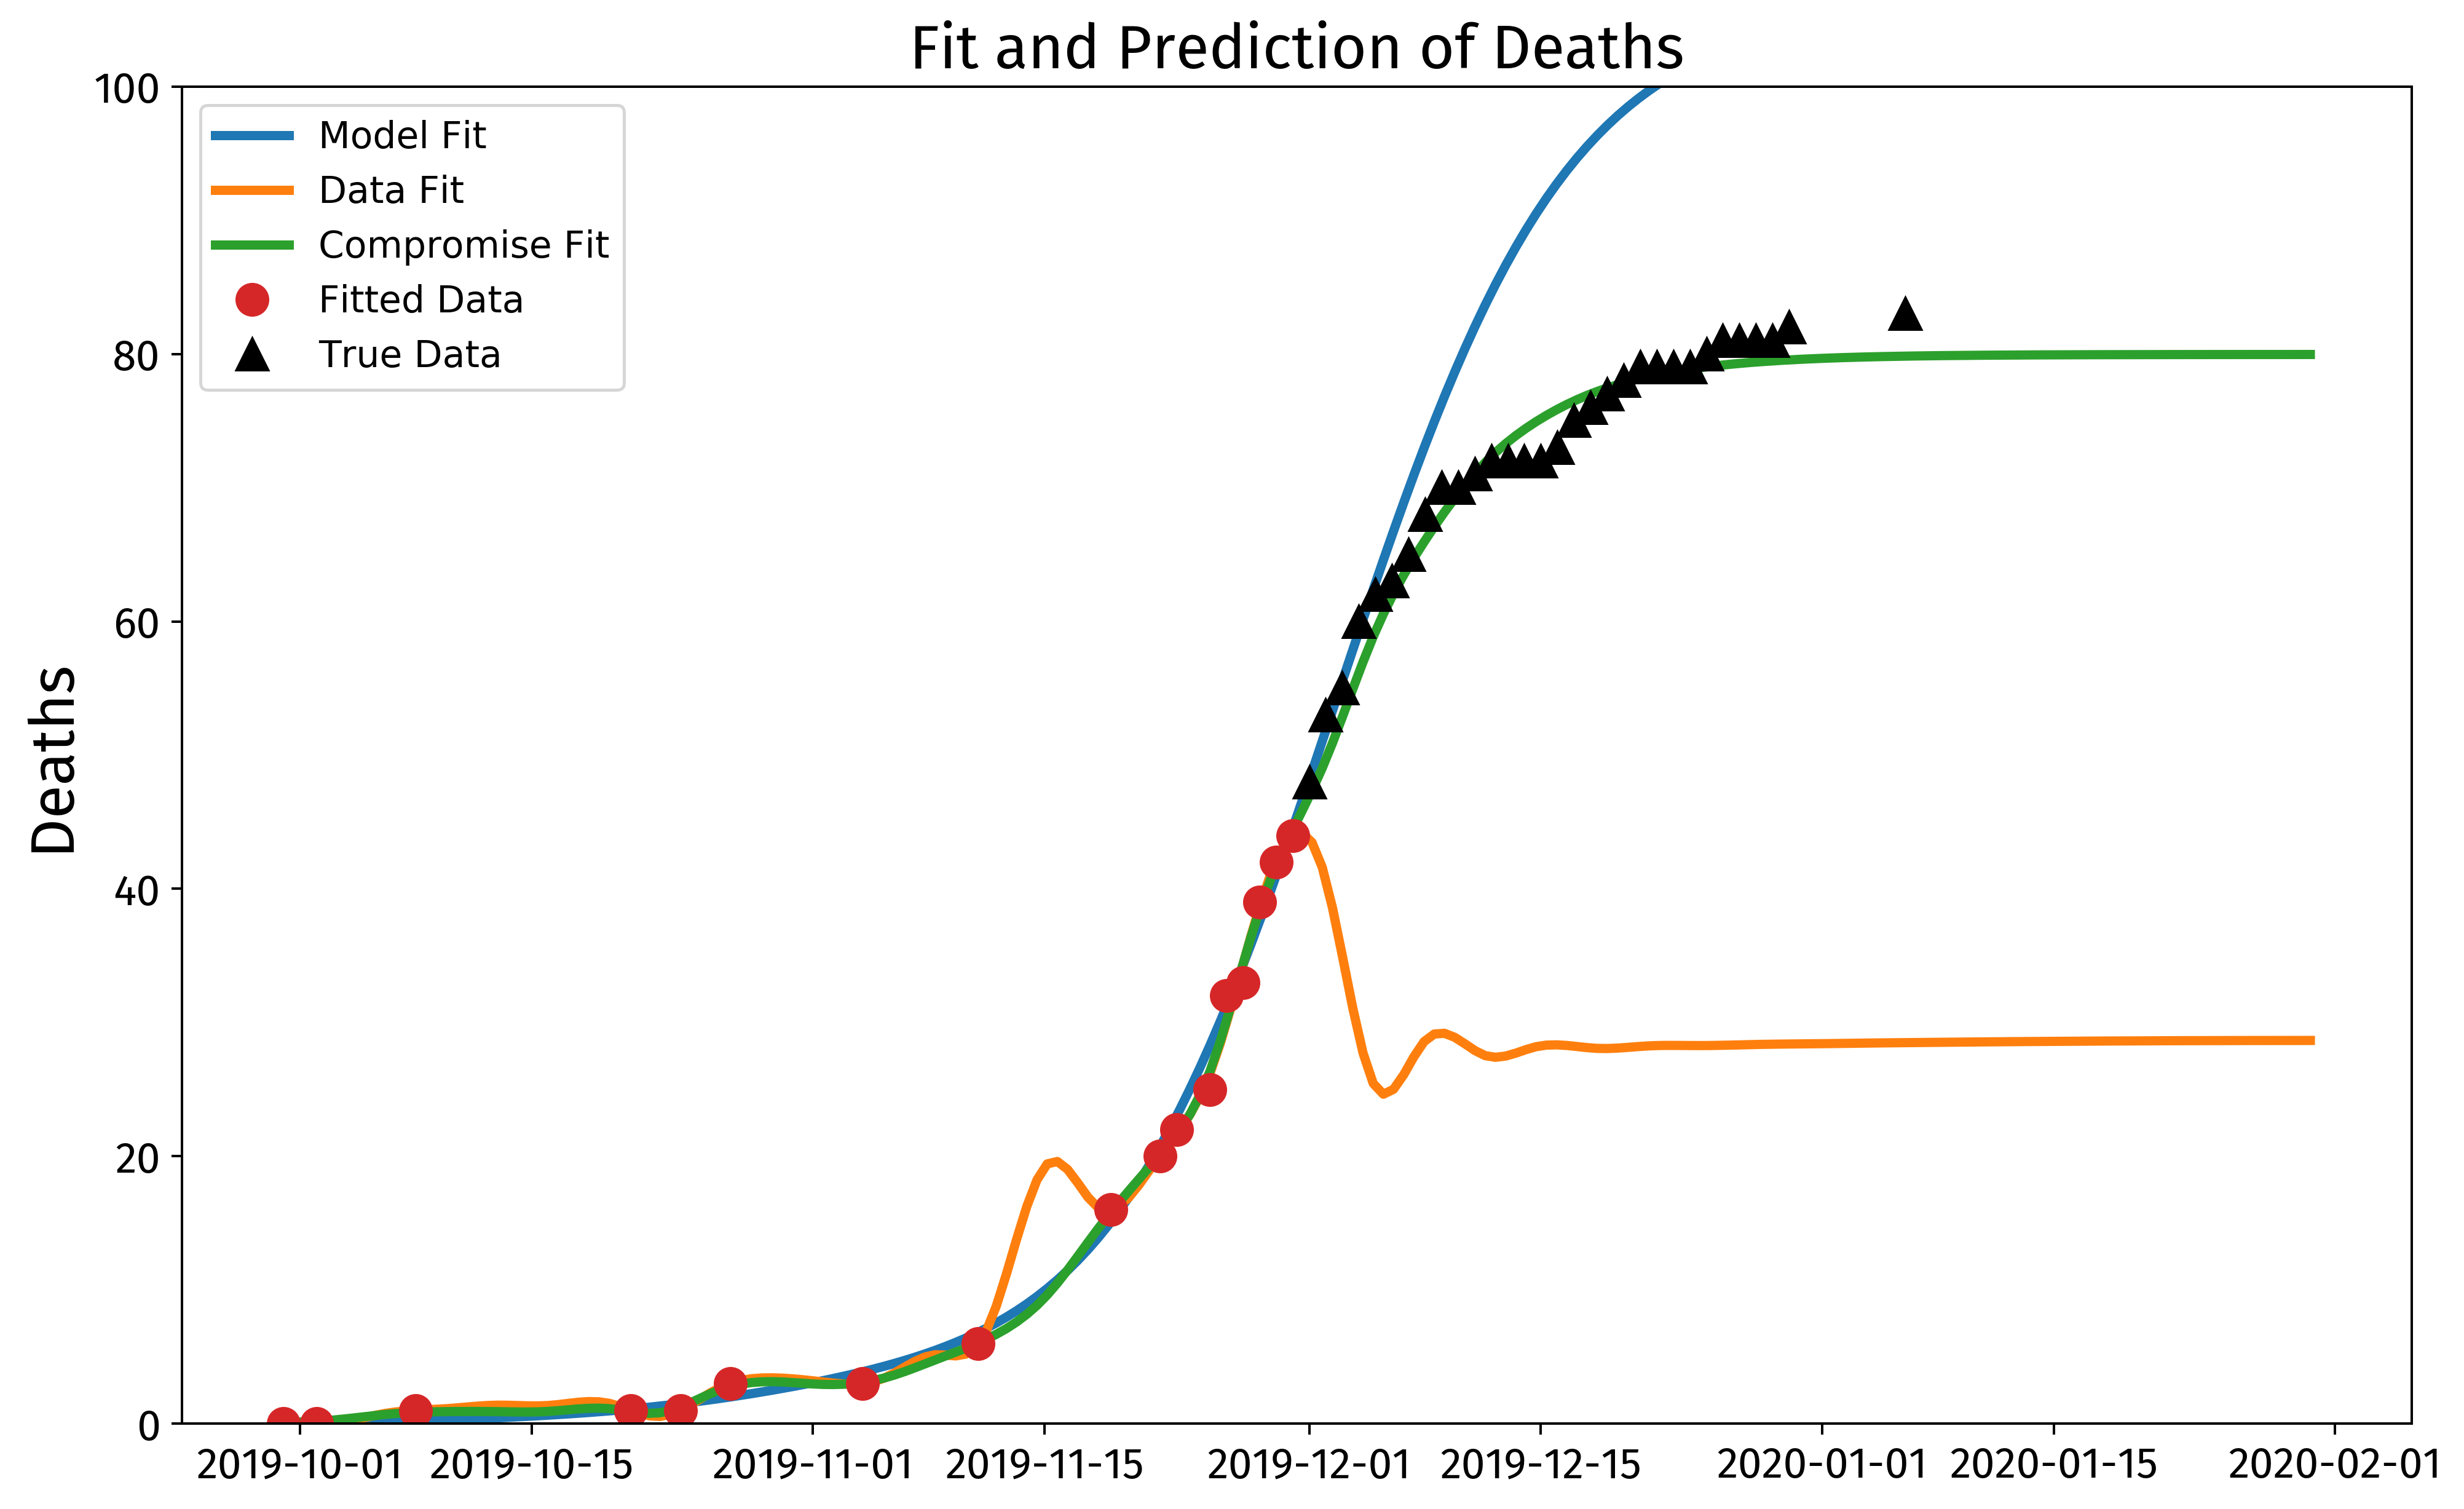

In [49]:
midx = -15
didx = 10
cidx = idx+5

plt.figure(figsize=[13,8], dpi=360)
for iidx in [midx, didx, cidx]:
    plt.plot(list(map(time_conv, model.observation_times)), getx(sols[iidx]['x'])[6], lw=3)
plt.plot(the_dates[start:clip], D[start:clip], 'o', markersize=10)
plt.plot(the_dates[clip:], D[clip:], 'k^', markersize=10)
plt.ylim([0, 100])
plt.title('Fit and Prediction of Deaths', font_properties=label_font)
plt.ylabel('Deaths', font_properties=label_font)
plt.legend(['Model Fit', 'Data Fit', 'Compromise Fit', 'Fitted Data', 'True Data'], fontsize='large')
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font)

Text(0.5, 1.0, 'L-Curve of Misfits')

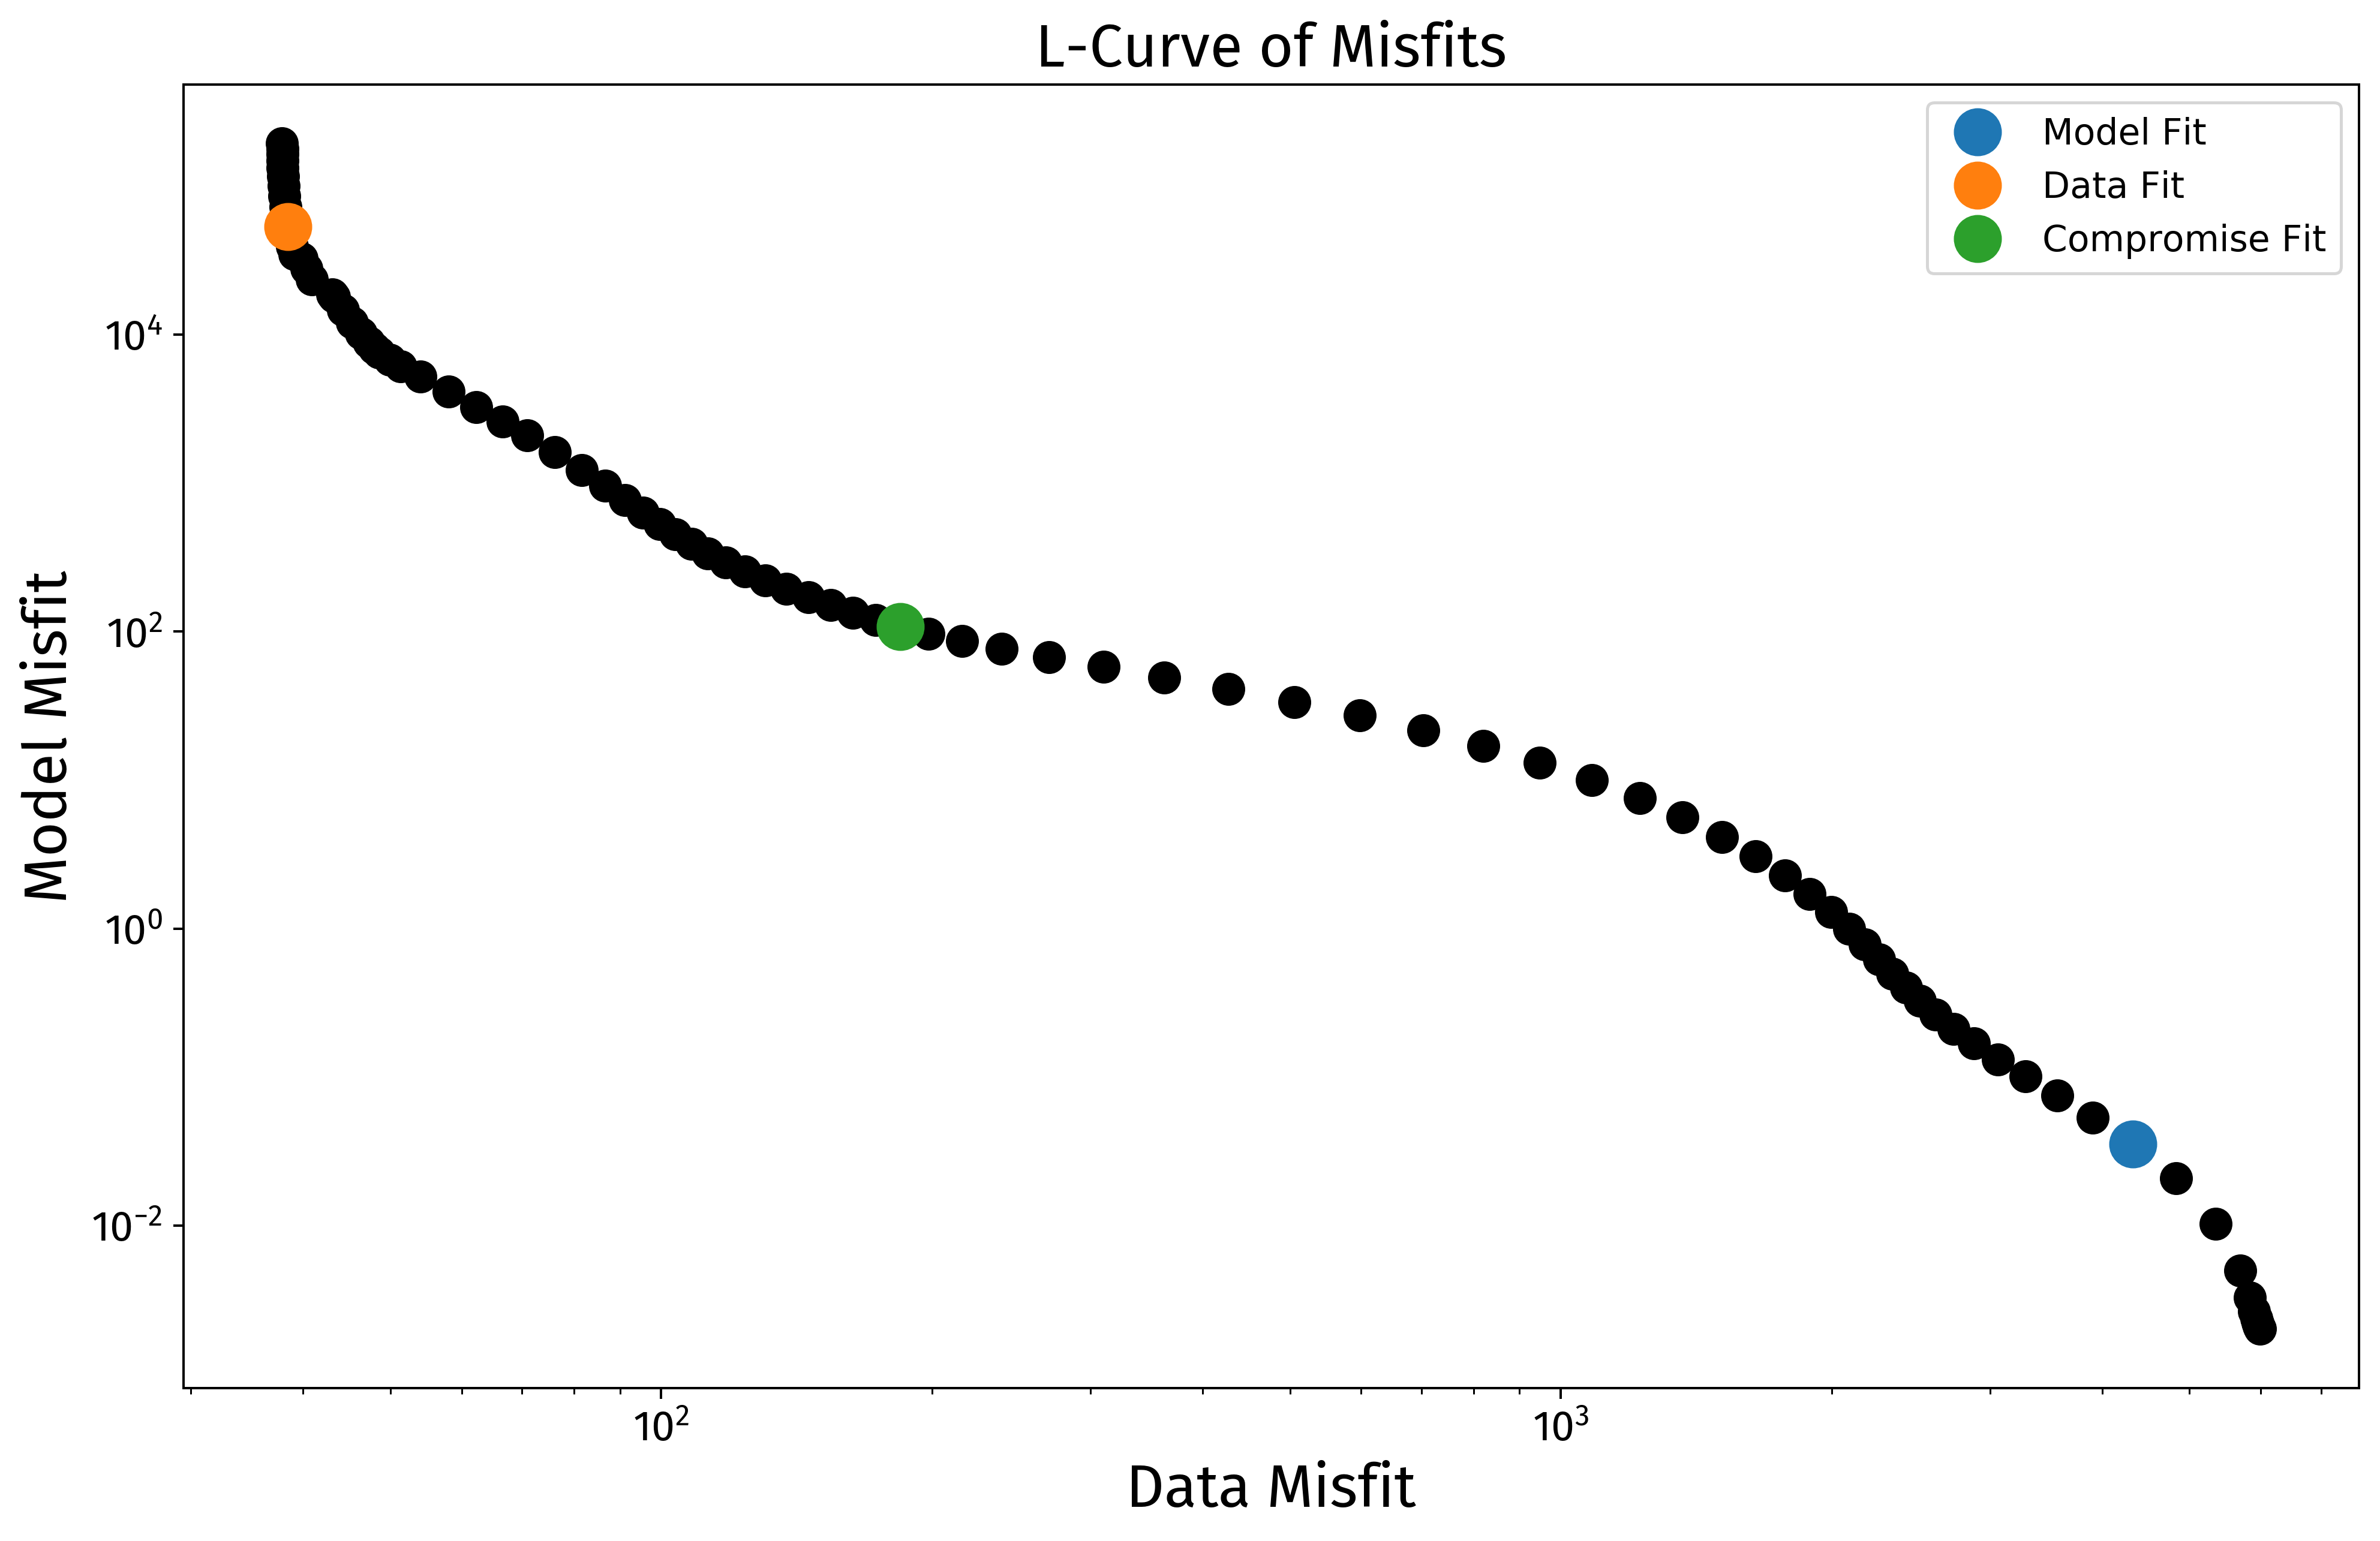

In [50]:
plt.figure(figsize=[13,8], dpi=360)
plt.loglog(*fsvals[:-5].T, 'ko', markersize=10)
for iidx, lbl in zip([midx, didx, cidx],[ 'Model Fit', 'Data Fit', 'Compromise Fit']) :
    plt.loglog(*fsvals[iidx], 'o', markersize=15, label=lbl)
plt.legend(fontsize='large')
plt.xlabel('Data Misfit', font_properties=label_font)
plt.ylabel('Model Misfit', font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font)
plt.title('L-Curve of Misfits', font_properties=label_font)

(0, 0.1)

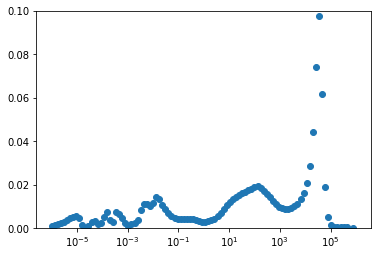

In [51]:
# L curve density
L = np.log10(fsvals)
Ld = [sum(z[0]**2) for z in zip(np.gradient(L, axis=0, edge_order=2))]
plt.semilogx(prange, Ld, 'o')
plt.ylim([0,0.1])

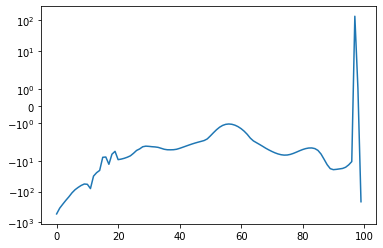

In [52]:
plt.plot([z[0][1]/z[0][0] for z in zip(np.gradient(L, axis=0, edge_order=2))])
plt.yscale('symlog', linthresh=1)

In [53]:
HESS, GRAD = ca.hessian(objective.objective, ca.vcat(model.ps))

detHESS = ca.det(HESS)
f_GRAD = ca.Function('fgrad', [solver_setup['x'], objective.rho, objective.alpha], [GRAD])
f_HESS = ca.Function('fhess', [solver_setup['x'], objective.rho, objective.alpha], [HESS])
f_detHESS = ca.Function('fdethess', [solver_setup['x'], objective.rho, objective.alpha], [detHESS])

In [54]:
print(ca.diag(f_HESS(sols[idx]['x'], prange[idx], alpha)))
f_HESS(sols[idx]['x'], prange[idx], alpha)

[24.5247, 100068, 53446.3, 11667.3, 13421.6, 26783.1]


DM(
[[24.5247, -624.102, 00, 00, 00, 00], 
 [-624.102, 100068, -20921.2, 00, -20921.2, -20921.2], 
 [00, -20921.2, 53446.3, -8467.34, 13361.6, 13361.6], 
 [00, 00, -8467.34, 11667.3, 00, 00], 
 [00, -20921.2, 13361.6, 00, 13421.6, 13361.6], 
 [00, -20921.2, 13361.6, 00, 13361.6, 26783.1]])

In [55]:
f_detHESS(sols[idx]['x'], prange[idx], alpha)

DM(9.07832e+22)

In [56]:
f_GRAD(sols[idx]['x'], prange[idx], alpha)

DM([5.5438e-11, 2.25646e-09, 5.62987e-09, 3.74206e-09, 2.28589e-09, 8.11117e-08])

In [163]:
# R0 profiling

r0profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat([ca.vcat(model.xs), model.ps[0]/(model.ps[2]+model.ps[4]+model.ps[5])]),
}
r0profiler = ca.nlpsol('r0profiler', 'ipopt', r0profiler_setup, ipopt_opts)

In [164]:
pref = sols[idx]['x']
r0profile = []
r0range = np.linspace(1,40,num=60)
for ri in r0range:
    lbg = [0]*r0profiler_setup['g'].shape[0]
    ubg = [200000]*r0profiler_setup['g'].shape[0]
    lbg[-1] = ri
    ubg[-1] = ri
    r0solve_opts = {
        'x0': pref,
        'p': [prange[idx], alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg,
    }
    print(f'b={ri}')
    r0profile.append(r0profiler(**r0solve_opts))

b=1.0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7267

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


 100  2.3911474e+02 4.44e-16 1.36e+01  -3.8 5.74e+02  -8.0 1.00e+00 1.00e+00f  1
 150  2.3416007e+02 0.00e+00 1.24e-02  -3.8 2.08e+01  -8.4 1.00e+00 1.00e+00f  1
 200  2.2836067e+02 0.00e+00 2.47e+01  -3.8 1.87e+03  -9.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 239

                                   (scaled)                 (unscaled)
Objective...............:   2.2140249987826053e+02    2.2140249987826053e+02
Dual infeasibility......:   5.1656111671251565e-09    5.1656111671251565e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.6209396702624945e-09    7.6209396702624945e-09
Overall NLP error.......:   7.6209396702624945e-09    7.6209396702624945e-09


Number of objective function evaluations             = 292
Number of objective gradient evaluations             = 240
Number of equality constraint evaluations            = 292
Number of inequality constraint evaluations          = 292
Number of equality constraint J

 100  2.3346214e+02 4.44e-16 3.49e+01  -2.5 3.30e+02  -9.8 1.00e+00 1.00e+00f  1
 150  2.2754475e+02 8.88e-16 3.38e-02  -3.8 3.06e+01  -7.5 1.00e+00 1.00e+00f  1

Number of Iterations....: 182

                                   (scaled)                 (unscaled)
Objective...............:   2.2136477886926778e+02    2.2136477886926778e+02
Dual infeasibility......:   7.2318002384705745e-10    7.2318002384705745e-10
Constraint violation....:   4.4408920985006262e-16    4.4408920985006262e-16
Complementarity.........:   7.2465119139165489e-09    7.2465119139165489e-09
Overall NLP error.......:   7.2465119139165489e-09    7.2465119139165489e-09


Number of objective function evaluations             = 226
Number of objective gradient evaluations             = 183
Number of equality constraint evaluations            = 226
Number of inequality constraint evaluations          = 226
Number of equality constraint Jacobian evaluations   = 183
Number of inequality constraint Jacobian evaluations 

 100  2.2973613e+02 0.00e+00 1.96e+01  -2.5 6.27e+03 -10.5 1.00e+00 1.00e+00f  1
 150  2.2134839e+02 0.00e+00 1.86e-05  -5.7 2.83e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 155

                                   (scaled)                 (unscaled)
Objective...............:   2.2134835757803839e+02    2.2134835757803839e+02
Dual infeasibility......:   2.8415936002161549e-10    2.8415936002161549e-10
Constraint violation....:   8.8817841970012523e-16    8.8817841970012523e-16
Complementarity.........:   7.0889089630197134e-09    7.0889089630197134e-09
Overall NLP error.......:   7.0889089630197134e-09    7.0889089630197134e-09


Number of objective function evaluations             = 199
Number of objective gradient evaluations             = 156
Number of equality constraint evaluations            = 199
Number of inequality constraint evaluations          = 199
Number of equality constraint Jacobian evaluations   = 156
Number of inequality constraint Jacobian evaluations 

 100  2.2134512e+02 8.88e-16 6.16e-02  -3.8 4.06e-01  -5.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 110

                                   (scaled)                 (unscaled)
Objective...............:   2.2133688402133350e+02    2.2133688402133350e+02
Dual infeasibility......:   2.6646954363239970e-10    2.6646954363239970e-10
Constraint violation....:   8.8817841970012523e-16    8.8817841970012523e-16
Complementarity.........:   7.9286542993714851e-09    7.9286542993714851e-09
Overall NLP error.......:   7.9286542993714851e-09    7.9286542993714851e-09


Number of objective function evaluations             = 146
Number of objective gradient evaluations             = 111
Number of equality constraint evaluations            = 146
Number of inequality constraint evaluations          = 146
Number of equality constraint Jacobian evaluations   = 111
Number of inequality constraint Jacobian evaluations = 111
Number of Lagrangian Hessian evaluations             = 110
Total CPU secs i

b=9.35593220338983
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7267

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du 

  nlp_hess_l  | 146.83ms (  1.25ms) 147.01ms (  1.26ms)       117
   nlp_jac_g  |   6.08ms ( 51.08us)   6.10ms ( 51.28us)       119
       total  |   1.17 s (  1.17 s)   1.17 s (  1.17 s)         1
b=10.830508474576272
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7267

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:       

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7267

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2131259e+02 2.19e+01 1.03e+00  -1.0 0.00e+00    -  0.00e+00 0.

Number of inequality constraint evaluations          = 237
Number of equality constraint Jacobian evaluations   = 144
Number of inequality constraint Jacobian evaluations = 144
Number of Lagrangian Hessian evaluations             = 143
Total CPU secs in IPOPT (w/o function evaluations)   =      1.061
Total CPU secs in NLP function evaluations           =      0.243

EXIT: Optimal Solution Found.
  r0profiler  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  18.27ms ( 77.07us)  18.30ms ( 77.20us)       237
       nlp_g  |   8.67ms ( 36.58us)   8.66ms ( 36.56us)       237
    nlp_grad  | 227.00us (227.00us) 195.75us (195.75us)         1
  nlp_grad_f  |  23.78ms (164.01us)  23.75ms (163.77us)       145
  nlp_hess_l  | 181.35ms (  1.27ms) 181.24ms (  1.27ms)       143
   nlp_jac_g  |   7.53ms ( 51.94us)   7.55ms ( 52.06us)       145
       total  |   1.31 s (  1.31 s)   1.31 s (  1.31 s)         1
b=14.76271186440678
This is Ipopt version 3.12.3, running with linear sol

  50  2.2821204e+02 0.00e+00 2.15e+01  -2.5 4.25e+01  -6.6 1.00e+00 5.00e-01f  2

Number of Iterations....: 88

                                   (scaled)                 (unscaled)
Objective...............:   2.2131993704936986e+02    2.2131993704936986e+02
Dual infeasibility......:   9.9144547327262326e-11    9.9144547327262326e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.7570834289095254e-09    7.7570834289095254e-09
Overall NLP error.......:   7.7570834289095254e-09    7.7570834289095254e-09


Number of objective function evaluations             = 131
Number of objective gradient evaluations             = 89
Number of equality constraint evaluations            = 131
Number of inequality constraint evaluations          = 131
Number of equality constraint Jacobian evaluations   = 89
Number of inequality constraint Jacobian evaluations = 89
Number of Lagrangian Hessian evaluations             = 88
Total CPU secs in IPO

 550  2.6206640e+02 0.00e+00 1.29e+02  -2.5 5.27e+01  -8.2 1.00e+00 1.00e+00f  1
 600  2.5744643e+02 3.55e-15 3.26e+03  -2.5 1.79e+03  -9.9 1.00e+00 5.00e-01f  2
 650  2.5456549e+02 0.00e+00 6.47e+01  -2.5 1.20e+01  -7.5 1.00e+00 1.00e+00f  1
 700  2.5378280e+02 3.55e-15 1.41e+01  -2.5 4.96e+01  -8.2 1.00e+00 1.00e+00f  1
 750  2.5257061e+02 3.55e-15 7.81e+00  -2.5 3.17e+01  -7.7 1.00e+00 1.00e+00f  1
 800  2.5042337e+02 0.00e+00 5.98e+00  -2.5 7.87e+00  -6.2 1.00e+00 1.00e+00f  1
 850  2.4638505e+02 3.55e-15 4.12e+01  -2.5 2.89e+01  -6.6 1.00e+00 1.00e+00f  1
 900  2.4072188e+02 3.55e-15 1.12e+02  -2.5 9.50e+01  -7.0 1.00e+00 1.00e+00f  1
 950  2.3003446e+02 0.00e+00 5.77e+00  -2.5 6.28e+00  -5.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.2131882e+02 0.00e+00 2.62e-04  -5.7 2.11e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1005

                                   (scaled)                 (unscaled)
Objec

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.6586975e+02 3.55e-15 2.99e+03  -3.8 3.98e+02  -9.2 1.00e+00 1.00e+00f  1
 550  2.6264947e+02 0.00e+00 5.93e+02  -3.8 6.02e+02  -9.1 1.00e+00 1.00e+00f  1
 600  2.5718861e+02 0.00e+00 4.22e+02  -3.8 1.90e+02  -8.6 1.00e+00 1.00e+00f  1
 650  2.5453422e+02 3.55e-15 1.22e+02  -3.8 2.49e+02  -8.9 9.08e-01 1.00e+00f  1
 700  2.5377305e+02 0.00e+00 1.76e+01  -3.8 3.33e+01  -7.5 1.00e+00 1.00e+00f  1
 750  2.5264733e+02 3.55e-15 8.83e+02  -3.8 4.79e+02  -8.8 1.00e+00 1.00e+00f  1
 800  2.5076937e+02 3.55e-15 1.40e+01  -3.8 3.88e+01  -7.3 1.00e+00 1.00e+00f  1
 850  2.4692735e+02 3.55e-15 1.50e+02  -3.8 2.35e+02  -7.7 1.00e+00 1.00e+00f  1
 900  2.4075243e+02 3.55e-15 7.97e+01  -3.8 1.75e+02  -7.2 1.00e+00 1.00e+00f  1
 950  2.3150437e+02 3.55e-15 2.79e+00  -3.8 1.05e+01  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.2131810e+02 0.00e+00

 250  2.7130855e+02 3.55e-15 2.13e+02  -1.7 1.71e+02 -10.1 1.00e+00 1.00e+00f  1
 300  2.6944211e+02 3.55e-15 1.06e+03  -3.8 4.06e+02  -9.7 1.00e+00 1.00e+00f  1
 350  2.6898838e+02 3.55e-15 1.33e+02  -3.8 2.66e+03 -10.1 1.00e+00 1.25e-01f  4
 400  2.6850569e+02 0.00e+00 4.20e+02  -3.8 2.89e+03 -10.5 1.00e+00 2.50e-01f  3
 450  2.6746188e+02 3.55e-15 1.22e+03  -3.8 1.77e+02  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.6565255e+02 0.00e+00 7.86e+02  -3.8 1.66e+03  -9.4 1.00e+00 2.50e-01f  3
 550  2.6190238e+02 3.55e-15 2.56e+03  -3.8 3.84e+02  -8.9 1.00e+00 1.00e+00f  1
 600  2.5588590e+02 3.55e-15 8.33e+02  -3.8 4.92e+01  -7.5 1.00e+00 1.00e+00f  1
 650  2.5394465e+02 0.00e+00 1.44e-01  -3.8 7.59e+00  -6.9 1.00e+00 1.00e+00f  1
 700  2.5269307e+02 0.00e+00 6.73e+00  -3.8 3.87e+00  -6.4 1.00e+00 1.00e+00f  1
 750  2.5017514e+02 0.00e+00 1.49e+02  -3.8 1.97e+01  -6.8 1.00e+00 1.00e+00f  1
 800  2.4628551e+02 3.55e-15

 200  2.6168942e+02 3.55e-15 3.86e+02  -1.7 9.87e+02    -  1.00e+00 1.25e-01f  4
 250  2.5778037e+02 0.00e+00 6.80e+02  -1.7 5.13e+02    -  1.00e+00 5.00e-01f  2
 300  2.5412327e+02 0.00e+00 4.12e+01  -3.8 7.43e+01  -8.1 1.00e+00 1.00e+00f  1
 350  2.5319094e+02 3.55e-15 4.70e+01  -3.8 2.67e+01  -7.5 1.00e+00 1.00e+00f  1
 400  2.5166148e+02 3.55e-15 3.84e+01  -3.8 1.51e+01  -7.0 1.00e+00 1.00e+00f  1
 450  2.4847511e+02 3.55e-15 9.97e+01  -3.8 2.75e+01  -6.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4348409e+02 3.55e-15 1.58e+00  -3.8 6.89e+00  -5.9 1.00e+00 1.00e+00f  1
 550  2.3257038e+02 0.00e+00 1.98e+02  -3.8 3.01e+02  -7.2 1.00e+00 1.00e+00f  1
 600  2.2353608e+02 3.55e-15 8.17e-02  -3.8 1.04e+01  -7.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 621

                                   (scaled)                 (unscaled)
Objective...............:   2.2131668503091424e+02    2.2131668503091424e+02
Dual infea

 600  2.5699776e+02 3.55e-15 3.02e+00  -3.8 1.82e+01  -7.1 1.00e+00 1.00e+00f  1
 650  2.5442088e+02 0.00e+00 8.22e+00  -3.8 1.59e+01  -6.5 1.00e+00 1.00e+00f  1
 700  2.5079463e+02 0.00e+00 1.44e+03  -3.8 3.65e+01  -6.0 1.00e+00 1.00e+00f  1
 750  2.4293469e+02 3.55e-15 1.91e+01  -3.8 3.29e+01  -6.4 1.00e+00 1.00e+00f  1
 800  2.3247767e+02 3.55e-15 5.04e+01  -3.8 1.39e+02  -6.8 1.00e+00 1.00e+00f  1
 850  2.2132428e+02 7.11e-15 6.68e-03  -3.8 5.45e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 859

                                   (scaled)                 (unscaled)
Objective...............:   2.2131620888400010e+02    2.2131620888400010e+02
Dual infeasibility......:   8.3048264779065086e-11    8.3048264779065086e-11
Constraint violation....:   3.5527136788005009e-15    3.5527136788005009e-15
Complementarity.........:   7.7199913295913602e-09    7.7199913295913602e-09
Overall NLP error.......:   7.7199913295913602e-09    7.7199913295913602e-09


Number of objective func

 750  2.3289413e+02 0.00e+00 3.13e+01  -3.8 4.33e+01  -6.9 1.00e+00 1.00e+00f  1
 800  2.2813705e+02 3.55e-15 4.37e+02  -3.8 2.10e+04    -  2.37e-01 4.49e-02f  3
 850  2.2131583e+02 0.00e+00 2.60e-04  -5.7 2.70e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 855

                                   (scaled)                 (unscaled)
Objective...............:   2.2131577344023799e+02    2.2131577344023799e+02
Dual infeasibility......:   8.0528973500017161e-11    8.0528973500017161e-11
Constraint violation....:   3.5527136788005009e-15    3.5527136788005009e-15
Complementarity.........:   7.7156651639311420e-09    7.7156651639311420e-09
Overall NLP error.......:   7.7156651639311420e-09    7.7156651639311420e-09


Number of objective function evaluations             = 1678
Number of objective gradient evaluations             = 856
Number of equality constraint evaluations            = 1678
Number of inequality constraint evaluations          = 1678
Number of equality constrain

 850  2.3197473e+02 3.55e-15 1.86e+01  -3.8 3.62e+01  -6.7 1.00e+00 1.00e+00f  1
 900  2.2497572e+02 3.55e-15 5.43e+02  -3.8 1.44e+05    -  4.27e-02 1.18e-02f  3

Number of Iterations....: 936

                                   (scaled)                 (unscaled)
Objective...............:   2.2131537369379919e+02    2.2131537369379919e+02
Dual infeasibility......:   7.9364737152769931e-11    7.9364737152769931e-11
Constraint violation....:   3.5527136788005009e-15    3.5527136788005009e-15
Complementarity.........:   7.7116961326219558e-09    7.7116961326219558e-09
Overall NLP error.......:   7.7116961326219558e-09    7.7116961326219558e-09


Number of objective function evaluations             = 1924
Number of objective gradient evaluations             = 937
Number of equality constraint evaluations            = 1924
Number of inequality constraint evaluations          = 1924
Number of equality constraint Jacobian evaluations   = 937
Number of inequality constraint Jacobian evaluatio

 750  2.3558208e+02 0.00e+00 4.88e+02  -3.8 1.94e+02  -8.0 1.00e+00 1.00e+00f  1
 800  2.3299354e+02 0.00e+00 2.70e+00  -5.7 8.47e+00  -6.3 1.00e+00 1.00e+00f  1
 850  2.2707908e+02 0.00e+00 1.50e-01  -5.7 2.52e+00  -5.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 893

                                   (scaled)                 (unscaled)
Objective...............:   2.2131500542731260e+02    2.2131500542731260e+02
Dual infeasibility......:   5.1024118836653854e-11    5.1024118836653854e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.7531578309240670e-09    6.7531578309240670e-09
Overall NLP error.......:   6.7531578309240670e-09    6.7531578309240670e-09


Number of objective function evaluations             = 1817
Number of objective gradient evaluations             = 894
Number of equality constraint evaluations            = 1817
Number of inequality constraint evaluations          = 1817
Number of equality constrain

 800  2.3216143e+02 3.55e-15 3.01e-01  -3.8 1.61e+00  -4.7 1.00e+00 1.00e+00f  1
 850  2.2649869e+02 3.55e-15 1.17e-01  -3.8 8.67e-01  -4.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 891

                                   (scaled)                 (unscaled)
Objective...............:   2.2131466506298366e+02    2.2131466506298366e+02
Dual infeasibility......:   8.3440621755167394e-11    8.3440621755167394e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.7046389034282840e-09    7.7046389034282840e-09
Overall NLP error.......:   7.7046389034282840e-09    7.7046389034282840e-09


Number of objective function evaluations             = 1827
Number of objective gradient evaluations             = 892
Number of equality constraint evaluations            = 1827
Number of inequality constraint evaluations          = 1827
Number of equality constraint Jacobian evaluations   = 892
Number of inequality constraint Jacobian evaluatio

 700  2.2839099e+02 3.55e-15 6.37e+02  -3.8 4.57e+04    -  9.32e-02 4.57e-02f  3
 750  2.2131440e+02 3.55e-15 2.59e-04  -5.7 3.15e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 755

                                   (scaled)                 (unscaled)
Objective...............:   2.2131434954496913e+02    2.2131434954496913e+02
Dual infeasibility......:   7.8032847829951703e-11    7.8032847829951703e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.7015069733438286e-09    7.7015069733438286e-09
Overall NLP error.......:   7.7015069733438286e-09    7.7015069733438286e-09


Number of objective function evaluations             = 1540
Number of objective gradient evaluations             = 756
Number of equality constraint evaluations            = 1540
Number of inequality constraint evaluations          = 1540
Number of equality constraint Jacobian evaluations   = 756
Number of inequality constraint Jacobian evaluatio

 850  2.2142456e+02 3.55e-15 7.88e+01  -3.8 9.27e+03    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 865

                                   (scaled)                 (unscaled)
Objective...............:   2.2131405624827613e+02    2.2131405624827613e+02
Dual infeasibility......:   7.3418231009054174e-11    7.3418231009054174e-11
Constraint violation....:   3.5527136788005009e-15    3.5527136788005009e-15
Complementarity.........:   7.6985849869937165e-09    7.6985849869937165e-09
Overall NLP error.......:   7.6985849869937165e-09    7.6985849869937165e-09


Number of objective function evaluations             = 1747
Number of objective gradient evaluations             = 866
Number of equality constraint evaluations            = 1747
Number of inequality constraint evaluations          = 1747
Number of equality constraint Jacobian evaluations   = 866
Number of inequality constraint Jacobian evaluations = 866
Number of Lagrangian Hessian evaluations             = 865
Total CPU sec

  50  2.7373244e+02 3.55e-15 4.14e+03  -1.0 1.65e+04    -  9.65e-01 2.50e-01f  3
 100  2.7782787e+02 0.00e+00 1.09e+03  -1.0 1.57e+02  -7.2 1.00e+00 1.00e+00f  1
 150  2.8046133e+02 0.00e+00 7.95e+03  -1.0 6.54e+02  -8.6 1.00e+00 1.00e+00f  1
 200  2.8141549e+02 3.55e-15 1.00e+01  -1.0 9.13e+01  -8.1 1.00e+00 1.00e+00f  1
 250  2.6964221e+02 3.55e-15 2.31e+03  -2.5 3.43e+02  -9.9 1.00e+00 1.00e+00f  1
 300  2.6896332e+02 0.00e+00 4.04e+03  -2.5 3.95e+02 -10.3 1.00e+00 1.00e+00f  1
 350  2.6793878e+02 7.11e-15 4.06e+03  -2.5 2.73e+02  -9.8 1.00e+00 1.00e+00f  1
 400  2.6635770e+02 3.55e-15 1.17e+04  -2.5 1.02e+03 -10.6 1.00e+00 1.00e+00f  1
 450  2.6425478e+02 7.11e-15 3.53e+03  -2.5 4.86e+02 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.6135125e+02 3.55e-15 1.39e+03  -2.5 3.79e+02  -9.5 1.00e+00 1.00e+00f  1
 550  2.5623352e+02 0.00e+00 1.81e+03  -2.5 4.03e+02  -9.0 1.00e+00 1.00e+00f  1
 600  2.4654519e+02 3.55e-15

In [165]:
r0alsominf = min([s['f']-fr_ex(s['x']) for s in r0profile])

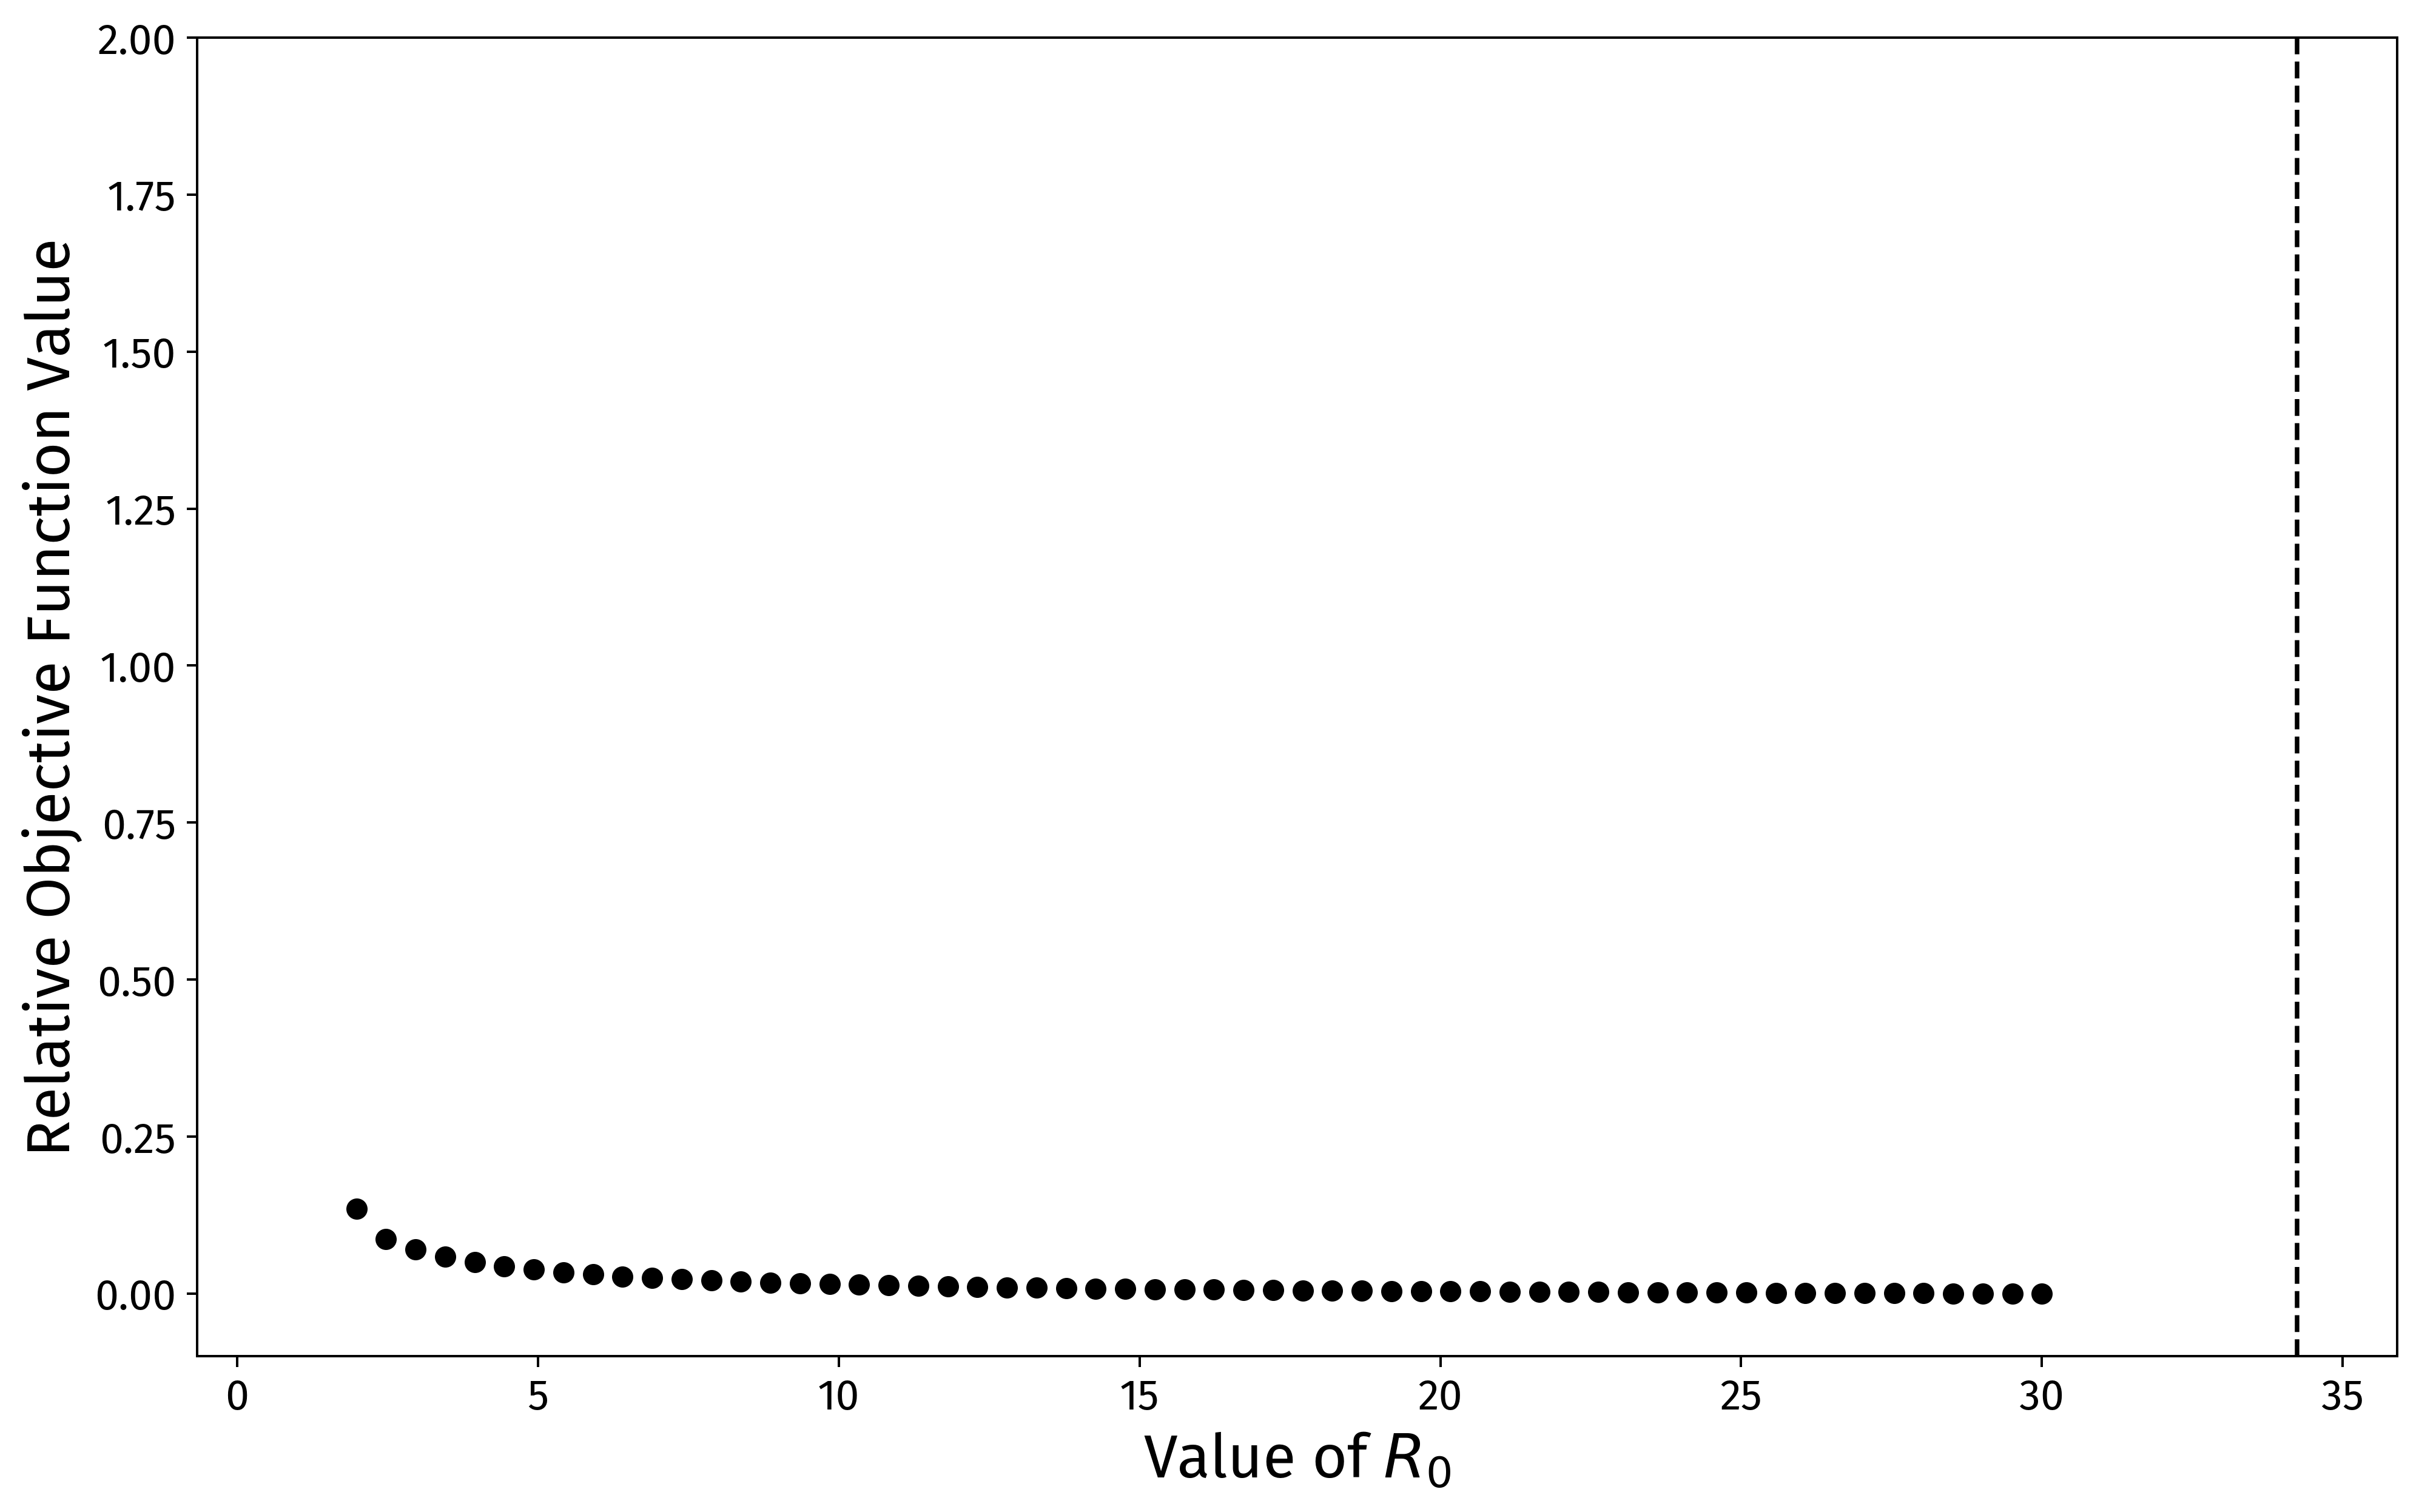

In [166]:
plt.figure(figsize=[13,8], dpi=360)
plt.plot(r0range, [s['f']-r0alsominf -fr_ex(s['x']) for s in r0profile], 'o', color='k',)
plt.axvline(float(r0(sols[idx])), linestyle='--', color='k')
plt.ylim([-0.1, 2])
# plt.xlim([0.0001, 0.00025])
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Relative Objective Function Value', font_properties=label_font)
plt.xlabel('Value of $R_0$', font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font);

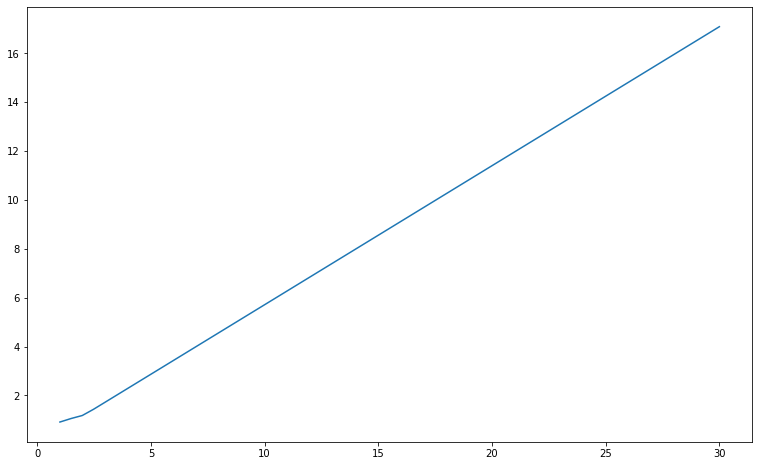

In [167]:
plt.figure(figsize=[13,8])
plt.plot(r0range, [getp(s['x'])[0] for s in r0profile])

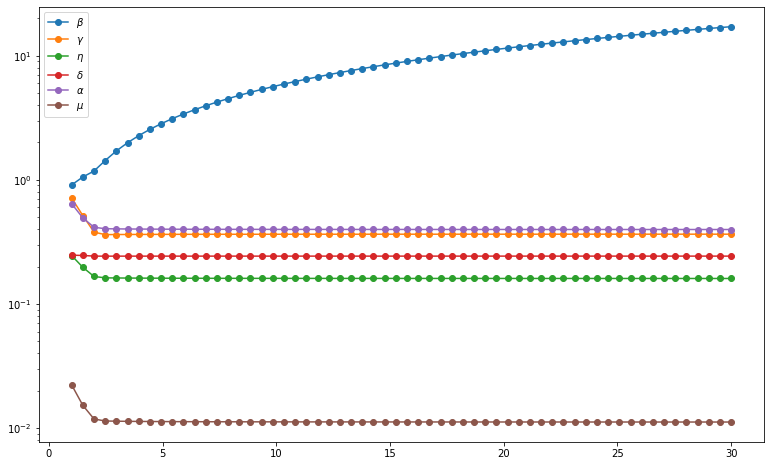

In [168]:
plt.figure(figsize=[13,8])
plt.plot(r0range, [float(s['x'][-6]) for s in r0profile], 'o-', label=r'$\beta$')
plt.plot(r0range, [float(s['x'][-5]) for s in r0profile], 'o-', label=r'$\gamma$')
plt.plot(r0range, [float(s['x'][-4]) for s in r0profile], 'o-', label=r'$\eta$')
plt.plot(r0range, [float(s['x'][-3]) for s in r0profile], 'o-', label=r'$\delta$')
plt.plot(r0range, [float(s['x'][-2]) for s in r0profile], 'o-', label=r'$\alpha$')
plt.plot(r0range, [float(s['x'][-1]) for s in r0profile], 'o-', label=r'$\mu$')
# plt.xscale('log')
plt.yscale('log')
plt.legend()

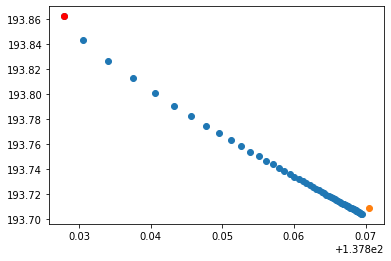

In [169]:
plt.plot(*np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in r0profile[3:]]).T, 'o')
plt.plot(f1_ex(r0profile[3]['x']), f2_ex(r0profile[3]['x']), 'ro')
plt.plot(f1_ex(sols[idx]['x']), f2_ex(sols[idx]['x']), 'o')


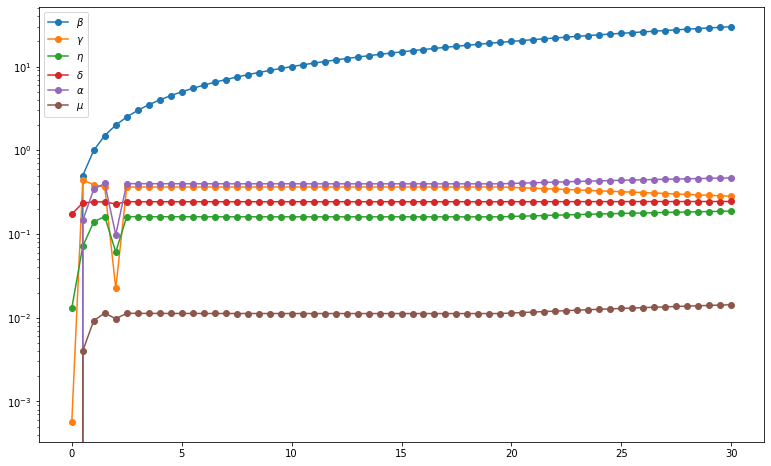

In [170]:
plt.figure(figsize=[13,8])
plt.plot(brange, [float(s['x'][-6]) for s in bprofile], 'o-', label=r'$\beta$')
plt.plot(brange, [float(s['x'][-5]) for s in bprofile], 'o-', label=r'$\gamma$')
plt.plot(brange, [float(s['x'][-4]) for s in bprofile], 'o-', label=r'$\eta$')
plt.plot(brange, [float(s['x'][-3]) for s in bprofile], 'o-', label=r'$\delta$')
plt.plot(brange, [float(s['x'][-2]) for s in bprofile], 'o-', label=r'$\alpha$')
plt.plot(brange, [float(s['x'][-1]) for s in bprofile], 'o-', label=r'$\mu$')
# plt.xscale('log')
plt.yscale('log')
plt.legend()

In [171]:
bNfn = lambda sol: getp(sol['x'])[0]/N0(sol)
bN_ref = bNfn(sols[idx])

In [173]:
bNprofiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat([ca.vcat(model.xs), model.ps[0]/sum(x[0] for x in model.xs)]),
}
bNprofiler = ca.nlpsol('bNprofiler', 'ipopt', bNprofiler_setup, ipopt_opts)

In [174]:
bNprofile = []
bNrange = np.linspace(0.0001,0.0003,num=60)
lbg = [0]*bNprofiler_setup['g'].shape[0]
ubg = [200000]*bNprofiler_setup['g'].shape[0]
for bi in bNrange:
    lbg[-1] = bi
    ubg[-1] = bi
    bNsolve_opts = {
        'x0': pref,
        'p': [prange[idx], alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg,
    }
    print(f'b={bi}')
    bNprofile.append(bNprofiler(**bNsolve_opts))

b=0.0001
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       10
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7285

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  

 100  2.7341925e+02 2.71e-20 5.21e+02  -1.0 9.49e+01  -7.3 1.00e+00 1.00e+00f  1
 150  2.7464399e+02 0.00e+00 2.79e+01  -1.0 1.23e+02  -8.4 1.00e+00 1.00e+00f  1
 200  2.5842664e+02 0.00e+00 1.17e+04  -1.7 3.27e+03  -9.5 1.00e+00 1.25e-01f  4
 250  2.5653508e+02 2.71e-20 3.20e+03  -1.7 1.69e+03    -  1.00e+00 1.25e-01f  4
 300  2.5365294e+02 1.36e-20 7.27e+03  -2.5 3.88e+02 -10.8 1.00e+00 1.00e+00f  1
 350  2.5315428e+02 1.36e-20 4.26e+02  -2.5 1.30e+02  -9.7 1.00e+00 1.00e+00f  1
 400  2.5285842e+02 0.00e+00 2.16e+02  -2.5 5.86e+01  -8.8 1.00e+00 1.00e+00f  1
 450  2.5260531e+02 0.00e+00 1.65e+01  -2.5 3.54e+01  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.5234284e+02 2.71e-20 1.24e+02  -2.5 1.41e+02  -9.7 1.00e+00 1.00e+00f  1
 550  2.5200071e+02 4.07e-20 4.77e+03  -2.5 1.57e+03 -10.2 1.00e+00 5.00e-01f  2
 600  2.5156825e+02 2.71e-20 1.41e+03  -2.5 3.15e+03 -10.3 1.00e+00 1.25e-01f  4
 650  2.5089873e+02 0.00e+00

 200  2.5798612e+02 0.00e+00 2.00e+03  -1.7 2.45e+02  -9.9 1.00e+00 1.00e+00f  1
 250  2.5605711e+02 1.36e-20 4.56e+02  -1.7 2.45e+03 -10.4 1.00e+00 1.25e-01f  4
 300  2.5292674e+02 1.36e-20 1.30e+03  -3.8 1.59e+02  -9.8 1.00e+00 1.00e+00f  1
 350  2.5247286e+02 1.36e-20 1.22e+03  -3.8 7.33e+02 -10.1 1.00e+00 2.50e-01f  3
 400  2.5224522e+02 1.36e-20 2.83e+01  -3.8 1.88e+01  -8.2 1.00e+00 1.00e+00f  1
 450  2.5198630e+02 0.00e+00 5.25e+01  -3.8 2.77e+01  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.5169435e+02 0.00e+00 3.19e+01  -3.8 7.44e+01  -8.9 1.00e+00 1.00e+00f  1
 550  2.5123573e+02 2.71e-20 6.85e+03  -3.8 3.83e+05    -  1.25e-01 2.77e-03f  6
 600  2.5076648e+02 1.36e-20 1.01e+03  -3.8 5.26e+04    -  2.16e-01 9.26e-03f  5
 650  2.4975025e+02 0.00e+00 9.53e+02  -3.8 2.55e+02  -8.5 1.00e+00 1.00e+00f  1
 700  2.4809836e+02 1.36e-20 4.01e+01  -3.8 4.93e+01  -7.5 1.00e+00 1.00e+00f  1
 750  2.4153023e+02 1.36e-20

 550  2.5059305e+02 2.71e-20 4.36e+03  -2.5 2.89e+04    -  1.00e+00 2.78e-02f  6
 600  2.5004736e+02 2.71e-20 3.79e+02  -2.5 3.81e+02  -9.4 1.00e+00 5.00e-01f  2
 650  2.4861685e+02 2.71e-20 3.45e+03  -2.5 1.65e+04  -9.3 3.86e-01 3.01e-02f  5
 700  2.4507090e+02 2.71e-20 2.40e+02  -2.5 1.62e+02  -7.6 1.00e+00 1.00e+00f  1
 750  2.2372999e+02 0.00e+00 1.58e-01  -2.5 1.45e+01  -5.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 776

                                   (scaled)                 (unscaled)
Objective...............:   2.2252206088653170e+02    2.2252206088653170e+02
Dual infeasibility......:   6.0132611616363983e-11    6.0132611616363983e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.2549078165648531e-09    1.2549078165648531e-09
Overall NLP error.......:   1.2549078165648531e-09    1.2549078165648531e-09


Number of objective function evaluations             = 1764
Number of objective gradient evaluations     

 150  2.7439804e+02 0.00e+00 2.65e+04  -1.0 1.10e+04    -  1.00e+00 2.50e-01f  3
 200  2.5492549e+02 0.00e+00 4.49e+03  -2.5 4.04e+02  -9.4 1.00e+00 1.00e+00f  1
 250  2.5255255e+02 2.71e-20 3.93e+02  -2.5 1.28e+03 -10.2 1.00e+00 1.00e+00f  1
 300  2.5169972e+02 2.71e-20 7.34e+02  -2.5 1.08e+03 -10.5 1.00e+00 1.00e+00f  1
 350  2.5125249e+02 0.00e+00 9.04e+03  -2.5 6.41e+03    -  1.00e+00 2.50e-01f  3
 400  2.5088516e+02 0.00e+00 4.33e+03  -2.5 1.24e+05    -  6.20e-01 8.06e-03f  7
 450  2.5062205e+02 2.71e-20 2.83e-01  -2.5 3.35e+00  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.5027935e+02 0.00e+00 2.77e+03  -2.5 5.90e+03    -  1.00e+00 1.25e-01f  4
 550  2.4983208e+02 2.71e-20 2.22e+03  -2.5 8.14e+03    -  1.00e+00 6.25e-02f  5
 600  2.4899965e+02 2.71e-20 7.73e+01  -2.5 6.13e+01  -8.4 1.00e+00 1.00e+00f  1
 650  2.4771131e+02 0.00e+00 1.21e+02  -2.5 8.81e+01  -8.1 1.00e+00 1.00e+00f  1
 700  2.4431015e+02 2.71e-20

 400  2.5052935e+02 0.00e+00 4.00e+00  -2.5 2.77e+01  -8.5 1.00e+00 1.00e+00f  1
 450  2.5021478e+02 0.00e+00 2.87e+00  -2.5 3.82e+01  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4985617e+02 5.42e-20 2.07e+01  -2.5 2.23e+01  -8.6 1.00e+00 1.00e+00f  1
 550  2.4931087e+02 2.71e-20 7.84e+00  -2.5 3.19e+01  -8.5 1.00e+00 1.00e+00f  1
 600  2.4856684e+02 0.00e+00 5.79e+02  -2.5 2.31e+02  -9.0 1.00e+00 1.00e+00f  1
 650  2.4730998e+02 2.71e-20 3.47e+03  -2.5 1.56e+04    -  1.00e+00 3.41e-02f  5
 700  2.4427392e+02 0.00e+00 2.02e+01  -2.5 3.84e+01  -7.0 1.00e+00 1.00e+00f  1
 750  2.2381954e+02 0.00e+00 2.97e+02  -2.5 5.26e+02    -  1.00e+00 2.50e-01f  3

Number of Iterations....: 777

                                   (scaled)                 (unscaled)
Objective...............:   2.2191510985484956e+02    2.2191510985484956e+02
Dual infeasibility......:   4.9614748560761881e-10    4.9614748560761881e-10
Constraint vio

 700  2.4126498e+02 2.71e-20 1.83e+03  -2.5 2.62e+02  -7.4 1.00e+00 1.00e+00f  1
 750  2.2176430e+02 2.71e-20 1.87e+00  -3.8 1.59e+04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 764

                                   (scaled)                 (unscaled)
Objective...............:   2.2174034140176809e+02    2.2174034140176809e+02
Dual infeasibility......:   8.0097453952786964e-11    8.0097453952786964e-11
Constraint violation....:   2.7105054312137611e-20    2.7105054312137611e-20
Complementarity.........:   9.2367911004334822e-09    9.2367911004334822e-09
Overall NLP error.......:   9.2367911004334822e-09    9.2367911004334822e-09


Number of objective function evaluations             = 1708
Number of objective gradient evaluations             = 765
Number of equality constraint evaluations            = 1708
Number of inequality constraint evaluations          = 1708
Number of equality constraint Jacobian evaluations   = 765
Number of inequality constraint Jacobian evaluatio

 300  2.5038252e+02 0.00e+00 8.76e+03  -2.5 6.49e+04 -10.5 8.05e-01 3.12e-02f  6
 350  2.4977818e+02 0.00e+00 4.61e+03  -2.5 1.38e+03    -  1.00e+00 1.00e+00f  1
 400  2.4928332e+02 2.71e-20 4.26e+01  -2.5 1.79e+01  -8.1 1.00e+00 1.00e+00f  1
 450  2.4866585e+02 5.42e-20 1.08e+00  -3.8 9.05e+00  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4810916e+02 0.00e+00 2.11e+03  -3.8 5.15e+02  -9.4 1.00e+00 1.00e+00f  1
 550  2.4719843e+02 2.71e-20 6.71e+00  -3.8 2.31e+01  -7.7 1.00e+00 1.00e+00f  1
 600  2.4559096e+02 2.71e-20 1.18e+03  -3.8 2.78e+02  -8.3 1.00e+00 1.00e+00f  1
 650  2.4189173e+02 5.42e-20 1.08e+03  -3.8 2.32e+02  -7.6 1.00e+00 1.00e+00f  1
 700  2.2197144e+02 2.71e-20 2.93e+01  -3.8 3.05e+01  -6.9 1.00e+00 1.00e+00f  1

Number of Iterations....: 721

                                   (scaled)                 (unscaled)
Objective...............:   2.2154085288902223e+02    2.2154085288902223e+02
Dual infea

 550  2.4723470e+02 0.00e+00 7.61e+02  -2.5 2.76e+02  -9.1 1.00e+00 1.00e+00f  1
 600  2.4599945e+02 0.00e+00 1.13e+03  -2.5 2.89e+02  -8.7 1.00e+00 1.00e+00f  1
 650  2.4336924e+02 0.00e+00 1.14e+02  -2.5 7.52e+01  -7.5 1.00e+00 1.00e+00f  1
 700  2.3107371e+02 2.71e-20 1.02e+03  -2.5 9.62e+02    -  1.00e+00 1.95e-01f  3

Number of Iterations....: 745

                                   (scaled)                 (unscaled)
Objective...............:   2.2144543881337808e+02    2.2144543881337808e+02
Dual infeasibility......:   3.3634965547852402e-09    3.3634965547852402e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.6059203144538718e-09    1.6059203144538718e-09
Overall NLP error.......:   3.3634965547852402e-09    3.3634965547852402e-09


Number of objective function evaluations             = 1617
Number of objective gradient evaluations             = 746
Number of equality constraint evaluations            = 1617
Number 

  50  2.7325957e+02 2.71e-20 2.53e+04  -1.0 2.02e+03  -7.9 1.00e+00 5.00e-01f  2
 100  2.7322051e+02 2.71e-20 3.34e+01  -1.0 2.10e+01  -6.7 1.00e+00 1.00e+00f  1
 150  2.7407177e+02 2.71e-20 2.79e+01  -1.0 4.45e+01  -8.7 1.00e+00 1.00e+00f  1
 200  2.5239746e+02 2.71e-20 7.16e+03  -2.5 1.53e+03  -9.4 1.00e+00 2.50e-01f  3
 250  2.5011656e+02 0.00e+00 4.59e+03  -2.5 2.38e+02  -8.0 1.00e+00 1.00e+00f  1
 300  2.4923876e+02 0.00e+00 2.71e+01  -2.5 1.51e+01  -7.3 1.00e+00 1.00e+00f  1
 350  2.4862556e+02 0.00e+00 5.39e+00  -2.5 7.61e+01  -9.2 1.00e+00 1.00e+00f  1
 400  2.4811413e+02 0.00e+00 5.14e+02  -2.5 3.04e+02  -9.7 1.00e+00 1.00e+00f  1
 450  2.4757397e+02 2.71e-20 2.88e+01  -2.5 2.27e+01  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4694961e+02 2.71e-20 2.19e+02  -2.5 7.90e+03    -  1.00e+00 1.70e-02f  5
 550  2.4607689e+02 2.71e-20 9.91e+00  -2.5 4.82e+01  -8.0 1.00e+00 1.00e+00f  1
 600  2.4373743e+02 0.00e+00

 600  2.4433788e+02 2.71e-20 4.32e+02  -3.8 1.72e+02  -8.1 1.00e+00 1.00e+00f  1
 650  2.4021226e+02 0.00e+00 1.57e+03  -3.8 3.51e+03    -  7.55e-01 7.89e-02f  4
 700  2.2146058e+02 0.00e+00 2.12e+01  -3.8 7.03e+03    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 720

                                   (scaled)                 (unscaled)
Objective...............:   2.2132005535077877e+02    2.2132005535077877e+02
Dual infeasibility......:   1.3428301934186190e-10    1.3428301934186190e-10
Constraint violation....:   2.7105054312137611e-20    2.7105054312137611e-20
Complementarity.........:   9.9090811759184164e-10    9.9090811759184164e-10
Overall NLP error.......:   9.9090811759184164e-10    9.9090811759184164e-10


Number of objective function evaluations             = 1541
Number of objective gradient evaluations             = 721
Number of equality constraint evaluations            = 1541
Number of inequality constraint evaluations          = 1541
Number of equality constrain

 100  2.7329407e+02 2.71e-20 4.75e+04  -1.0 3.89e+04    -  8.24e-01 6.25e-02f  5
 150  2.7406778e+02 0.00e+00 2.69e+04  -1.0 1.09e+04    -  1.00e+00 2.50e-01f  3
 200  2.5438752e+02 2.71e-20 4.60e+03  -1.7 2.46e+02  -9.8 1.00e+00 1.00e+00f  1
 250  2.5191282e+02 0.00e+00 1.10e+03  -1.7 1.01e+04    -  1.00e+00 6.25e-02f  5
 300  2.4872858e+02 5.42e-20 5.44e+02  -3.8 3.39e+02  -9.9 1.00e+00 1.00e+00f  1
 350  2.4810477e+02 0.00e+00 3.10e+02  -3.8 8.28e+01  -8.4 1.00e+00 1.00e+00f  1
 400  2.4768357e+02 2.71e-20 1.18e+02  -3.8 6.25e+01  -8.8 1.00e+00 1.00e+00f  1
 450  2.4702004e+02 5.42e-20 2.36e+03  -3.8 1.53e+02  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4634837e+02 8.13e-20 1.55e+03  -3.8 5.00e+02  -9.5 1.00e+00 1.00e+00f  1
 550  2.4541055e+02 2.71e-20 5.51e+03  -3.8 7.44e+02  -9.2 1.00e+00 1.00e+00f  1
 600  2.4355198e+02 0.00e+00 1.10e+00  -3.8 9.35e+00  -6.6 1.00e+00 1.00e+00f  1
 650  2.3901087e+02 2.71e-20

 350  2.4770302e+02 5.42e-20 3.84e+03  -3.8 2.63e+02  -8.0 1.00e+00 5.00e-01f  2
 400  2.4717520e+02 0.00e+00 8.80e+03  -3.8 4.63e+04    -  1.00e+00 3.12e-02f  6
 450  2.4653902e+02 2.71e-20 8.57e+03  -3.8 5.57e+04    -  9.24e-01 2.20e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4585746e+02 0.00e+00 2.98e+02  -3.8 2.07e+02  -8.9 1.00e+00 1.00e+00f  1
 550  2.4477447e+02 5.42e-20 1.85e+00  -3.8 4.59e+00  -6.4 1.00e+00 1.00e+00f  1
 600  2.4321534e+02 2.71e-20 2.91e+00  -3.8 1.65e+01  -7.0 1.00e+00 1.00e+00f  1
 650  2.3827639e+02 2.71e-20 2.01e+02  -3.8 8.52e+01  -6.7 1.00e+00 1.00e+00f  1
 700  2.2133884e+02 2.71e-20 1.03e-06  -3.8 1.00e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 715

                                   (scaled)                 (unscaled)
Objective...............:   2.2132975771729468e+02    2.2132975771729468e+02
Dual infeasibility......:   5.0829552288639692e-09    5.0829552288639692e-09
Constraint vio

 100  2.7202956e+02 2.71e-20 3.61e+01  -1.0 2.26e+01  -6.8 1.00e+00 1.00e+00f  1
 150  2.7386419e+02 2.71e-20 1.71e+01  -1.0 4.43e+01  -8.8 1.00e+00 1.00e+00f  1
 200  2.5130823e+02 5.42e-20 2.00e+04  -2.5 1.22e+04 -10.4 1.00e+00 2.50e-01f  3
 250  2.4896231e+02 2.71e-20 8.27e+03  -2.5 2.22e+03 -10.3 1.00e+00 1.00e+00f  1
 300  2.4798002e+02 2.71e-20 4.45e+03  -2.5 4.48e+02  -8.6 1.00e+00 5.00e-01f  2
 350  2.4711337e+02 2.71e-20 8.38e+03  -2.5 7.31e+05    -  1.10e-01 2.16e-03f  6
 400  2.4658179e+02 0.00e+00 3.27e+02  -2.5 2.63e+02  -9.6 1.00e+00 1.00e+00f  1
 450  2.4601981e+02 2.71e-20 1.28e+01  -2.5 4.94e+01  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4519859e+02 5.42e-20 3.24e+03  -2.5 1.00e+03    -  1.00e+00 5.00e-01f  2
 550  2.4405143e+02 2.71e-20 3.93e+00  -2.5 8.58e+00  -6.9 1.00e+00 1.00e+00f  1
 600  2.4141619e+02 2.71e-20 3.59e+01  -2.5 6.08e+01  -7.3 1.00e+00 1.00e+00f  1
 650  2.3092211e+02 0.00e+00

 350  2.4697790e+02 0.00e+00 6.05e+03  -2.5 1.07e+04    -  1.00e+00 1.25e-01f  4
 400  2.4636560e+02 2.71e-20 5.27e+03  -2.5 3.31e+04    -  1.00e+00 3.12e-02f  6
 450  2.4557120e+02 5.42e-20 5.18e+02  -3.8 2.88e+02  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4458696e+02 0.00e+00 5.56e+03  -3.8 7.83e+02  -9.3 1.00e+00 1.00e+00f  1
 550  2.4314595e+02 2.71e-20 1.67e+02  -3.8 1.39e+02  -8.1 1.00e+00 1.00e+00f  1
 600  2.3935922e+02 0.00e+00 1.95e+03  -3.8 2.03e+04    -  3.94e-01 4.16e-02f  4
 650  2.2231418e+02 2.71e-20 3.77e+02  -3.8 2.66e+02  -8.3 1.00e+00 5.00e-01f  2
 700  2.2143074e+02 2.71e-20 1.67e-01  -5.7 1.10e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 710

                                   (scaled)                 (unscaled)
Objective...............:   2.2143066293344191e+02    2.2143066293344191e+02
Dual infeasibility......:   3.8938498512479088e-09    3.8938498512479088e-09
Constraint vio


Number of Iterations....: 705

                                   (scaled)                 (unscaled)
Objective...............:   2.2147543946003802e+02    2.2147543946003802e+02
Dual infeasibility......:   5.2210438346002387e-12    5.2210438346002387e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059038146628035e-09    2.5059038146628035e-09
Overall NLP error.......:   2.5059038146628035e-09    2.5059038146628035e-09


Number of objective function evaluations             = 1511
Number of objective gradient evaluations             = 706
Number of equality constraint evaluations            = 1511
Number of inequality constraint evaluations          = 1511
Number of equality constraint Jacobian evaluations   = 706
Number of inequality constraint Jacobian evaluations = 706
Number of Lagrangian Hessian evaluations             = 705
Total CPU secs in IPOPT (w/o function evaluations)   =      5.308
Total CPU secs in NLP functi

 100  2.7317634e+02 2.71e-20 4.86e+04  -1.0 4.16e+04    -  1.00e+00 6.25e-02f  5
 150  2.7380123e+02 0.00e+00 8.74e-03  -1.0 6.54e-01    -  1.00e+00 1.00e+00h  1
 200  2.5037335e+02 2.71e-20 5.01e+03  -2.5 1.25e+03  -9.8 1.00e+00 1.00e+00f  1
 250  2.4814793e+02 0.00e+00 2.57e+03  -2.5 3.45e+02  -9.3 1.00e+00 1.00e+00f  1
 300  2.4701376e+02 0.00e+00 6.65e+01  -2.5 4.91e+01  -8.1 1.00e+00 1.00e+00f  1
 350  2.4608316e+02 0.00e+00 7.29e+03  -2.5 6.10e+02  -8.5 1.00e+00 2.50e-01f  3
 400  2.4536528e+02 2.71e-20 2.71e+01  -2.5 6.46e+01  -8.8 1.00e+00 1.00e+00f  1
 450  2.4465320e+02 5.42e-20 8.44e+02  -2.5 3.31e+02  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4368046e+02 2.71e-20 5.21e+00  -2.5 6.02e+00  -6.6 1.00e+00 1.00e+00f  1
 550  2.4198800e+02 5.42e-20 2.43e+03  -2.5 6.71e+03    -  1.00e+00 6.20e-02f  5
 600  2.3772575e+02 0.00e+00 5.22e+02  -2.5 2.89e+02    -  1.00e+00 1.00e+00f  1
 650  2.2203163e+02 0.00e+00

 350  2.4621732e+02 8.13e-20 1.63e+04  -2.5 2.17e+05    -  3.78e-01 9.86e-03f  6
 400  2.4543503e+02 2.71e-20 4.05e-02  -2.5 8.35e+00  -7.9 1.00e+00 1.00e+00f  1
 450  2.4451131e+02 5.42e-20 2.70e+02  -2.5 1.82e+02  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4359850e+02 2.71e-20 1.10e+02  -2.5 7.79e+01  -8.2 1.00e+00 1.00e+00f  1
 550  2.4187980e+02 5.42e-20 1.36e+03  -2.5 2.72e+03    -  1.00e+00 1.25e-01f  4
 600  2.3701903e+02 2.71e-20 1.15e+01  -2.5 1.58e+01  -6.1 1.00e+00 1.00e+00f  1
 650  2.2208313e+02 2.71e-20 8.63e+00  -2.5 7.68e+01    -  1.00e+00 1.00e+00f  1
 700  2.2163251e+02 5.42e-20 5.98e+00  -8.6 2.53e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 706

                                   (scaled)                 (unscaled)
Objective...............:   2.2162969856531902e+02    2.2162969856531902e+02
Dual infeasibility......:   1.0824782254904238e-12    1.0824782254904238e-12
Constraint vio

 700  2.2178669e+02 0.00e+00 3.68e+00  -5.7 6.18e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 721

                                   (scaled)                 (unscaled)
Objective...............:   2.2171556075388185e+02    2.2171556075388185e+02
Dual infeasibility......:   1.1263161717174155e-09    1.1263161717174155e-09
Constraint violation....:   2.7105054312137611e-20    2.7105054312137611e-20
Complementarity.........:   2.6059034375743448e-09    2.6059034375743448e-09
Overall NLP error.......:   2.6059034375743448e-09    2.6059034375743448e-09


Number of objective function evaluations             = 1480
Number of objective gradient evaluations             = 722
Number of equality constraint evaluations            = 1480
Number of inequality constraint evaluations          = 1480
Number of equality constraint Jacobian evaluations   = 722
Number of inequality constraint Jacobian evaluations = 722
Number of Lagrangian Hessian evaluations             = 721
Total CPU sec

  50  2.6366889e+02 0.00e+00 8.22e+02  -1.0 1.72e+02  -6.9 1.00e+00 1.00e+00f  1
 100  2.7290241e+02 0.00e+00 4.39e+04  -1.0 3.96e+04    -  9.00e-01 6.25e-02f  5
 150  2.7379892e+02 0.00e+00 6.15e+04  -1.0 8.60e+03    -  1.00e+00 5.00e-01f  2
 200  2.5239028e+02 5.42e-20 4.42e+03  -1.7 3.08e+02  -9.9 1.00e+00 1.00e+00f  1
 250  2.4975407e+02 5.42e-20 3.83e+03  -1.7 1.07e+04    -  1.00e+00 1.25e-01f  4
 300  2.4652164e+02 0.00e+00 1.30e+04  -2.5 9.40e+02  -8.0 1.00e+00 2.50e-01f  3
 350  2.4542164e+02 0.00e+00 1.06e+04  -2.5 2.70e+03    -  1.00e+00 5.00e-01f  2
 400  2.4473047e+02 5.42e-20 4.35e+03  -2.5 1.49e+04    -  1.00e+00 6.25e-02f  5
 450  2.4387863e+02 1.08e-19 4.16e+03  -2.5 1.36e+05    -  2.50e-01 5.36e-03f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4308454e+02 0.00e+00 1.33e+02  -2.5 1.13e+02  -8.6 1.00e+00 1.00e+00f  1
 550  2.4149989e+02 5.42e-20 2.31e+02  -2.5 1.30e+02  -8.1 1.00e+00 1.00e+00f  1
 600  2.3814439e+02 0.00e+00

 550  2.4068324e+02 5.42e-20 7.83e+01  -2.5 7.45e+01  -7.8 1.00e+00 1.00e+00f  1
 600  2.3320016e+02 5.42e-20 1.01e+02  -2.5 5.29e+01  -6.8 1.00e+00 1.00e+00f  1
 650  2.2214499e+02 0.00e+00 1.29e-02  -5.7 2.15e+00  -8.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 681

                                   (scaled)                 (unscaled)
Objective...............:   2.2198182289076399e+02    2.2198182289076399e+02
Dual infeasibility......:   1.0816839226756274e-11    1.0816839226756274e-11
Constraint violation....:   5.4210108624275222e-20    5.4210108624275222e-20
Complementarity.........:   2.5059035607258125e-09    2.5059035607258125e-09
Overall NLP error.......:   2.5059035607258125e-09    2.5059035607258125e-09


Number of objective function evaluations             = 1496
Number of objective gradient evaluations             = 682
Number of equality constraint evaluations            = 1496
Number of inequality constraint evaluations          = 1496
Number of equality constrain

  50  2.3377235e+02 0.00e+00 5.35e+02  -1.7 2.58e+02    -  1.00e+00 5.00e-01f  2
 100  2.2947292e+02 5.42e-20 7.85e+01  -2.5 4.23e+01  -6.6 1.00e+00 1.00e+00f  1
 150  2.2234789e+02 5.42e-20 1.66e+01  -8.6 2.24e+04    -  1.00e+00 1.62e-01f  3

Number of Iterations....: 171

                                   (scaled)                 (unscaled)
Objective...............:   2.2217236606389187e+02    2.2217236606389187e+02
Dual infeasibility......:   2.0837041154144187e-09    2.0837041154144187e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5409036520890377e-09    2.5409036520890377e-09
Overall NLP error.......:   2.5409036520890377e-09    2.5409036520890377e-09


Number of objective function evaluations             = 296
Number of objective gradient evaluations             = 172
Number of equality constraint evaluations            = 296
Number of inequality constraint evaluations          = 296
Number of equality constraint J

 100  2.4184656e+02 0.00e+00 1.54e+03  -1.7 1.09e+04    -  3.85e-01 2.69e-02f  6
 150  2.4471068e+02 0.00e+00 5.51e+03  -1.7 2.29e+04    -  5.93e-01 3.11e-02f  6
 200  2.4661374e+02 5.42e-20 2.57e+04  -1.7 3.35e+04    -  1.00e+00 6.25e-02f  5
 250  2.4812489e+02 5.42e-20 1.47e+04  -1.7 5.41e+03    -  1.00e+00 2.50e-01f  3
 300  2.4602848e+02 0.00e+00 1.31e+03  -3.8 2.94e+02  -9.6 1.00e+00 1.00e+00f  1
 350  2.4488947e+02 5.42e-20 5.36e+00  -3.8 7.66e+00  -7.1 1.00e+00 1.00e+00f  1
 400  2.4402130e+02 5.42e-20 3.22e+03  -3.8 7.39e+02  -9.6 1.00e+00 1.00e+00f  1
 450  2.4287707e+02 5.42e-20 3.80e+02  -3.8 2.24e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4161761e+02 1.08e-19 7.90e+01  -3.8 8.13e+01  -8.1 1.00e+00 1.00e+00f  1
 550  2.3921522e+02 5.42e-20 2.83e+02  -3.8 1.29e+02  -7.8 1.00e+00 1.00e+00f  1
 600  2.2950902e+02 0.00e+00 4.24e+02  -3.8 2.34e+02  -7.0 1.00e+00 5.00e-01f  2
 650  2.2249913e+02 0.00e+00

 500  2.4222317e+02 5.42e-20 4.49e+01  -3.8 7.21e+01  -8.2 1.00e+00 1.00e+00f  1
 550  2.4013829e+02 0.00e+00 1.82e+03  -3.8 1.60e+03    -  1.00e+00 5.00e-01f  2
 600  2.3492843e+02 0.00e+00 1.46e+03  -3.8 2.98e+02  -8.0 1.00e+00 1.00e+00f  1
 650  2.2276972e+02 1.08e-19 1.44e+01  -5.7 1.15e+05    -  5.40e-01 1.44e-01f  3

Number of Iterations....: 689

                                   (scaled)                 (unscaled)
Objective...............:   2.2253252256877835e+02    2.2253252256877835e+02
Dual infeasibility......:   5.1931422261783486e-12    5.1931422261783486e-12
Constraint violation....:   5.4210108624275222e-20    5.4210108624275222e-20
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5059035596800622e-09    2.5059035596800622e-09


Number of objective function evaluations             = 1607
Number of objective gradient evaluations             = 690
Number of equality constraint evaluations            = 1607
Number 

  50  2.6337053e+02 0.00e+00 1.28e+02  -1.0 1.08e+02  -6.8 1.00e+00 1.00e+00f  1
 100  2.7092872e+02 0.00e+00 4.66e+01  -1.0 3.43e+01  -7.0 1.00e+00 1.00e+00f  1
 150  2.7336589e+02 0.00e+00 3.46e-01  -1.0 4.06e+00    -  1.00e+00 1.00e+00h  1
 200  2.5106315e+02 5.42e-20 1.07e+04  -1.7 8.08e+02 -10.2 1.00e+00 1.00e+00f  1
 250  2.4874614e+02 0.00e+00 6.77e+03  -1.7 3.54e+03    -  1.00e+00 5.00e-01f  2
 300  2.4540407e+02 0.00e+00 4.25e+02  -2.5 6.14e+01  -7.5 1.00e+00 1.00e+00f  1
 350  2.4427688e+02 5.42e-20 1.28e+04  -2.5 4.04e+05    -  1.57e-01 4.07e-03f  6
 400  2.4344647e+02 5.42e-20 6.71e+00  -2.5 1.21e+02  -8.9 1.00e+00 1.00e+00f  1
 450  2.4262089e+02 0.00e+00 7.17e+03  -2.5 1.54e+04    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4124553e+02 0.00e+00 2.91e+01  -2.5 5.60e+01  -8.0 1.00e+00 1.00e+00f  1
 550  2.3876703e+02 0.00e+00 6.67e+01  -2.5 6.40e+01  -7.5 1.00e+00 1.00e+00f  1
 600  2.3029889e+02 1.08e-19

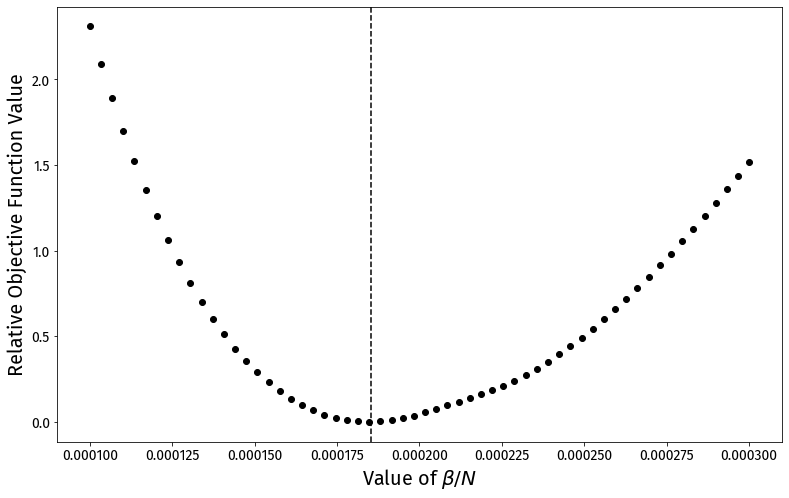

In [175]:
bNalsominf = min([s['f']-fr_ex(s['x']) for s in bNprofile])
plt.figure(figsize=[13,8],)
plt.plot(bNrange, [s['f']-bNalsominf -fr_ex(s['x']) for s in bNprofile], 'o', color='k',)
plt.axvline(float(bNfn(sols[idx])), linestyle='--', color='k')
# plt.ylim([-0.1, 2])
# plt.xlim([0.0001, 0.00025])
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Relative Objective Function Value', font_properties=label_font)
plt.xlabel('Value of $\\beta/N$', font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font);

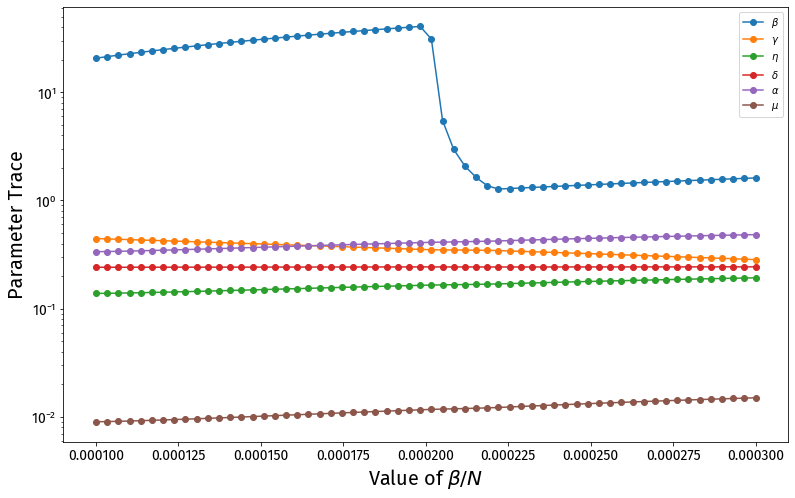

In [176]:
plt.figure(figsize=[13,8])
plt.plot(bNrange, [float(s['x'][-6]) for s in bNprofile], 'o-', label=r'$\beta$')
plt.plot(bNrange, [float(s['x'][-5]) for s in bNprofile], 'o-', label=r'$\gamma$')
plt.plot(bNrange, [float(s['x'][-4]) for s in bNprofile], 'o-', label=r'$\eta$')
plt.plot(bNrange, [float(s['x'][-3]) for s in bNprofile], 'o-', label=r'$\delta$')
plt.plot(bNrange, [float(s['x'][-2]) for s in bNprofile], 'o-', label=r'$\alpha$')
plt.plot(bNrange, [float(s['x'][-1]) for s in bNprofile], 'o-', label=r'$\mu$')
# plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylabel('Parameter Trace', font_properties=label_font)
plt.xlabel('Value of $\\beta/N$', font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font);

Text(0.5, 1.0, 'R0 by b/N')

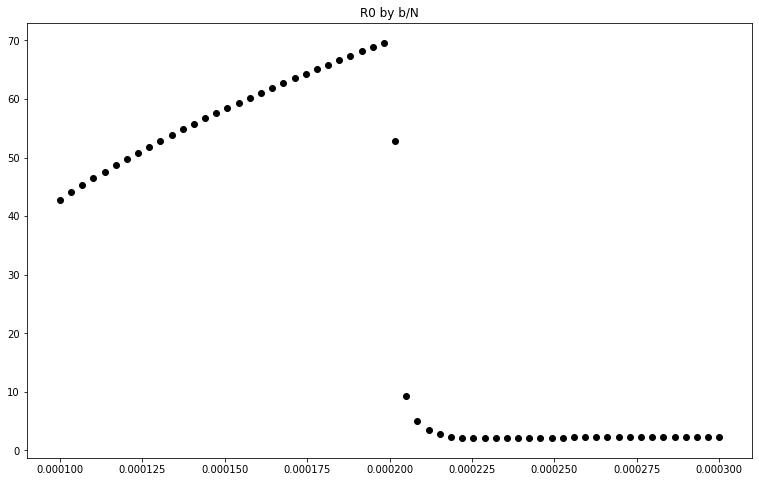

In [177]:
plt.figure(figsize=[13,8],)

plt.plot(bNrange,
        [r0(sol) for sol in bNprofile], 
         'o', color='k',)
# plt.axvline(float(getp(sols[idx]['x'])[0]), linestyle='--', color='k')
plt.title('R0 by b/N')

Text(0.5, 1.0, 'N by b/N')

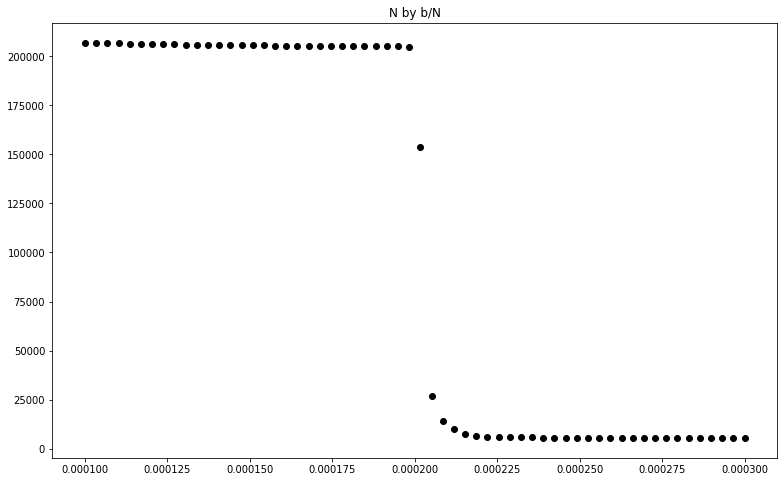

In [178]:
plt.figure(figsize=[13,8],)

plt.plot(bNrange,
        [N0(sol) for sol in bNprofile], 
         'o', color='k',)
plt.title('N by b/N')

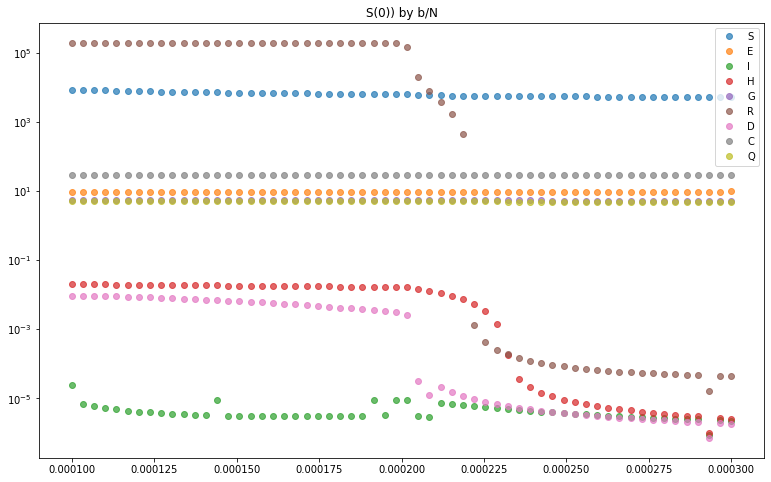

In [179]:
plt.figure(figsize=[13,8],)

plt.plot(bNrange,
        [[float(x[0]) for x in getx(sol['x'])] for sol in bNprofile ], 
         'o', alpha=0.7)
plt.title('S(0)) by b/N')
plt.legend('SEIHGRDCQ')
# ax = plt.gca().twinx()
# ax.plot(bNrange, [getx(sol['x'])[5][0] for sol in bNprofile], 'ro')
plt.yscale('log')

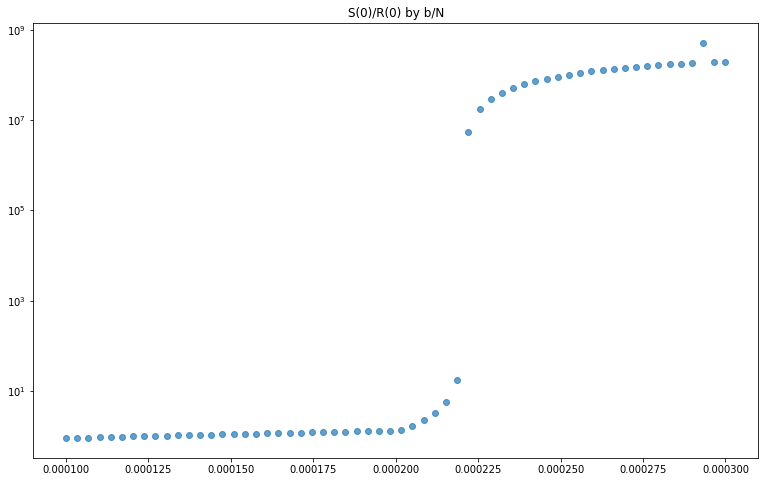

In [182]:
plt.figure(figsize=[13,8],)

plt.plot(bNrange,
        [getp(sol['x'])[0]*getx(sol['x'])[0][0]/getx(sol['x'])[5][0] for sol in bNprofile ], 
         'o', alpha=0.7)
plt.title('S(0)/R(0) by b/N')
plt.yscale('log')

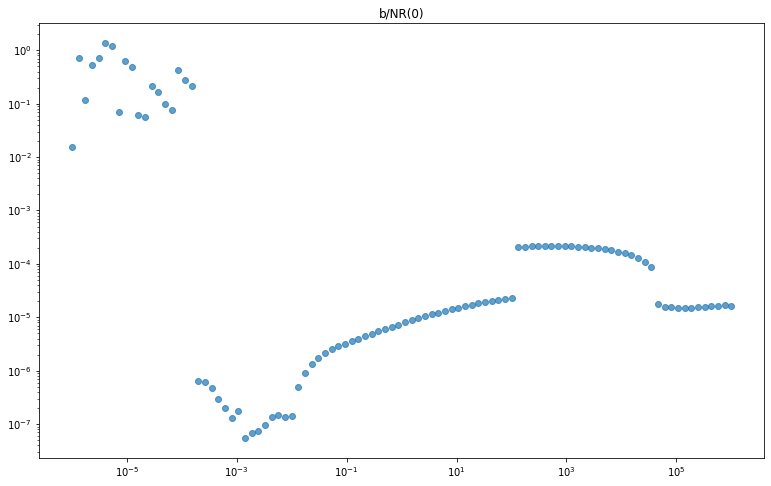

In [181]:
plt.figure(figsize=[13,8],)

plt.plot(prange,
        [getp(sol['x'])[0]/N0(sol)/r0(sol) for sol in  sols], 
         'o', alpha=0.7)
plt.title('b/NR(0)')
plt.yscale('log')
plt.xscale('log')